# Libraries

In [1]:
import collections
import copy
import itertools
import json
import logging
# Imports and setup
import os
from collections import defaultdict
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import to_dense_adj, k_hop_subgraph
from tqdm.notebook import tqdm

In [2]:
import warnings
from Bio.PDB.PDBExceptions import PDBConstructionWarning

# Suppress PDB warnings globally
warnings.simplefilter('ignore', PDBConstructionWarning)

from preprocessing_v3 import ProteinAnalyzer, process_pdb_directory
#from utils_ln import load_aa_info  # Or define `load_aa_info` in the same script

# Configuration

In [3]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set environment variable for MPS fallback
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Set plot style
sns.set_theme()

# Device setup
def get_device():
    """Get the best available device with fallbacks"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        logger.info("MPS (M1/M2) device found but using CPU for some operations due to compatibility")
        return torch.device('cpu')
    return torch.device('cpu')

def compute_average_edges(data_loader):
    """
    Compute the average number of edges and nodes in the dataset
    """
    total_edges = 0
    total_nodes = 0
    num_graphs = 0

    for batch in data_loader:
        total_edges += batch.edge_index.size(1) // 2  # Divide by 2 for undirected edges
        total_nodes += batch.x.size(0)
        num_graphs += 1

    return {
        'avg_edges': total_edges / num_graphs,
        'avg_nodes': total_nodes / num_graphs,
        'avg_backbone': total_nodes / num_graphs - 1  # One less than nodes
    }

# Paths and constants

In [4]:
# Define the file for a demo protein structure
pdb_file = 'data/all_nano_structures_single_domain/1zv5.pdb'

# Define the directory containing the PDB files
pdb_directory = 'data/all_nano_structures_single_domain'

# Define the file containing amino acid information
aa_info_file = 'aa_mass_letter.csv'

# Preprocessed protein dataframes 
output_dir = "processed_dataframes"

# Preprocessing

In [5]:
# Load amino acid information
aa_info = pd.read_csv(aa_info_file)
aa_info['Abbrev.'] = aa_info['Abbrev.'].apply(lambda x: x.upper())
aa_info_dict = aa_info.set_index('Abbrev.').to_dict(orient='index')
#aa_info_dict

In [6]:
# Process PDB directory
dataframes = process_pdb_directory(pdb_directory, aa_info_dict, neighborhood_radius=5.0)


Processing PDBs: 100%|██████████| 1636/1636 [08:46<00:00,  3.11it/s]


In [7]:
dataframes[30]

('data/all_nano_structures_single_domain/6rbb.pdb',
              X          Y       Z   Avg_Mass  Avg_Neighbor_Dist  \
 0     0.694000  -4.277000   5.308  174.20274           3.721274   
 1    -2.990000  -4.576000   5.740   75.06714           4.198928   
 2    -6.508000  -3.784000   4.701  105.09344           3.805953   
 3    -8.875000  -3.795000   7.749  147.13074           3.833386   
 4    -6.175000  -5.348000   9.939  165.19184           3.788165   
 ..         ...        ...     ...        ...                ...   
 478 -33.832001 -20.900999  10.996  117.14784           4.169421   
 479 -33.150002 -18.483999   8.138  119.12034           4.082392   
 480 -34.498001 -14.935000   8.444  117.14784           4.093996   
 481 -34.692001 -12.858000   5.268  105.09344           4.145524   
 482 -34.766998  -9.058000   5.304  105.09344           3.800911   
 
      Max_Neighbor_Dist  Neighbor_Count  Small_Molecules_Found  
 0             3.721274               1                      1  


In [8]:
import os

# Directory to store processed DataFrames
os.makedirs(output_dir, exist_ok=True)

# Save each DataFrame to a pickle file
for pdb_file, df in dataframes:
    pdb_id = os.path.basename(pdb_file).replace('.pdb', '')  # Extract PDB ID from filename
    df.to_pickle(os.path.join(output_dir, f"{pdb_id}.pkl"))

print(f"DataFrames saved in {output_dir} as pickle files")


DataFrames saved in processed_dataframes as pickle files


# Graph conversion

In [9]:
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors

def nanobody_to_graph(df, k=10, include_coordinates=True):
    """
    Convert a nanobody DataFrame into a graph for GTA-based GNNs.

    Parameters:
    - df: DataFrame containing nanobody data.
    - k: Number of nearest neighbors for graph connectivity.
    - include_coordinates: Whether to include 3D coordinates in node features.

    Returns:
    - PyTorch Geometric Data object.
    """
    # Step 1: Node Features
    features_to_include = ['Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist', 'Neighbor_Count', 'Small_Molecules_Found']
    node_features = df[features_to_include].values

    # Optionally include coordinates in node features
    if include_coordinates:
        coords = df[['X', 'Y', 'Z']].values
        node_features = np.hstack([node_features, coords])

    # Convert to tensor
    node_features = torch.tensor(node_features, dtype=torch.float)

    # Step 2: KNN-based Edge Construction
    coords = df[['X', 'Y', 'Z']].values
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)

    edge_index = []
    edge_attr = []
    for i in range(len(indices)):
        for j in range(1, k):  # Skip self-loop (j=0)
            edge_index.append([i, indices[i, j]])
            edge_attr.append([distances[i, j]])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # Step 3: Create Graph Data Object
    data = Data(
        x=node_features,      # Node features
        edge_index=edge_index,  # Edges
        edge_attr=edge_attr,   # Edge features (distances)
    )
    return data


In [10]:
graphs = []  # Define `graphs` outside the loop
for pdb_file, df in tqdm(dataframes, desc="Processing", unit="graph", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"):
    graph = nanobody_to_graph(df, k=5, include_coordinates=True)
    graphs.append((pdb_file, graph))


Processing:   0%|          | 0/1636 [00:00<?]

# Graph representation vs reality

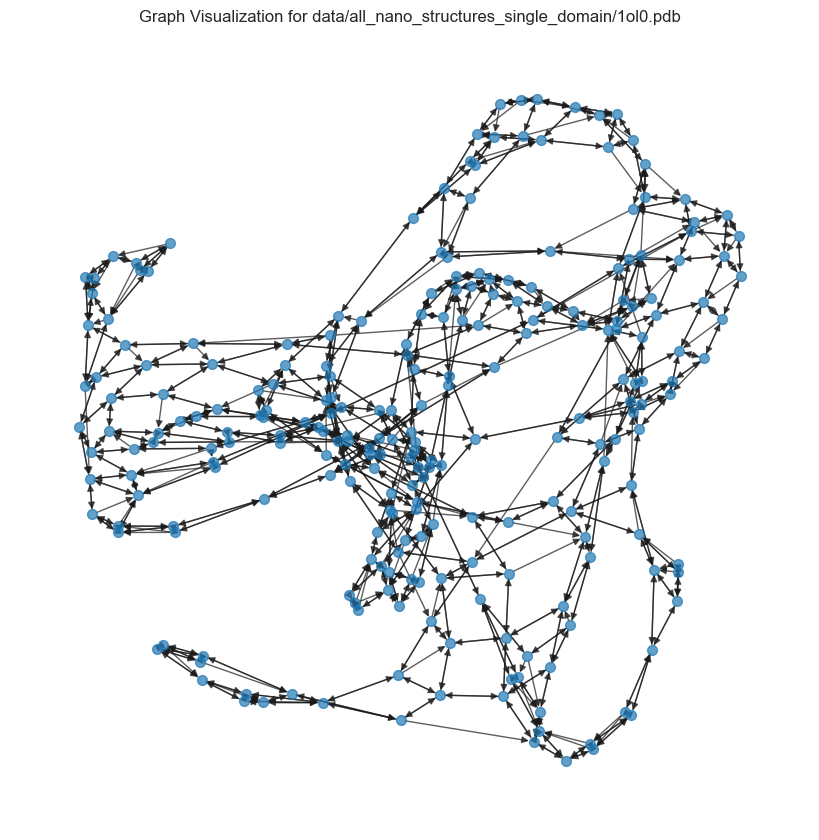

In [11]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

def visualize_nanobody_graph(data, pdb_file):
    """Visualize the nanobody graph."""
    G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=False, node_size=50, alpha=0.7)
    plt.title(f"Graph Visualization for {pdb_file}")
    plt.show()

# Example
pdb_file, data = graphs[10]
visualize_nanobody_graph(data, pdb_file)


In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Define amino acid masses and their corresponding colors
AMINO_ACID_DATA = [
    (89.09404, "Alanine", "blue"),
    (121.15404, "Cysteine", "green"),
    (133.10384, "Aspartic acid", "red"),
    (147.13074, "Glutamic acid", "cyan"),
    (165.19184, "Phenylalanine", "magenta"),
    (75.06714, "Glycine", "yellow"),
    (155.15634, "Histidine", "orange"),
    (131.17464, "Isoleucine/Leucine", "purple"),
    (146.18934, "Lysine", "brown"),
    (149.20784, "Methionine", "pink"),
    (132.11904, "Asparagine", "lime"),
    (255.31000, "Pyrrolysine", "gold"),
    (115.13194, "Proline", "silver"),
    (146.14594, "Glutamine", "teal"),
    (174.20274, "Arginine", "coral"),
    (105.09344, "Serine", "navy"),
    (119.12034, "Threonine", "olive"),
    (168.05300, "Selenocysteine", "maroon"),
    (117.14784, "Valine", "black"),
    (204.22844, "Tryptophan", "violet"),
    (181.19124, "Tyrosine", "gray"),
]

# Convert amino acid data to lookup tables
MASS_TO_COLOR = {mass: color for mass, _, color in AMINO_ACID_DATA}
MASS_TO_NAME = {mass: name for mass, name, _ in AMINO_ACID_DATA}

def map_mass_to_color(mass):
    """Find the closest amino acid mass and return its color."""
    closest_mass = min(MASS_TO_COLOR.keys(), key=lambda m: abs(m - mass))
    return MASS_TO_COLOR[closest_mass]

def visualize_nanobody_graph_aminoacids(data, pdb_file):
    """
    Visualize a nanobody graph with amino acid-specific colors.

    Parameters:
    - data: PyTorch Geometric Data object.
    - pdb_file: Name of the nanobody structure file.
    """
    # Convert to NetworkX graph
    G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])

    # Use a layout (try 'spring', 'kamada_kawai', or others)
    pos = nx.spring_layout(G, seed=42)

    # Map nodes to amino acid colors using Avg_Mass (x[0])
    node_colors = [
        map_mass_to_color(node[1]['x'][0]) for node in G.nodes(data=True)
    ]

    # Scale node sizes dynamically (e.g., based on Neighbor_Count, x[3])
    node_sizes = [max(10, node[1]['x'][3] * 50) for node in G.nodes(data=True)]  # Assuming Neighbor_Count is x[3]

    # Scale edge widths dynamically based on edge distances (edge_attr)
    edge_weights = [max(0.1, edge[2]['edge_attr'][0]) for edge in G.edges(data=True)]

    # Create the figure and axes explicitly
    fig, ax = plt.subplots(figsize=(10, 10))

    # Draw the graph
    nx.draw(
        G,
        pos,
        ax=ax,  # Explicitly set the axes for the graph
        with_labels=False,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color='gray',  # Static edge color for better node visibility
        width=edge_weights,
        alpha=0.9  # Transparency for better visibility
    )

    # Add a legend for amino acid colors
    legend_patches = [
        mpl.patches.Patch(color=color, label=name)
        for _, name, color in AMINO_ACID_DATA
    ]
    ax.legend(handles=legend_patches, loc='upper left', fontsize=8, title="Amino Acids")

    # Add a title
    ax.set_title(f"Graph Visualization for {pdb_file}", fontsize=14)
    plt.show()


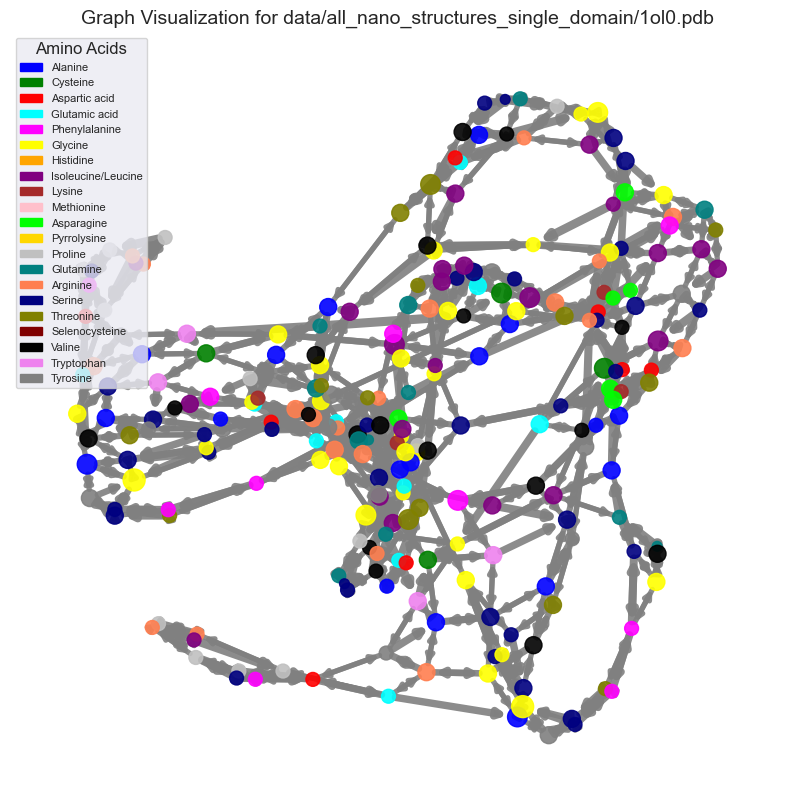

In [13]:
# Example
pdb_file, data = graphs[10]
visualize_nanobody_graph_aminoacids(data, pdb_file)

In [14]:
# from IPython.display import display
# from PIL import Image
# import matplotlib.pyplot as plt

# # Paths to your images
# image_path_1 = "data/mab_dataset/3sn6.png"
# image_path_2 = "data/mab_dataset/3sn6_plot.png"

# # Open the images using PIL
# image_1 = Image.open(image_path_1)
# image_2 = Image.open(image_path_2)

# # Create a matplotlib figure
# fig, axes = plt.subplots(1, 2, figsize=(15, 8))  # 1 row, 2 columns

# # Display the first image
# axes[0].imshow(image_1)
# axes[0].axis('off')  # Hide axes
# axes[0].set_title("Image 1: Original")

# # Display the second image
# axes[1].imshow(image_2)
# axes[1].axis('off')  # Hide axes
# axes[1].set_title("Image 2: Plot")

# # Show the images
# plt.tight_layout()
# plt.show()


# Dataloader

In [15]:
# from torch_geometric.loader import DataLoader
# from sklearn.model_selection import train_test_split

# def split_and_batch_graphs(graphs, batch_size=8, train_ratio=0.8, seed=42):
#     """
#     Split the graphs into train and test datasets, and create DataLoaders for batching.

#     Parameters:
#     - graphs (list): List of `torch_geometric.data.Data` graphs.
#     - batch_size (int): Batch size for the DataLoader.
#     - train_ratio (float): Proportion of data to use for training.
#     - seed (int): Random seed for reproducibility.

#     Returns:
#     - train_loader (DataLoader): DataLoader for the training set.
#     - test_loader (DataLoader): DataLoader for the testing set.
#     """
#     # Set random seed for reproducibility
#     torch.manual_seed(seed)
    
#     # Split into train and test sets
#     train_graphs, test_graphs = train_test_split(graphs, train_size=train_ratio, random_state=seed)
    
#     # Create DataLoaders
#     train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)
    
#     return train_loader, test_loader


In [16]:
# # Unpack graphs
# graph_data = [graph for _, graph in graphs]  # Extract only the `Data` objects

# # Split and batch the graphs
# train_loader, test_loader = split_and_batch_graphs(graph_data, batch_size=16, train_ratio=0.8, seed=42)

# # Optional: Keep file names for reference
# pdb_files = [pdb_file for pdb_file, _ in graphs]

# # Example: Iterate through training batches
# for batch in train_loader:
#     print(batch)  # This should now work as expected


# GTA VAE Alex V10

In [61]:
import torch
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import matplotlib.pyplot as plt

def prepare_graphs_for_vae(graph_tuples, batch_size=16, train_ratio=0.8, shuffle=True):
    """
    Prepare PDB graph data for VAE training with normalization
    """
    # Extract PyG Data objects
    graphs = [g[1] for g in graph_tuples]

    # Calculate normalization statistics across all graphs
    all_features = torch.cat([g.x for g in graphs], dim=0)
    feature_means = all_features.mean(dim=0)
    feature_stds = all_features.std(dim=0)

    # Prevent division by zero
    feature_stds = torch.where(feature_stds == 0, torch.ones_like(feature_stds), feature_stds)

    # Normalize all graphs
    for graph in graphs:
        graph.x = (graph.x - feature_means) / feature_stds

        # Also normalize edge attributes (distances)
        if graph.edge_attr is not None:
            edge_mean = graph.edge_attr.mean()
            edge_std = graph.edge_attr.std()
            if edge_std > 0:
                graph.edge_attr = (graph.edge_attr - edge_mean) / edge_std

    # Rest of your existing function...
    train_graphs, test_graphs = train_test_split(
        graphs,
        train_size=train_ratio,
        shuffle=shuffle,
        random_state=42
    )

    train_loader = DataLoader(
        train_graphs,
        batch_size=batch_size,
        shuffle=shuffle
    )

    test_loader = DataLoader(
        test_graphs,
        batch_size=batch_size,
        shuffle=False
    )

    sample_data = train_graphs[0]
    in_channels = sample_data.x.size(1)

    print(f"Dataset prepared:")
    print(f"Number of training graphs: {len(train_graphs)}")
    print(f"Number of test graphs: {len(test_graphs)}")
    print(f"Number of features per node: {in_channels}")
    print(f"Feature means:", feature_means)
    print(f"Feature stds:", feature_stds)

    # Return normalization parameters for later use (e.g., inference)
    return train_loader, test_loader, in_channels, (feature_means, feature_stds)

def setup_and_train_vae(graph_tuples, batch_size=16, hidden_channels=64, latent_channels=32, num_heads=4, num_epochs=100):
    """
    Set up the VAE and start training with attention-based handling of variable-sized graphs
    """
    # Set up device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Prepare data
    train_loader, test_loader, in_channels = prepare_graphs_for_vae(
        graph_tuples,
        batch_size=batch_size
    )

    # Initialize model
    model = ProteinGraphVAE(
        in_channels=in_channels,
        hidden_channels=hidden_channels,
        latent_channels=latent_channels,
        num_heads=num_heads
    ).to(device)

    # Train model
    trained_model, train_losses, test_losses = train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        device=device,
        num_epochs=num_epochs
    )

    return trained_model, train_losses, test_losses, (train_loader, test_loader)

In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class ProteinGraphVAE(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_channels=32, num_heads=4, edge_dim=1):
        super(ProteinGraphVAE, self).__init__()

        # Model parameters
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.latent_channels = latent_channels
        self.edge_dim = edge_dim
        self.training_factor = nn.Parameter(torch.zeros(1))  # Learnable noise scaling

        # Feature indices
        self.coord_indices = slice(-3, None)
        self.mass_index = 0
        self.distance_indices = slice(1, 3)
        self.count_index = 3
        self.small_mol_index = 4

        # Loss weights
        self.loss_weights = {
            'mass': 0.1,
            'distance': 0.1,
            'count': 0.1,
            'small_mol': 0.1,
            'coord': 0.1,
            'edge': 0.1
        }

        # Enhanced Encoder with multiple GAT layers
        self.encoder_conv1 = torch.nn.ModuleList([
            GATConv(in_channels, hidden_channels, heads=4, edge_dim=edge_dim),
            GATConv(hidden_channels * 4, hidden_channels, heads=2, edge_dim=edge_dim),
            GATConv(hidden_channels * 2, hidden_channels, heads=1, edge_dim=edge_dim)
        ])

        # Batch normalization layers for encoder
        self.encoder_batch_norms = torch.nn.ModuleList([
            nn.BatchNorm1d(hidden_channels * 4),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.BatchNorm1d(hidden_channels)
        ])

        # Enhanced encoder feedforward
        self.encoder_ff = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.Dropout(0.2),
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels)
        )

        # Enhanced latent space projections
        self.fc_mu = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels),
            nn.Linear(hidden_channels, latent_channels)
        )

        self.fc_logvar = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels),
            nn.Linear(hidden_channels, latent_channels)
        )

        # Enhanced shared decoder
        self.shared_decoder = nn.Sequential(
            nn.Linear(latent_channels, hidden_channels),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels),
            nn.Linear(hidden_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.Dropout(0.2),
            nn.Linear(hidden_channels * 2, hidden_channels * 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels * 2, hidden_channels)
        )

        # Enhanced feature-specific heads
        self.coord_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels),
            nn.Linear(hidden_channels, 3),
            nn.Tanh()
        )

        self.mass_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels),
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels // 2),
            nn.Linear(hidden_channels // 2, 1),
            nn.Softplus()
        )

        self.distance_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels),
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels),
            nn.Linear(hidden_channels, 2),
            nn.Softplus()
        )

        self.count_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels),
            nn.Linear(hidden_channels, 1),
            nn.Softplus()
        )

        self.small_mol_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels),
            nn.Dropout(0.1),
            nn.Linear(hidden_channels, 1)
        )

        # Enhanced edge decoder
        self.edge_decoder = nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.Dropout(0.2),
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels),
            nn.Linear(hidden_channels, edge_dim),
            nn.Softplus()
        )

    def encode(self, x, edge_index, edge_attr, batch):
        # Multi-layer graph convolutions
        for i, conv in enumerate(self.encoder_conv1):
            x = conv(x, edge_index, edge_attr=edge_attr)
            x = self.encoder_batch_norms[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=0.1, training=self.training)

        # Additional feature processing
        x = self.encoder_ff(x)

        # Global pooling
        x = global_mean_pool(x, batch)

        # Get latent parameters
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def decode(self, z, num_nodes, edge_index):
        batch_size = z.size(0)

        # Add position-specific noise with learned scaling
        z = z.unsqueeze(1).expand(-1, num_nodes, -1)
        noise_scale = torch.sigmoid(self.training_factor) * 0.1
        position_noise = torch.randn_like(z) * noise_scale
        z = z + position_noise
        z = z.reshape(-1, self.latent_channels)

        # Decode features through shared decoder
        h = self.shared_decoder(z)

        # Decode node features with specific heads
        coords = self.coord_head(h) * 10
        mass = self.mass_head(h)
        distances = self.distance_head(h)
        counts = self.count_head(h)
        small_mols = self.small_mol_head(h)

        # Decode edge attributes
        row, col = edge_index
        edge_features = torch.cat([h[row], h[col]], dim=1)
        decoded_edges = self.edge_decoder(edge_features)

        # Combine features
        features = torch.cat([mass, distances, counts, small_mols, coords], dim=1)
        return features.view(batch_size, num_nodes, -1), decoded_edges

    def feature_specific_loss(self, recon, target, edge_recon, edge_target):
        """Calculate feature-specific losses with improved normalization"""
        losses = {}
        EPS = 1e-6

        # Mass loss with improved normalization
        mass_pred = F.softplus(recon[..., self.mass_index])
        mass_target = target[..., self.mass_index]
        mass_scale = mass_target.abs().mean() + EPS
        mass_pred_scaled = mass_pred / mass_scale
        mass_target_scaled = mass_target / mass_scale
        losses['mass'] = F.mse_loss(mass_pred_scaled, mass_target_scaled) * self.loss_weights['mass']

        # Distance loss
        dist_pred = F.softplus(recon[..., self.distance_indices])
        dist_target = target[..., self.distance_indices]
        dist_scale = dist_target.abs().mean() + EPS
        dist_pred_scaled = dist_pred / dist_scale
        dist_target_scaled = dist_target / dist_scale
        losses['distance'] = F.mse_loss(dist_pred_scaled, dist_target_scaled) * self.loss_weights['distance']

        # Count loss
        count_pred = F.softplus(recon[..., self.count_index])
        count_target = target[..., self.count_index]
        count_scale = count_target.abs().mean() + EPS
        count_pred_scaled = count_pred / count_scale
        count_target_scaled = count_target / count_scale
        losses['count'] = F.mse_loss(count_pred_scaled, count_target_scaled) * self.loss_weights['count']

        # Small molecules loss
        small_mol_pred = recon[..., self.small_mol_index]
        small_mol_target = target[..., self.small_mol_index].clamp(0, 1)
        losses['small_mol'] = F.binary_cross_entropy_with_logits(
            small_mol_pred,
            small_mol_target,
            reduction='mean'
        ) * self.loss_weights['small_mol']

        # Coordinate loss
        coord_pred = recon[..., self.coord_indices]
        coord_target = target[..., self.coord_indices]
        coord_scale = coord_target.abs().mean() + EPS
        coord_pred_scaled = coord_pred / coord_scale
        coord_target_scaled = coord_target / coord_scale
        losses['coord'] = F.mse_loss(coord_pred_scaled, coord_target_scaled) * self.loss_weights['coord']

        # Edge loss
        edge_pred = F.softplus(edge_recon)
        edge_target_pos = F.softplus(edge_target)
        edge_scale = edge_target_pos.abs().mean() + EPS
        edge_pred_scaled = edge_pred / edge_scale
        edge_target_scaled = edge_target_pos / edge_scale
        losses['edge'] = F.mse_loss(edge_pred_scaled, edge_target_scaled) * self.loss_weights['edge']

        # Calculate total loss
        total_loss = sum(loss for loss in losses.values() if torch.isfinite(loss))

        return total_loss, losses

    def forward(self, x, edge_index, edge_attr, batch):
        mu, logvar = self.encode(x, edge_index, edge_attr, batch)
        z = self.reparameterize(mu, logvar)

        unique, counts = torch.unique(batch, return_counts=True)
        max_nodes = counts.max().item()

        recon, edge_recon = self.decode(z, max_nodes, edge_index)
        return recon, edge_recon, mu, logvar

In [105]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def kl_annealing_factor(epoch, warmup_epochs=10, min_weight=0.0001, max_weight=1.0):
    """Compute KL annealing factor that gradually increases from min_weight to max_weight"""
    if epoch < warmup_epochs:
        return min_weight + (max_weight - min_weight) * (epoch / warmup_epochs)
    return max_weight

def compute_orthogonal_regularization(mu, lambda_ortho=0.1):
    """Compute orthogonality regularization for the latent space"""
    batch_size = mu.size(0)
    mu_normalized = F.normalize(mu, p=2, dim=1)  # Normalize each embedding
    correlation = torch.mm(mu_normalized.t(), mu_normalized) / batch_size
    identity = torch.eye(correlation.size(0), device=correlation.device)
    ortho_loss = lambda_ortho * torch.sum((correlation - identity) ** 2)
    return ortho_loss

def train_model(model, train_loader, test_loader, device, num_epochs=100,
                min_beta=0.0001, max_beta=0.01, warmup_epochs=10, lambda_ortho=0.1):
    """
    Train VAE model with KL annealing and orthogonal regularization
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    max_grad_norm = 1.0

    print(f"Starting training for {num_epochs} epochs...")
    print(f"Training on device: {device}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(test_loader)}")
    print(f"KL annealing: {min_beta} -> {max_beta} over {warmup_epochs} epochs")
    print(f"Orthogonal regularization strength: {lambda_ortho}")

    history = {
        'train': {
            'total_loss': [], 'recon_loss': [], 'kl_loss': [], 'ortho_loss': [],
            'mass_loss': [], 'distance_loss': [], 'count_loss': [],
            'small_mol_loss': [], 'coord_loss': [], 'edge_loss': [],
            'beta': []  # Track KL weight
        },
        'test': {
            'total_loss': [], 'recon_loss': [], 'kl_loss': [], 'ortho_loss': [],
            'mass_loss': [], 'distance_loss': [], 'count_loss': [],
            'small_mol_loss': [], 'coord_loss': [], 'edge_loss': []
        }
    }

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        epoch_losses = {k: 0.0 for k in history['train'].keys()}

        # Get current KL weight from annealing schedule
        current_beta = kl_annealing_factor(epoch, warmup_epochs, min_beta, max_beta)
        epoch_losses['beta'] = current_beta

        # Progress bar for training
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        batch_count = 0

        for batch in pbar:
            try:
                batch = batch.to(device)
                optimizer.zero_grad()

                # Debug info for first batch
                if batch_count == 0 and epoch == 0:
                    print(f"\nBatch shapes:")
                    print(f"Input x shape: {batch.x.shape}")
                    print(f"Edge index shape: {batch.edge_index.shape}")
                    print(f"Edge attr shape: {batch.edge_attr.shape}")

                # Forward pass
                recon_batch, edge_recon, mu, logvar = model(batch.x, batch.edge_index,
                                                            batch.edge_attr, batch.batch)

                if batch_count == 0 and epoch == 0:
                    print(f"Reconstruction shape: {recon_batch.shape}")
                    print(f"Edge reconstruction shape: {edge_recon.shape}")

                # Reshape original data
                _, counts = torch.unique(batch.batch, return_counts=True)
                max_nodes = counts.max()
                batch_size = len(counts)
                padded_x = torch.zeros(batch_size, max_nodes, batch.x.size(1), device=device)

                start_idx = 0
                for i, count in enumerate(counts):
                    padded_x[i, :count] = batch.x[start_idx:start_idx + count]
                    start_idx += count

                # Calculate losses
                recon_loss, feature_losses = model.feature_specific_loss(
                    recon_batch, padded_x, edge_recon, batch.edge_attr)

                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

                # Add orthogonality regularization
                ortho_loss = compute_orthogonal_regularization(mu, lambda_ortho)

                # Combine losses with annealed KL weight
                loss = recon_loss + current_beta * kl_loss + ortho_loss

                # Detailed diagnostics every 10 batches
                if batch_count % 10 == 0:
                    with torch.no_grad():
                        print("\nDetailed loss diagnostics:")
                        print(f"Raw recon_loss: {recon_loss.item():.4f}")
                        print(f"Raw KL loss: {kl_loss.item():.4f}")
                        print(f"Ortho loss: {ortho_loss.item():.4f}")
                        print(f"Current beta: {current_beta:.4f}")
                        print(f"mu mean: {mu.mean().item():.4f}, std: {mu.std().item():.4f}")
                        print(f"logvar mean: {logvar.mean().item():.4f}, std: {logvar.std().item():.4f}")
                        for k, v in feature_losses.items():
                            print(f"{k}: {v.item():.4f}")

                # Backward pass with gradient clipping
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                # Update progress bar and losses
                batch_count += 1
                epoch_losses['total_loss'] += loss.item()
                epoch_losses['recon_loss'] += recon_loss.item()
                epoch_losses['kl_loss'] += kl_loss.item()
                epoch_losses['ortho_loss'] += ortho_loss.item()
                for k, v in feature_losses.items():
                    epoch_losses[f'{k}_loss'] += v.item()

                # Update progress bar description
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'recon': f'{recon_loss.item():.4f}',
                    'kl': f'{kl_loss.item():.4f}',
                    'ortho': f'{ortho_loss.item():.4f}'
                })

            except Exception as e:
                print(f"\nError in batch {batch_count}:")
                print(str(e))
                print("Batch details:")
                print(f"Batch size: {batch.num_graphs}")
                print(f"Number of nodes: {batch.num_nodes}")
                print(f"Number of edges: {batch.num_edges}")
                continue

        # Average losses
        num_batches = len(train_loader)
        for k in epoch_losses:
            if k != 'beta':  # Don't average the beta value
                epoch_losses[k] = epoch_losses[k] / num_batches
            history['train'][k].append(epoch_losses[k])

        # Validation phase
        model.eval()
        test_losses = {k: 0.0 for k in history['test'].keys()}

        print("\nStarting validation...")
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]'):
                batch = batch.to(device)
                recon_batch, edge_recon, mu, logvar = model(batch.x, batch.edge_index,
                                                            batch.edge_attr, batch.batch)

                # Reshape original data
                _, counts = torch.unique(batch.batch, return_counts=True)
                max_nodes = counts.max()
                batch_size = len(counts)
                padded_x = torch.zeros(batch_size, max_nodes, batch.x.size(1), device=device)

                start_idx = 0
                for i, count in enumerate(counts):
                    padded_x[i, :count] = batch.x[start_idx:start_idx + count]
                    start_idx += count

                recon_loss, feature_losses = model.feature_specific_loss(
                    recon_batch, padded_x, edge_recon, batch.edge_attr)
                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                ortho_loss = compute_orthogonal_regularization(mu, lambda_ortho)
                loss = recon_loss + current_beta * kl_loss + ortho_loss

                test_losses['total_loss'] += loss.item()
                test_losses['recon_loss'] += recon_loss.item()
                test_losses['kl_loss'] += kl_loss.item()
                test_losses['ortho_loss'] += ortho_loss.item()
                for k, v in feature_losses.items():
                    test_losses[f'{k}_loss'] += v.item()

        # Average test losses
        for k in test_losses:
            test_losses[k] /= len(test_loader)
            history['test'][k].append(test_losses[k])

        epoch_time = time.time() - epoch_start_time

        # Print epoch summary
        print(f'\nEpoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f}s')
        print(f'Train - Total: {epoch_losses["total_loss"]:.4f}, '
              f'Recon: {epoch_losses["recon_loss"]:.4f}, '
              f'KL: {epoch_losses["kl_loss"]:.4f}, '
              f'Ortho: {epoch_losses["ortho_loss"]:.4f}, '
              f'Beta: {current_beta:.4f}')
        print('Feature Losses:')
        for k in ['mass_loss', 'distance_loss', 'count_loss',
                  'small_mol_loss', 'coord_loss', 'edge_loss']:
            print(f'  {k}: {epoch_losses[k]:.4f}')

        # Plot training progress
        if (epoch + 1) % 1 == 0:  # Plot every epoch
            plt.figure(figsize=(20, 10))

            # Plot 1: Total, Reconstruction, KL, and Ortho losses
            plt.subplot(2, 2, 1)
            plt.plot(history['train']['total_loss'], label='Total Loss')
            plt.plot(history['train']['recon_loss'], label='Reconstruction Loss')
            plt.plot(history['train']['kl_loss'], label='KL Loss')
            plt.plot(history['train']['ortho_loss'], label='Ortho Loss')
            plt.plot(history['train']['beta'], label='Beta (KL weight)')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Losses')
            plt.legend()
            plt.grid(True)

            # Plot 2: Feature-specific losses
            plt.subplot(2, 2, 2)
            for k in ['mass_loss', 'distance_loss', 'count_loss',
                      'small_mol_loss', 'coord_loss', 'edge_loss']:
                plt.plot(history['train'][k], label=k.replace('_loss', ''))
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Feature-specific Losses')
            plt.legend()
            plt.grid(True)

            # Plot 3: Feature-specific losses (log scale)
            plt.subplot(2, 2, 3)
            for k in ['mass_loss', 'distance_loss', 'count_loss',
                      'small_mol_loss', 'coord_loss', 'edge_loss']:
                values = [max(1e-10, abs(x)) for x in history['train'][k]]
                plt.semilogy(values, label=k.replace('_loss', ''))
            plt.xlabel('Epoch')
            plt.ylabel('Loss (log scale)')
            plt.title('Feature-specific Losses (Log Scale)')
            plt.legend()
            plt.grid(True)

            # Plot 4: Training vs Validation losses
            plt.subplot(2, 2, 4)
            plt.plot(history['train']['total_loss'], label='Train Loss')
            plt.plot(history['test']['total_loss'], label='Val Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training vs Validation Loss')
            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()

    print("\nTraining completed!")
    return model, history

In [107]:
# First, instantiate the model
model = ProteinGraphVAE(
    in_channels=8,
    hidden_channels=64,
    latent_channels=16,
    num_heads=4,
    edge_dim=1
)

# Print model structure and parameter count
print("Model structure:")
print(model)

print("\nParameter count by layer:")
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()} parameters")
        total_params += param.numel()
print(f"\nTotal trainable parameters: {total_params}")

Model structure:
ProteinGraphVAE(
  (encoder_conv1): ModuleList(
    (0): GATConv(8, 64, heads=4)
    (1): GATConv(256, 64, heads=2)
    (2): GATConv(128, 64, heads=1)
  )
  (encoder_batch_norms): ModuleList(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder_ff): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_mu): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchN

In [108]:
device=get_device()

INFO:__main__:MPS (M1/M2) device found but using CPU for some operations due to compatibility


In [109]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

def plot_latent_space(model, data_loader, device, method='pca'):
    """
    Plot the latent space of the model using PCA or t-SNE.

    Args:
        model: Trained ProteinGraphVAE model.
        data_loader: DataLoader containing the data.
        device: torch device.
        method: Dimensionality reduction method ('pca' or 'tsne').

    Returns:
        None
    """
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            mu, logvar = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z.cpu().numpy())
            labels.append(batch.batch.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=300)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")

    reduced_latent = reducer.fit_transform(latent_vectors)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_latent[:, 0], reduced_latent[:, 1], c=labels[:reduced_latent.shape[0]], cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Batch')
    plt.title(f'Latent Space Visualization ({method.upper()})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

In [110]:
# Adjust batch size for better gradient estimates
train_loader, test_loader, in_channels, norm_params = prepare_graphs_for_vae(
    graphs,
    batch_size=16,  # Increased batch size
    train_ratio=0.8,
    shuffle=True
)

Dataset prepared:
Number of training graphs: 1308
Number of test graphs: 328
Number of features per node: 8
Feature means: tensor([-2.2879e-09, -4.5757e-10,  3.4494e-09,  1.3305e-08,  1.7266e-09,
         5.6735e-09,  7.4301e-09,  5.7879e-09])
Feature stds: tensor([1., 1., 1., 1., 1., 1., 1., 1.])


/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


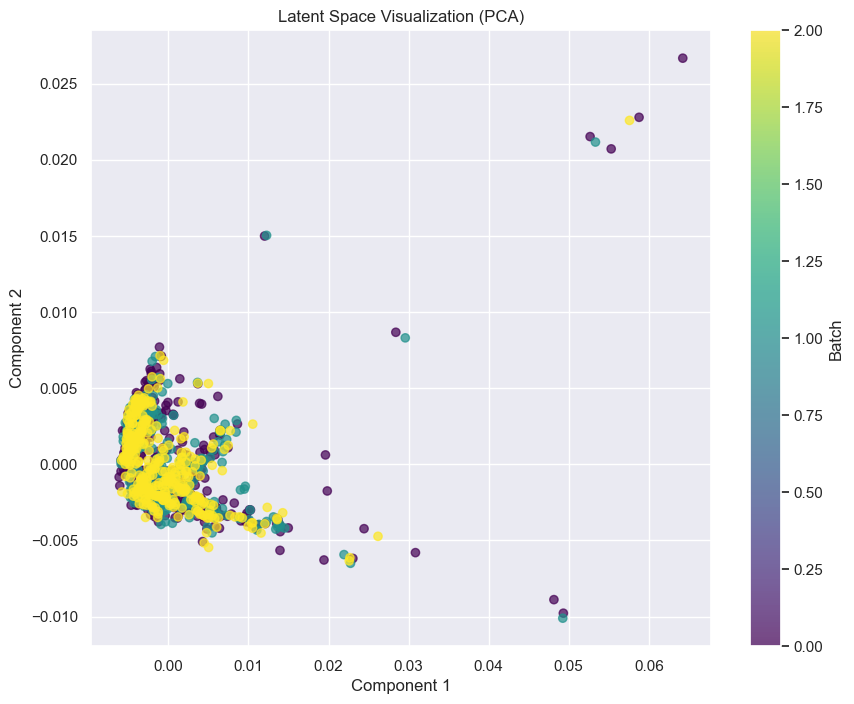

In [111]:
# Assuming `train_loader` is your DataLoader and `model` is your ProteinGraphVAE instance
plot_latent_space(model, train_loader, device, method='pca')

In [112]:
def sample_and_decode(model, num_samples=5, device='cpu'):
    """
    Sample random latent vectors and decode them to check for diversity in outputs.

    Args:
        model: Trained ProteinGraphVAE model.
        num_samples: Number of samples to generate.
        device: torch device.

    Returns:
        List of decoded node features.
    """
    model.eval()
    decoded_samples = []

    with torch.no_grad():
        for _ in range(num_samples):
            z = torch.randn(1, model.latent_channels, device=device)
            node_counts = torch.tensor([500], device=device)  # Adjust node count as needed
            edge_index = torch.zeros((2, 0), dtype=torch.long, device=device)  # Dummy edge_index
            node_features, edge_attr = model.decode(z, node_counts, edge_index)
            decoded_samples.append(node_features.cpu().numpy())

    return decoded_samples

# Example usage
decoded_samples = sample_and_decode(model, num_samples=5, device=device)
for i, sample in enumerate(decoded_samples):
    print(f"Sample {i+1}:")
    print(sample)

Sample 1:
[[[ 0.6373683   0.6422995   0.6683178  ...  0.3383873  -0.22791229
   -1.1162192 ]
  [ 0.63749325  0.64222664  0.6683865  ...  0.33830854 -0.22559458
   -1.1156161 ]
  [ 0.6376205   0.64206934  0.668384   ...  0.33910972 -0.22040991
   -1.1158665 ]
  ...
  [ 0.6376349   0.6421375   0.6684954  ...  0.33971214 -0.22273107
   -1.1173954 ]
  [ 0.6375274   0.6422222   0.66839236 ...  0.33859664 -0.22292784
   -1.1167812 ]
  [ 0.6375623   0.64206654  0.6683409  ...  0.33919013 -0.21553409
   -1.1200302 ]]]
Sample 2:
[[[ 0.6384431   0.6426402   0.6698299  ...  0.38205212 -0.17956471
   -1.1489925 ]
  [ 0.6384328   0.64266586  0.66978776 ...  0.38552278 -0.17762652
   -1.1492604 ]
  [ 0.63840497  0.64275694  0.6697472  ...  0.38402855 -0.17884699
   -1.1505953 ]
  ...
  [ 0.6383917   0.64261705  0.66990364 ...  0.38247082 -0.1772478
   -1.1455574 ]
  [ 0.63835543  0.6427085   0.6697873  ...  0.3872226  -0.17402807
   -1.147958  ]
  [ 0.6385292   0.642708    0.6698362  ...  0.38616452

In [113]:
import torch
import torch.nn.functional as F


import torch

import torch

def generate_protein(model, n_nodes=500, device='cpu', feature_stats=None):
    """
    Generate a new protein structure from random latent vector

    Args:
        model: Trained ProteinGraphVAE model
        n_nodes: Number of nodes to generate
        device: torch device
        feature_stats: Tuple of (means, stds) used during training for normalization
    """
    model.eval()
    z = torch.randn(1, model.latent_channels, device=device)
    node_counts = torch.tensor([n_nodes], device=device)

    # Generate the edge index using a simple approach
    edge_probability = 0.1
    num_edges = int(n_nodes * (n_nodes - 1) * edge_probability / 2)
    row = torch.randint(0, n_nodes, (num_edges,), device=device)
    col = torch.randint(0, n_nodes, (num_edges,), device=device)
    edge_index = torch.stack([row, col], dim=0)

    with torch.no_grad():
        node_features, edge_attr = model.decode(z, node_counts, edge_index)

        # Denormalize if stats provided
        if feature_stats is not None:
            means, stds = feature_stats
            node_features = node_features * stds + means

    return node_features, edge_index, edge_attr

def plot_protein_structure(node_features, edge_index, title="Protein Structure"):
    coords = node_features[:, :3].cpu().numpy()
    edge_index_np = edge_index.cpu().numpy()

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot nodes
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], s=50, c='blue')

    # Plot edges
    edges_x = []
    edges_y = []
    edges_z = []
    for i in range(edge_index_np.shape[1]):
        start_idx = edge_index_np[0, i]
        end_idx = edge_index_np[1, i]

        # Check if the indices are within the range of the node_features tensor
        if start_idx < coords.shape[0] and end_idx < coords.shape[0]:
            edges_x.extend([coords[start_idx, 0], coords[end_idx, 0], None])
            edges_y.extend([coords[start_idx, 1], coords[end_idx, 1], None])
            edges_z.extend([coords[start_idx, 2], coords[end_idx, 2], None])

    ax.plot(edges_x, edges_y, edges_z, c='gray', linewidth=1)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    plt.show()
    
def print_node_statistics(node_features):
    """
    Print statistics about the generated nodes
    """
    print("\nNode Feature Statistics:")
    print(f"Number of nodes: {node_features.shape[0]}")

    # Print statistics for each feature
    feature_names = ['Mass', 'Avg Neighbor Dist', 'Max Neighbor Dist',
                     'Neighbor Count', 'Small Molecules', 'X', 'Y', 'Z']

    for i, name in enumerate(feature_names):
        if i == 1:  # Distance features are 2D
            values = node_features[:, 1:3]
            mean = values.mean(dim=0)
            std = values.std(dim=0)
            print(f"\n{name}:")
            print(f"Mean: {mean.tolist()}")
            print(f"Std: {std.tolist()}")
        elif i < 5:  # Other scalar features
            values = node_features[:, i]
            print(f"\n{name}:")
            print(f"Mean: {values.mean():.3f}")
            print(f"Std: {values.std():.3f}")
            print(f"Min: {values.min():.3f}")
            print(f"Max: {values.max():.3f}")

    # Print coordinate statistics
    coords = node_features[:, 5:8]
    print("\nCoordinate Statistics:")
    print(f"Center of mass: {coords.mean(dim=0).tolist()}")
    print(f"Spatial extent: {coords.std(dim=0).tolist()}")

# Usage example:
def generate_and_visualize_protein(model, n_nodes=500, device='cpu'):
    """
    Generate and visualize a new protein structure
    """
    # Generate protein
    node_features, edge_index, edge_attr = generate_protein(model, n_nodes, device)

    # Print statistics
    print_node_statistics(node_features)

    # Plot structure
    plot_protein_structure(node_features, edge_index)

    return node_features, edge_index, edge_attr


Node Feature Statistics:
Number of nodes: 1

Mass:
Mean: 0.220
Std: 0.640
Min: -1.146
Max: 0.700

Avg Neighbor Dist:
Mean: [[0.6391332149505615, 0.6442821621894836, 0.6704401969909668, 0.7005870342254639, 0.05515870451927185, 0.37707749009132385, -0.18509043753147125, -1.1448769569396973], [0.6391159296035767, 0.6443852186203003, 0.6703957319259644, 0.7006259560585022, 0.055464863777160645, 0.37849050760269165, -0.18514704704284668, -1.1439679861068726]]
Std: [[nan, nan, nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan, nan]]

Max Neighbor Dist:
Mean: 0.220
Std: 0.640
Min: -1.144
Max: 0.701

Neighbor Count:
Mean: 0.220
Std: 0.640
Min: -1.146
Max: 0.700

Small Molecules:
Mean: 0.219
Std: 0.640
Min: -1.145
Max: 0.700

Coordinate Statistics:
Center of mass: [[0.6391021013259888, 0.6443927884101868, 0.6706143021583557, 0.7003419399261475, 0.05524856597185135, 0.38362693786621094, -0.1817743331193924, -1.14357590675354], [0.6391353607177734, 0.6443061828613281, 0.670473158

/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_91343/3658105207.py:87: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  std = values.std(dim=0)
/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_91343/3658105207.py:103: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  print(f"Spatial extent: {coords.std(dim=0).tolist()}")


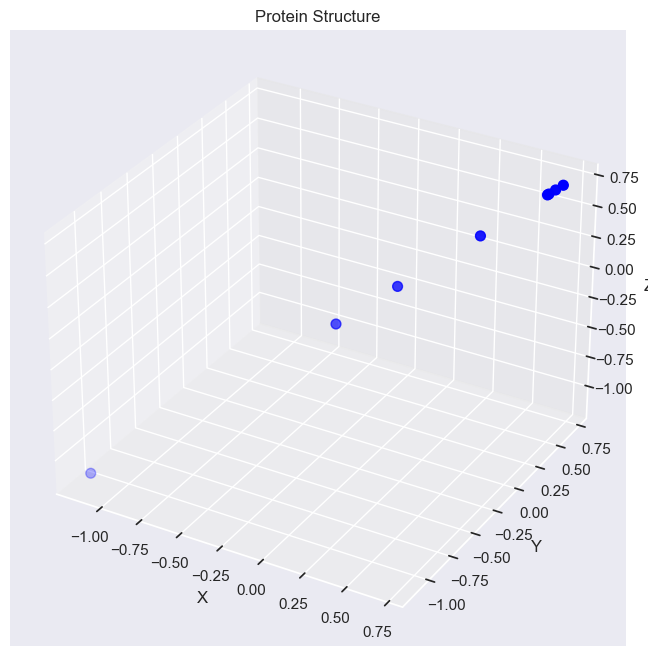


Node Feature Statistics:
Number of nodes: 1

Mass:
Mean: 0.220
Std: 0.640
Min: -1.146
Max: 0.700

Avg Neighbor Dist:
Mean: [[0.6391332149505615, 0.6442821621894836, 0.6704401969909668, 0.7005870342254639, 0.05515870451927185, 0.37707749009132385, -0.18509043753147125, -1.1448769569396973], [0.6391159296035767, 0.6443852186203003, 0.6703957319259644, 0.7006259560585022, 0.055464863777160645, 0.37849050760269165, -0.18514704704284668, -1.1439679861068726]]
Std: [[nan, nan, nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan, nan]]

Max Neighbor Dist:
Mean: 0.220
Std: 0.640
Min: -1.144
Max: 0.701

Neighbor Count:
Mean: 0.220
Std: 0.640
Min: -1.146
Max: 0.700

Small Molecules:
Mean: 0.219
Std: 0.640
Min: -1.145
Max: 0.700

Coordinate Statistics:
Center of mass: [[0.6391021013259888, 0.6443927884101868, 0.6706143021583557, 0.7003419399261475, 0.05524856597185135, 0.38362693786621094, -0.1817743331193924, -1.14357590675354], [0.6391353607177734, 0.6443061828613281, 0.670473158

In [114]:
# Assuming you have a trained model
model = model.to(device)

# Generate and visualize a protein
node_features, edge_index, edge_attr = generate_and_visualize_protein(
    model,
    n_nodes=500,  # Adjust this number as needed
    device=device
)
print_node_statistics(node_features)

In [116]:
print_node_statistics(node_features)


Node Feature Statistics:
Number of nodes: 1

Mass:
Mean: 0.220
Std: 0.640
Min: -1.146
Max: 0.700

Avg Neighbor Dist:
Mean: [[0.6391332149505615, 0.6442821621894836, 0.6704401969909668, 0.7005870342254639, 0.05515870451927185, 0.37707749009132385, -0.18509043753147125, -1.1448769569396973], [0.6391159296035767, 0.6443852186203003, 0.6703957319259644, 0.7006259560585022, 0.055464863777160645, 0.37849050760269165, -0.18514704704284668, -1.1439679861068726]]
Std: [[nan, nan, nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan, nan]]

Max Neighbor Dist:
Mean: 0.220
Std: 0.640
Min: -1.144
Max: 0.701

Neighbor Count:
Mean: 0.220
Std: 0.640
Min: -1.146
Max: 0.700

Small Molecules:
Mean: 0.219
Std: 0.640
Min: -1.145
Max: 0.700

Coordinate Statistics:
Center of mass: [[0.6391021013259888, 0.6443927884101868, 0.6706143021583557, 0.7003419399261475, 0.05524856597185135, 0.38362693786621094, -0.1817743331193924, -1.14357590675354], [0.6391353607177734, 0.6443061828613281, 0.670473158

/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_91343/3658105207.py:87: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  std = values.std(dim=0)
/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_91343/3658105207.py:103: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  print(f"Spatial extent: {coords.std(dim=0).tolist()}")


/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Dataset prepared:
Number of training graphs: 1308
Number of test graphs: 328
Number of features per node: 8
Feature means: tensor([-2.2879e-09, -4.5757e-10,  3.4494e-09, -1.2249e-08,  1.7266e-09,
         5.6735e-09,  7.4301e-09,  3.4648e-09])
Feature stds: tensor([1., 1., 1., 1., 1., 1., 1., 1.])
Starting training for 10 epochs...
Training on device: cpu
Number of training batches: 82
Number of validation batches: 21
KL annealing: 1e-05 -> 0.005 over 25 epochs
Orthogonal regularization strength: 0.1


Epoch 1/10 [Train]:   0%|          | 0/82 [00:00<?, ?it/s]


Batch shapes:
Input x shape: torch.Size([13762, 8])
Edge index shape: torch.Size([2, 55048])
Edge attr shape: torch.Size([55048, 1])
Reconstruction shape: torch.Size([16, 1767, 8])
Edge reconstruction shape: torch.Size([55048, 1])

Detailed loss diagnostics:
Raw recon_loss: 35.7986
Raw KL loss: 0.2241
Ortho loss: 1.4247
Current beta: 0.0000
mu mean: -0.0150, std: 0.5338
logvar mean: -0.0293, std: 0.5578
mass: 1.1999
distance: 0.9569
count: 23.9376
small_mol: 0.0733
coord: 9.4820
edge: 0.1489


Epoch 1/10 [Train]:  12%|█▏        | 10/82 [00:22<02:44,  2.29s/it, loss=114.1962, recon=112.7624, kl=0.3352, ortho=1.4338]


Detailed loss diagnostics:
Raw recon_loss: 99.4824
Raw KL loss: 0.3144
Ortho loss: 1.4216
Current beta: 0.0000
mu mean: -0.0131, std: 0.6411
logvar mean: -0.0306, std: 0.6348
mass: 3.5348
distance: 2.7087
count: 74.2220
small_mol: 0.0742
coord: 18.8102
edge: 0.1324


Epoch 1/10 [Train]:  24%|██▍       | 20/82 [00:43<02:53,  2.80s/it, loss=135.2020, recon=133.7769, kl=0.3465, ortho=1.4251]


Detailed loss diagnostics:
Raw recon_loss: 82.3345
Raw KL loss: 0.3818
Ortho loss: 1.4306
Current beta: 0.0000
mu mean: -0.0129, std: 0.7457
logvar mean: -0.0321, std: 0.6104
mass: 3.1944
distance: 2.5240
count: 64.4887
small_mol: 0.0700
coord: 11.9314
edge: 0.1261


Epoch 1/10 [Train]:  37%|███▋      | 30/82 [00:58<01:25,  1.64s/it, loss=189.9705, recon=188.5502, kl=0.3987, ortho=1.4203]


Detailed loss diagnostics:
Raw recon_loss: 21.8137
Raw KL loss: 0.4265
Ortho loss: 1.4276
Current beta: 0.0000
mu mean: -0.0124, std: 0.7541
logvar mean: -0.0332, std: 0.6775
mass: 1.0277
distance: 0.6793
count: 18.5494
small_mol: 0.0695
coord: 1.3631
edge: 0.1246


Epoch 1/10 [Train]:  49%|████▉     | 40/82 [01:17<01:26,  2.07s/it, loss=63.0502, recon=61.6211, kl=0.4048, ortho=1.4291]  


Detailed loss diagnostics:
Raw recon_loss: 57.7530
Raw KL loss: 0.3773
Ortho loss: 1.4255
Current beta: 0.0000
mu mean: -0.0112, std: 0.7297
logvar mean: -0.0342, std: 0.6211
mass: 2.6306
distance: 2.0333
count: 49.5674
small_mol: 0.0682
coord: 3.3314
edge: 0.1222


Epoch 1/10 [Train]:  61%|██████    | 50/82 [01:33<00:49,  1.54s/it, loss=56.8906, recon=55.4645, kl=0.4460, ortho=1.4260]


Detailed loss diagnostics:
Raw recon_loss: 58.0422
Raw KL loss: 0.4745
Ortho loss: 1.4339
Current beta: 0.0000
mu mean: -0.0098, std: 0.7946
logvar mean: -0.0355, std: 0.7101
mass: 2.8319
distance: 2.1450
count: 50.4049
small_mol: 0.0642
coord: 2.4753
edge: 0.1210


Epoch 1/10 [Train]:  73%|███████▎  | 60/82 [01:55<00:47,  2.14s/it, loss=82.6457, recon=81.2098, kl=0.5165, ortho=1.4359]


Detailed loss diagnostics:
Raw recon_loss: 21.6447
Raw KL loss: 0.5153
Ortho loss: 1.4342
Current beta: 0.0000
mu mean: -0.0088, std: 0.8326
logvar mean: -0.0364, std: 0.7250
mass: 1.0176
distance: 0.8483
count: 18.9423
small_mol: 0.0575
coord: 0.6619
edge: 0.1171


Epoch 1/10 [Train]:  85%|████████▌ | 70/82 [02:13<00:24,  2.00s/it, loss=71.0588, recon=69.6224, kl=0.5526, ortho=1.4364]  


Detailed loss diagnostics:
Raw recon_loss: 14.0266
Raw KL loss: 0.5482
Ortho loss: 1.4296
Current beta: 0.0000
mu mean: -0.0078, std: 0.8961
logvar mean: -0.0379, std: 0.7052
mass: 0.7807
distance: 0.5938
count: 12.0902
small_mol: 0.0561
coord: 0.3896
edge: 0.1162


Epoch 1/10 [Train]:  98%|█████████▊| 80/82 [02:35<00:03,  1.93s/it, loss=31.3411, recon=29.9094, kl=0.5314, ortho=1.4316]  


Detailed loss diagnostics:
Raw recon_loss: 48.9504
Raw KL loss: 0.5493
Ortho loss: 1.4305
Current beta: 0.0000
mu mean: -0.0069, std: 0.8973
logvar mean: -0.0394, std: 0.7110
mass: 2.6349
distance: 1.7812
count: 43.7289
small_mol: 0.0584
coord: 0.6346
edge: 0.1123


Epoch 1/10 [Train]: 100%|██████████| 82/82 [02:40<00:00,  1.96s/it, loss=74.3418, recon=72.9042, kl=0.5442, ortho=1.4376]



Starting validation...


Epoch 1/10 [Valid]: 100%|██████████| 21/21 [00:12<00:00,  1.70it/s]



Epoch [1/10] - Time: 172.84s
Train - Total: 61.0333, Recon: 59.6049, KL: 0.4227, Ortho: 1.4284, Beta: 0.0000
Feature Losses:
  mass_loss: 2.7578
  distance_loss: 2.0494
  count_loss: 48.8345
  small_mol_loss: 0.0666
  coord_loss: 5.7714
  edge_loss: 0.1252


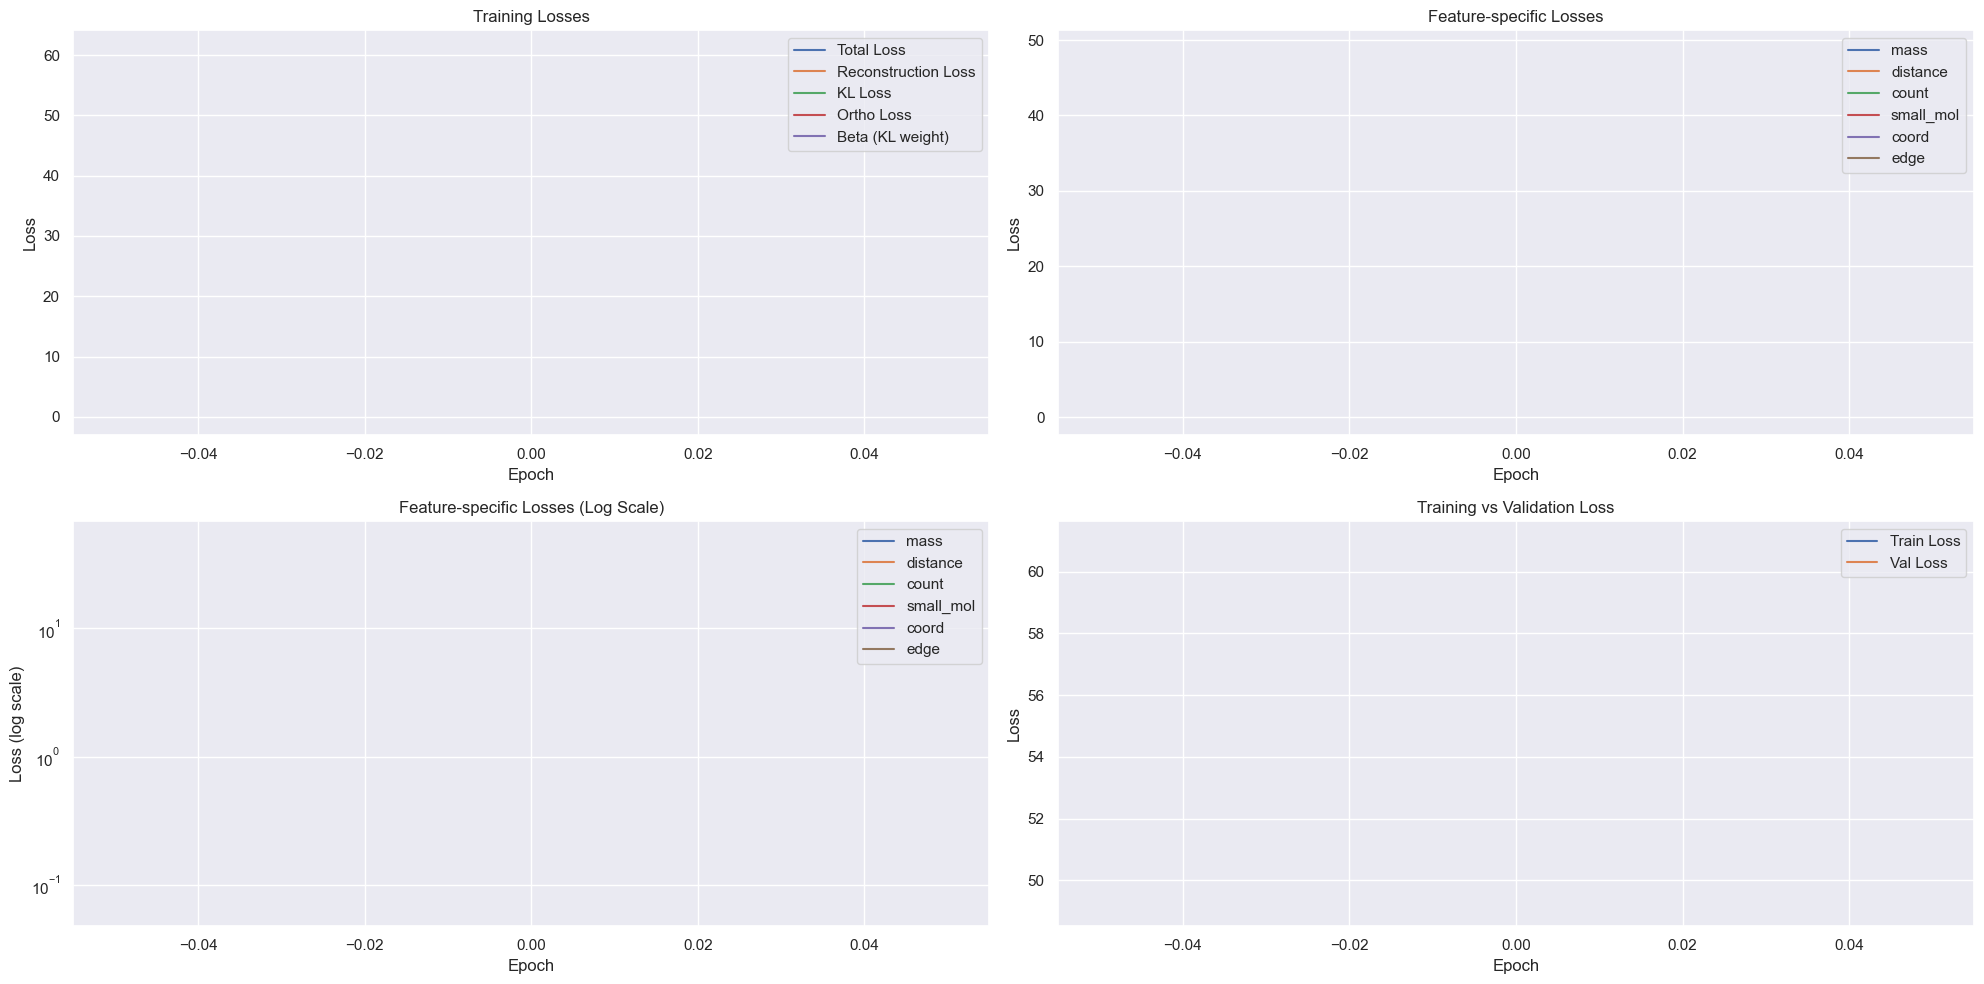

Epoch 2/10 [Train]:   0%|          | 0/82 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 49.5317
Raw KL loss: 0.5261
Ortho loss: 1.4296
Current beta: 0.0002
mu mean: -0.0067, std: 0.8903
logvar mean: -0.0396, std: 0.6844
mass: 2.5339
distance: 1.8742
count: 44.3958
small_mol: 0.0559
coord: 0.5596
edge: 0.1124


Epoch 2/10 [Train]:  12%|█▏        | 10/82 [00:22<03:33,  2.96s/it, loss=155.6846, recon=154.2373, kl=0.6162, ortho=1.4472]


Detailed loss diagnostics:
Raw recon_loss: 3.3168
Raw KL loss: 0.5903
Ortho loss: 1.4356
Current beta: 0.0002
mu mean: -0.0064, std: 0.9530
logvar mean: -0.0413, std: 0.6659
mass: 1.1668
distance: 0.7389
count: 0.7215
small_mol: 0.0559
coord: 0.5165
edge: 0.1171


Epoch 2/10 [Train]:  24%|██▍       | 20/82 [00:42<02:26,  2.36s/it, loss=36.4817, recon=35.0467, kl=0.5747, ortho=1.4349]  


Detailed loss diagnostics:
Raw recon_loss: 91.3419
Raw KL loss: 0.5446
Ortho loss: 1.4290
Current beta: 0.0002
mu mean: -0.0060, std: 0.9172
logvar mean: -0.0425, std: 0.6712
mass: 5.0622
distance: 3.2675
count: 81.6542
small_mol: 0.0524
coord: 1.1958
edge: 0.1097


Epoch 2/10 [Train]:  37%|███▋      | 30/82 [01:01<01:18,  1.52s/it, loss=12.3451, recon=10.9145, kl=0.5673, ortho=1.4304]


Detailed loss diagnostics:
Raw recon_loss: 28.6425
Raw KL loss: 0.6218
Ortho loss: 1.4318
Current beta: 0.0002
mu mean: -0.0055, std: 0.9908
logvar mean: -0.0439, std: 0.6697
mass: 1.7061
distance: 1.2307
count: 24.7745
small_mol: 0.0516
coord: 0.7705
edge: 0.1091


Epoch 2/10 [Train]:  49%|████▉     | 40/82 [01:24<01:22,  1.96s/it, loss=81.4418, recon=80.0083, kl=0.5707, ortho=1.4334]


Detailed loss diagnostics:
Raw recon_loss: 17.4616
Raw KL loss: 0.6278
Ortho loss: 1.4379
Current beta: 0.0002
mu mean: -0.0052, std: 1.0007
logvar mean: -0.0449, std: 0.6645
mass: 1.1066
distance: 0.7367
count: 15.1250
small_mol: 0.0427
coord: 0.3448
edge: 0.1058


Epoch 2/10 [Train]:  61%|██████    | 50/82 [01:43<00:52,  1.65s/it, loss=30.8404, recon=29.4063, kl=0.6184, ortho=1.4339]  


Detailed loss diagnostics:
Raw recon_loss: 14.5664
Raw KL loss: 0.6387
Ortho loss: 1.4339
Current beta: 0.0002
mu mean: -0.0050, std: 1.0140
logvar mean: -0.0458, std: 0.6673
mass: 0.8832
distance: 0.6327
count: 12.5942
small_mol: 0.0502
coord: 0.3023
edge: 0.1038


Epoch 2/10 [Train]:  73%|███████▎  | 60/82 [02:04<00:52,  2.37s/it, loss=103.4894, recon=102.0538, kl=0.5961, ortho=1.4355]


Detailed loss diagnostics:
Raw recon_loss: 5.8081
Raw KL loss: 0.6328
Ortho loss: 1.4337
Current beta: 0.0002
mu mean: -0.0048, std: 1.0012
logvar mean: -0.0469, std: 0.6792
mass: 1.5198
distance: 1.0374
count: 2.7155
small_mol: 0.0395
coord: 0.3847
edge: 0.1113


Epoch 2/10 [Train]:  85%|████████▌ | 70/82 [02:25<00:24,  2.00s/it, loss=41.9477, recon=40.5142, kl=0.6443, ortho=1.4334]  


Detailed loss diagnostics:
Raw recon_loss: 40.5071
Raw KL loss: 0.6696
Ortho loss: 1.4334
Current beta: 0.0002
mu mean: -0.0046, std: 1.0384
logvar mean: -0.0482, std: 0.6820
mass: 2.3097
distance: 1.6525
count: 36.1020
small_mol: 0.0306
coord: 0.3078
edge: 0.1045


Epoch 2/10 [Train]:  98%|█████████▊| 80/82 [02:42<00:03,  1.67s/it, loss=64.9273, recon=63.4912, kl=0.6414, ortho=1.4359]


Detailed loss diagnostics:
Raw recon_loss: 3.3947
Raw KL loss: 0.6442
Ortho loss: 1.4308
Current beta: 0.0002
mu mean: -0.0045, std: 1.0353
logvar mean: -0.0494, std: 0.6403
mass: 1.1892
distance: 0.8329
count: 0.9917
small_mol: 0.0341
coord: 0.2330
edge: 0.1139


Epoch 2/10 [Train]: 100%|██████████| 82/82 [02:46<00:00,  2.03s/it, loss=42.5625, recon=41.1246, kl=0.7151, ortho=1.4378]



Starting validation...


Epoch 2/10 [Valid]: 100%|██████████| 21/21 [00:12<00:00,  1.64it/s]



Epoch [2/10] - Time: 179.08s
Train - Total: 38.3243, Recon: 36.8906, KL: 0.6010, Ortho: 1.4337, Beta: 0.0002
Feature Losses:
  mass_loss: 2.1612
  distance_loss: 1.4992
  count_loss: 32.5005
  small_mol_loss: 0.0444
  coord_loss: 0.5774
  edge_loss: 0.1078


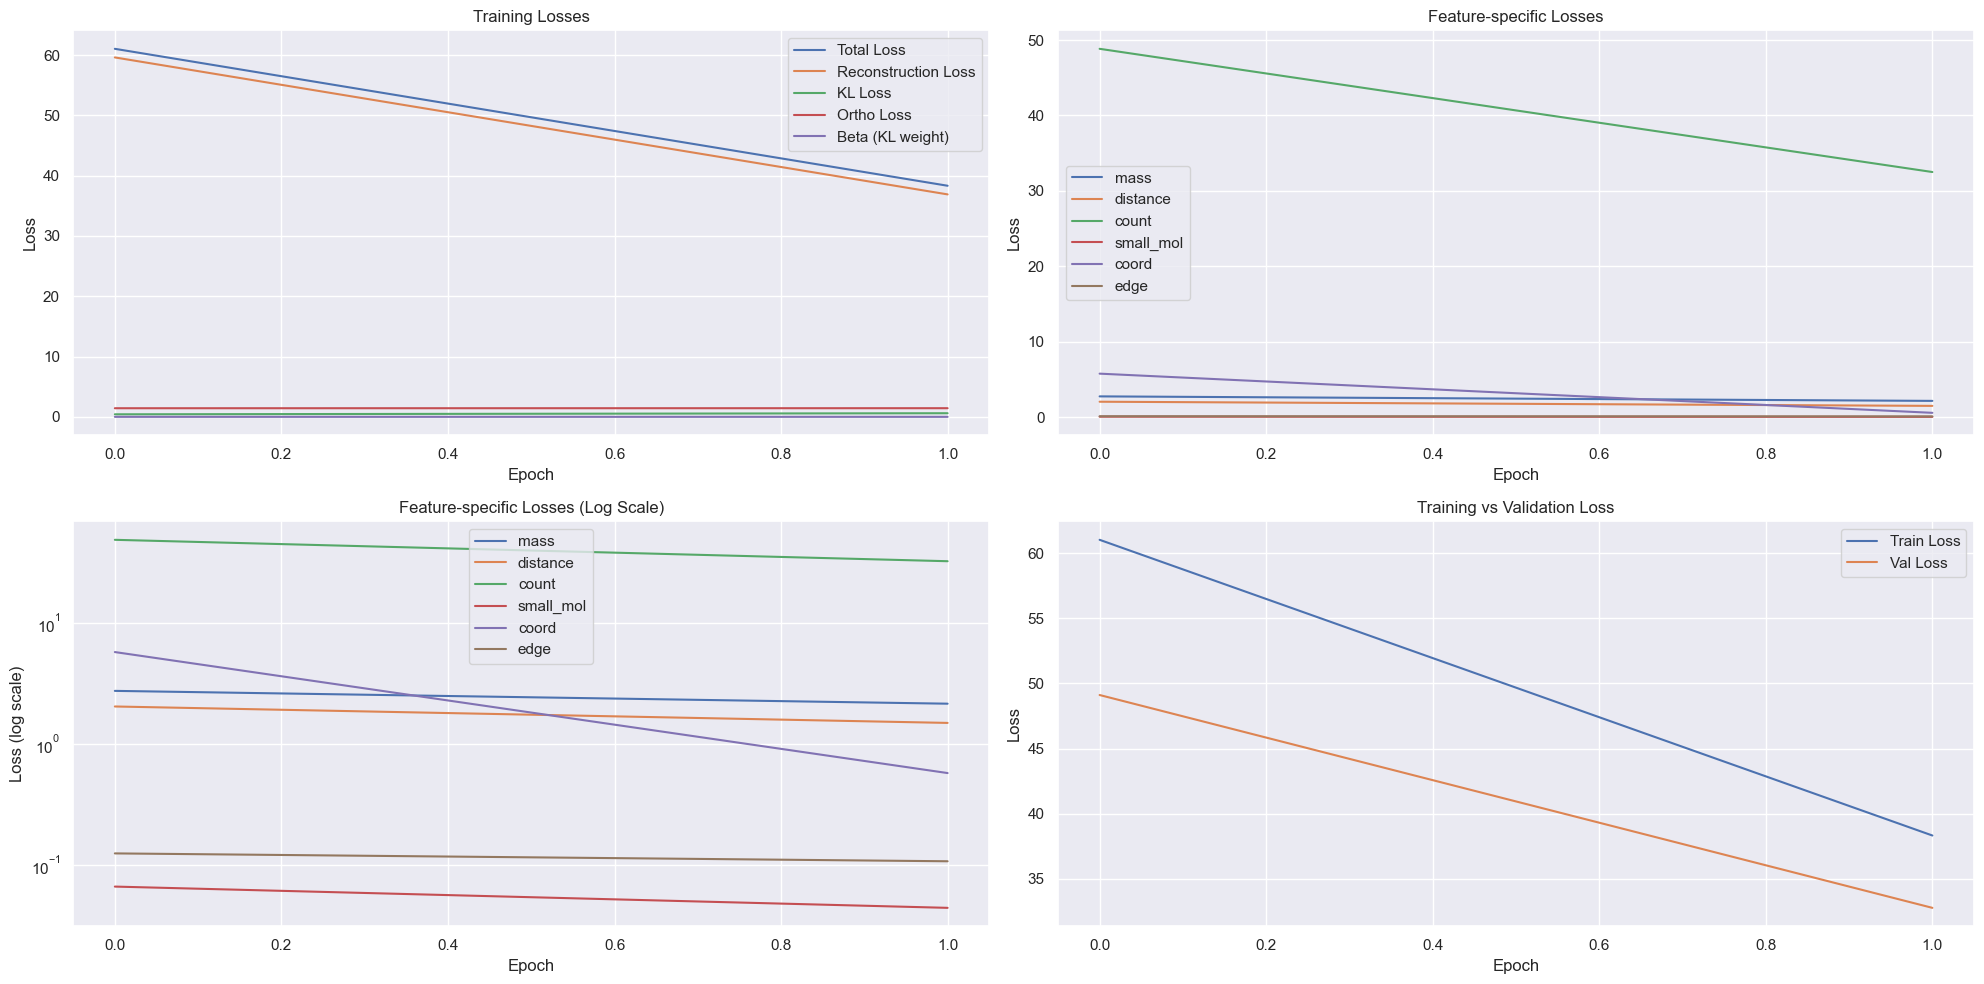

Epoch 3/10 [Train]:   0%|          | 0/82 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 7.2782
Raw KL loss: 0.6701
Ortho loss: 1.4319
Current beta: 0.0004
mu mean: -0.0044, std: 1.0526
logvar mean: -0.0497, std: 0.6355
mass: 0.5306
distance: 0.4033
count: 6.0481
small_mol: 0.0528
coord: 0.1407
edge: 0.1027


Epoch 3/10 [Train]:  12%|█▏        | 10/82 [00:21<02:44,  2.29s/it, loss=11.8987, recon=10.4706, kl=0.6323, ortho=1.4278]


Detailed loss diagnostics:
Raw recon_loss: 5.3255
Raw KL loss: 0.6896
Ortho loss: 1.4344
Current beta: 0.0004
mu mean: -0.0038, std: 1.0630
logvar mean: -0.0507, std: 0.6427
mass: 1.5429
distance: 1.1159
count: 2.0027
small_mol: 0.0292
coord: 0.5246
edge: 0.1102


Epoch 3/10 [Train]:  24%|██▍       | 20/82 [00:42<02:12,  2.13s/it, loss=5.5713, recon=4.1438, kl=0.6013, ortho=1.4272]  


Detailed loss diagnostics:
Raw recon_loss: 44.6775
Raw KL loss: 0.6358
Ortho loss: 1.4292
Current beta: 0.0004
mu mean: -0.0036, std: 1.0314
logvar mean: -0.0516, std: 0.6236
mass: 2.8420
distance: 1.9145
count: 39.2431
small_mol: 0.0295
coord: 0.5445
edge: 0.1039


Epoch 3/10 [Train]:  37%|███▋      | 30/82 [01:04<01:58,  2.28s/it, loss=4.4716, recon=3.0430, kl=0.5650, ortho=1.4284]    


Detailed loss diagnostics:
Raw recon_loss: 32.4338
Raw KL loss: 0.6677
Ortho loss: 1.4261
Current beta: 0.0004
mu mean: -0.0036, std: 1.0523
logvar mean: -0.0522, std: 0.6508
mass: 1.9478
distance: 1.4983
count: 28.4103
small_mol: 0.0285
coord: 0.4454
edge: 0.1034


Epoch 3/10 [Train]:  49%|████▉     | 40/82 [01:25<01:45,  2.52s/it, loss=31.5674, recon=30.1374, kl=0.6308, ortho=1.4298]


Detailed loss diagnostics:
Raw recon_loss: 34.0279
Raw KL loss: 0.6738
Ortho loss: 1.4290
Current beta: 0.0004
mu mean: -0.0037, std: 1.0648
logvar mean: -0.0523, std: 0.6118
mass: 1.9209
distance: 1.4520
count: 30.0707
small_mol: 0.0203
coord: 0.4582
edge: 0.1059


Epoch 3/10 [Train]:  61%|██████    | 50/82 [01:44<00:50,  1.59s/it, loss=26.6021, recon=25.1739, kl=0.6247, ortho=1.4280]


Detailed loss diagnostics:
Raw recon_loss: 9.4966
Raw KL loss: 0.6925
Ortho loss: 1.4329
Current beta: 0.0004
mu mean: -0.0036, std: 1.0747
logvar mean: -0.0531, std: 0.6084
mass: 0.6088
distance: 0.4718
count: 8.0697
small_mol: 0.0300
coord: 0.2137
edge: 0.1026


Epoch 3/10 [Train]:  73%|███████▎  | 60/82 [01:59<00:37,  1.72s/it, loss=38.9837, recon=37.5580, kl=0.6310, ortho=1.4254]


Detailed loss diagnostics:
Raw recon_loss: 20.9915
Raw KL loss: 0.6624
Ortho loss: 1.4299
Current beta: 0.0004
mu mean: -0.0036, std: 1.0483
logvar mean: -0.0544, std: 0.6019
mass: 1.2669
distance: 0.9378
count: 18.2660
small_mol: 0.0260
coord: 0.3928
edge: 0.1020


Epoch 3/10 [Train]:  85%|████████▌ | 70/82 [02:17<00:19,  1.64s/it, loss=25.4758, recon=24.0492, kl=0.6440, ortho=1.4264]


Detailed loss diagnostics:
Raw recon_loss: 18.5813
Raw KL loss: 0.6291
Ortho loss: 1.4264
Current beta: 0.0004
mu mean: -0.0037, std: 1.0562
logvar mean: -0.0558, std: 0.5429
mass: 1.2426
distance: 0.8984
count: 16.0888
small_mol: 0.0179
coord: 0.2312
edge: 0.1024


Epoch 3/10 [Train]:  98%|█████████▊| 80/82 [02:38<00:04,  2.00s/it, loss=27.3172, recon=25.8945, kl=0.5937, ortho=1.4225]


Detailed loss diagnostics:
Raw recon_loss: 5.0471
Raw KL loss: 0.5882
Ortho loss: 1.4245
Current beta: 0.0004
mu mean: -0.0036, std: 1.0067
logvar mean: -0.0570, std: 0.5434
mass: 1.4952
distance: 1.0564
count: 2.0444
small_mol: 0.0178
coord: 0.3269
edge: 0.1064


Epoch 3/10 [Train]: 100%|██████████| 82/82 [02:41<00:00,  1.96s/it, loss=12.6656, recon=11.2417, kl=0.6108, ortho=1.4237]



Starting validation...


Epoch 3/10 [Valid]: 100%|██████████| 21/21 [00:11<00:00,  1.77it/s]



Epoch [3/10] - Time: 172.93s
Train - Total: 29.9562, Recon: 28.5270, KL: 0.6417, Ortho: 1.4289, Beta: 0.0004
Feature Losses:
  mass_loss: 1.7270
  distance_loss: 1.2495
  count_loss: 24.9620
  small_mol_loss: 0.0290
  coord_loss: 0.4556
  edge_loss: 0.1039


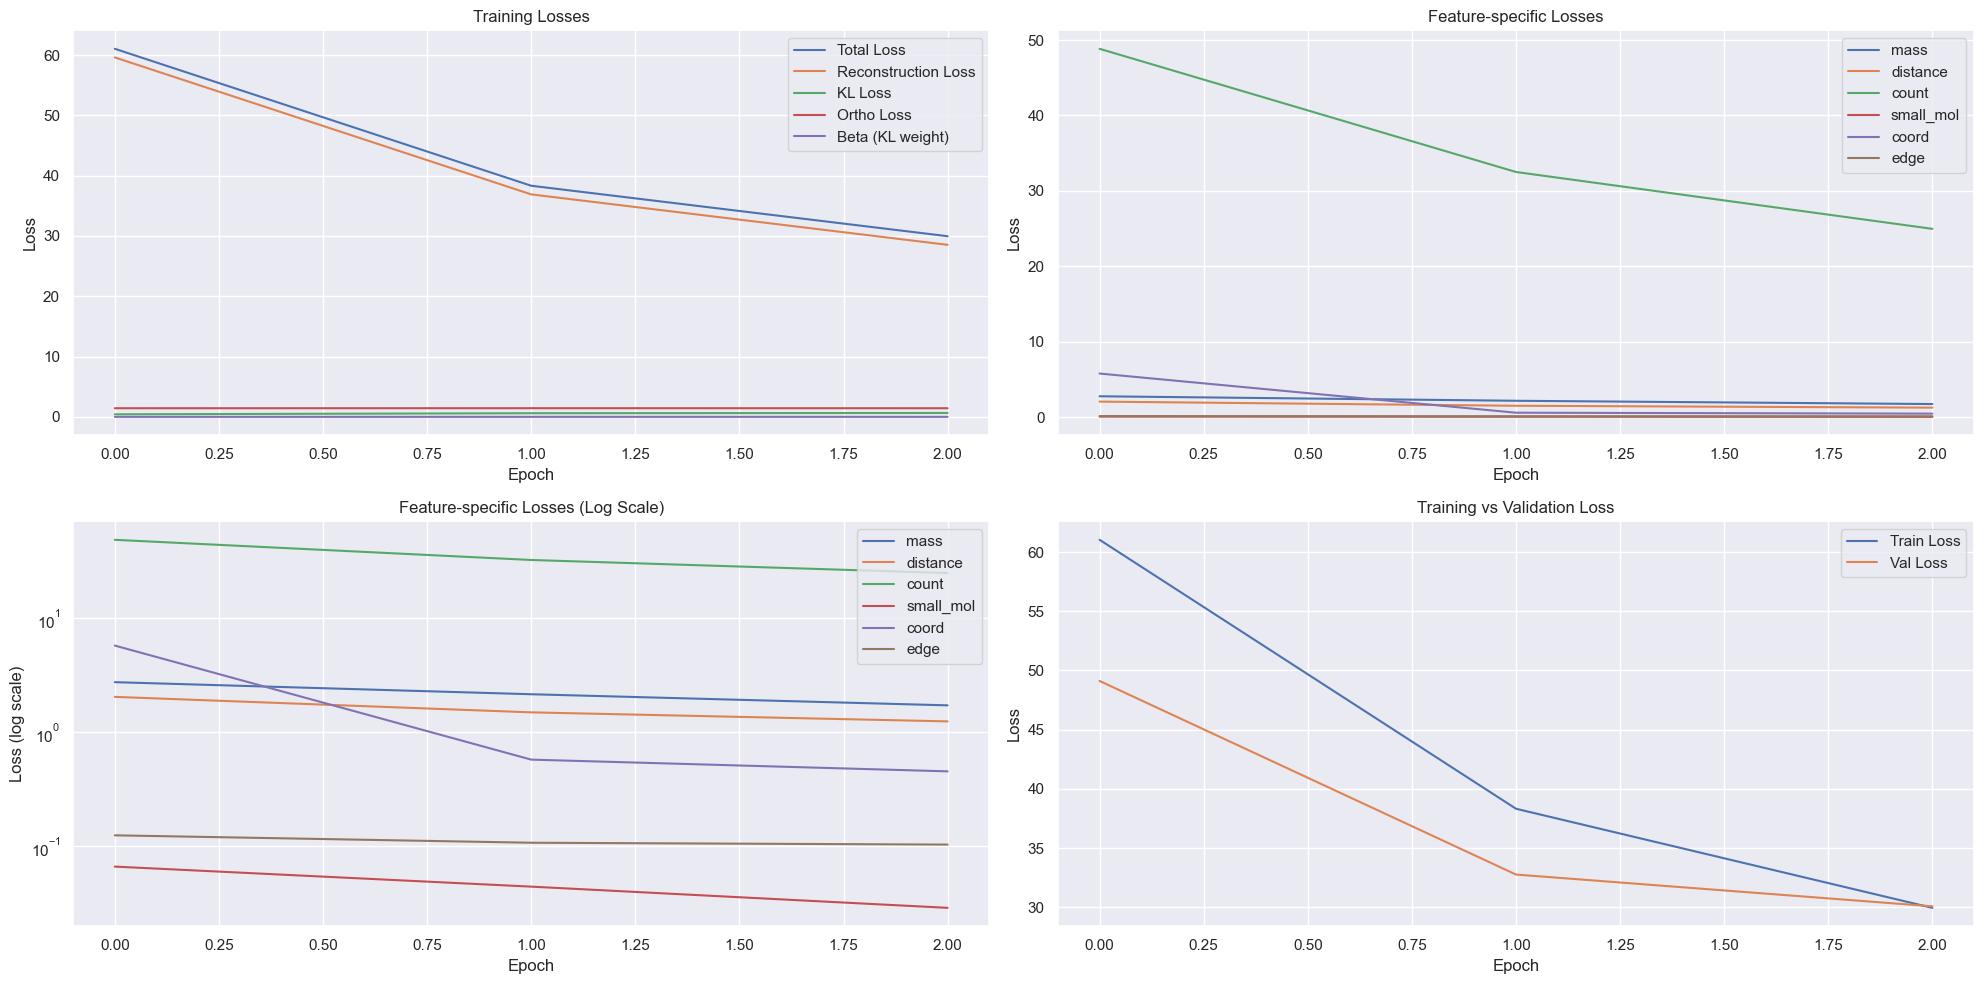

Epoch 4/10 [Train]:   0%|          | 0/82 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 38.0797
Raw KL loss: 0.5980
Ortho loss: 1.4260
Current beta: 0.0006
mu mean: -0.0036, std: 1.0116
logvar mean: -0.0572, std: 0.5636
mass: 2.1063
distance: 1.5271
count: 33.9300
small_mol: 0.0176
coord: 0.3952
edge: 0.1035


Epoch 4/10 [Train]:  12%|█▏        | 10/82 [00:18<01:58,  1.64s/it, loss=14.3364, recon=12.9101, kl=0.5726, ortho=1.4259]


Detailed loss diagnostics:
Raw recon_loss: 20.4020
Raw KL loss: 0.6212
Ortho loss: 1.4246
Current beta: 0.0006
mu mean: -0.0034, std: 1.0242
logvar mean: -0.0585, std: 0.5850
mass: 1.2781
distance: 0.8894
count: 17.7987
small_mol: 0.0230
coord: 0.3107
edge: 0.1020


Epoch 4/10 [Train]:  24%|██▍       | 20/82 [00:37<02:01,  1.96s/it, loss=30.9799, recon=29.5579, kl=0.6049, ortho=1.4217]


Detailed loss diagnostics:
Raw recon_loss: 9.0579
Raw KL loss: 0.5710
Ortho loss: 1.4270
Current beta: 0.0006
mu mean: -0.0030, std: 0.9927
logvar mean: -0.0594, std: 0.5371
mass: 0.6033
distance: 0.4466
count: 7.6599
small_mol: 0.0212
coord: 0.2217
edge: 0.1052


Epoch 4/10 [Train]:  37%|███▋      | 30/82 [00:56<02:14,  2.58s/it, loss=55.8970, recon=54.4688, kl=0.5780, ortho=1.4279]


Detailed loss diagnostics:
Raw recon_loss: 18.2949
Raw KL loss: 0.6567
Ortho loss: 1.4251
Current beta: 0.0006
mu mean: -0.0027, std: 1.0596
logvar mean: -0.0610, std: 0.5822
mass: 1.0548
distance: 0.8138
count: 15.9846
small_mol: 0.0199
coord: 0.3164
edge: 0.1054


Epoch 4/10 [Train]:  49%|████▉     | 40/82 [01:16<01:23,  1.98s/it, loss=18.7235, recon=17.3020, kl=0.6404, ortho=1.4211]  


Detailed loss diagnostics:
Raw recon_loss: 13.7304
Raw KL loss: 0.6082
Ortho loss: 1.4258
Current beta: 0.0006
mu mean: -0.0028, std: 1.0233
logvar mean: -0.0631, std: 0.5614
mass: 0.8908
distance: 0.6939
count: 11.7198
small_mol: 0.0242
coord: 0.2982
edge: 0.1035


Epoch 4/10 [Train]:  61%|██████    | 50/82 [01:39<01:17,  2.43s/it, loss=23.6905, recon=22.2658, kl=0.6289, ortho=1.4243]


Detailed loss diagnostics:
Raw recon_loss: 67.0966
Raw KL loss: 0.6434
Ortho loss: 1.4227
Current beta: 0.0006
mu mean: -0.0025, std: 1.0557
logvar mean: -0.0649, std: 0.5522
mass: 3.4780
distance: 2.5943
count: 60.2017
small_mol: 0.0196
coord: 0.6977
edge: 0.1055


Epoch 4/10 [Train]:  73%|███████▎  | 60/82 [01:57<00:39,  1.81s/it, loss=32.5167, recon=31.0923, kl=0.6363, ortho=1.4241]


Detailed loss diagnostics:
Raw recon_loss: 8.7722
Raw KL loss: 0.6511
Ortho loss: 1.4238
Current beta: 0.0006
mu mean: -0.0023, std: 1.0617
logvar mean: -0.0660, std: 0.5696
mass: 0.6160
distance: 0.4396
count: 7.3842
small_mol: 0.0551
coord: 0.1745
edge: 0.1029


Epoch 4/10 [Train]:  85%|████████▌ | 70/82 [02:20<00:24,  2.04s/it, loss=24.7820, recon=23.3573, kl=0.6219, ortho=1.4243]


Detailed loss diagnostics:
Raw recon_loss: 20.3438
Raw KL loss: 0.6859
Ortho loss: 1.4240
Current beta: 0.0006
mu mean: -0.0026, std: 1.0913
logvar mean: -0.0671, std: 0.5818
mass: 1.2255
distance: 0.8936
count: 17.8527
small_mol: 0.0226
coord: 0.2457
edge: 0.1037


Epoch 4/10 [Train]:  98%|█████████▊| 80/82 [02:39<00:03,  1.77s/it, loss=32.7007, recon=31.2744, kl=0.6263, ortho=1.4259]  


Detailed loss diagnostics:
Raw recon_loss: 51.0054
Raw KL loss: 0.6290
Ortho loss: 1.4252
Current beta: 0.0006
mu mean: -0.0023, std: 1.0624
logvar mean: -0.0682, std: 0.5062
mass: 2.8183
distance: 2.0652
count: 45.3353
small_mol: 0.0208
coord: 0.6602
edge: 0.1056


Epoch 4/10 [Train]: 100%|██████████| 82/82 [02:42<00:00,  1.98s/it, loss=12.4127, recon=10.9888, kl=0.6367, ortho=1.4235]



Starting validation...


Epoch 4/10 [Valid]: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]



Epoch [4/10] - Time: 173.99s
Train - Total: 28.2661, Recon: 26.8400, KL: 0.6233, Ortho: 1.4258, Beta: 0.0006
Feature Losses:
  mass_loss: 1.6291
  distance_loss: 1.2188
  count_loss: 23.4604
  small_mol_loss: 0.0260
  coord_loss: 0.4020
  edge_loss: 0.1037


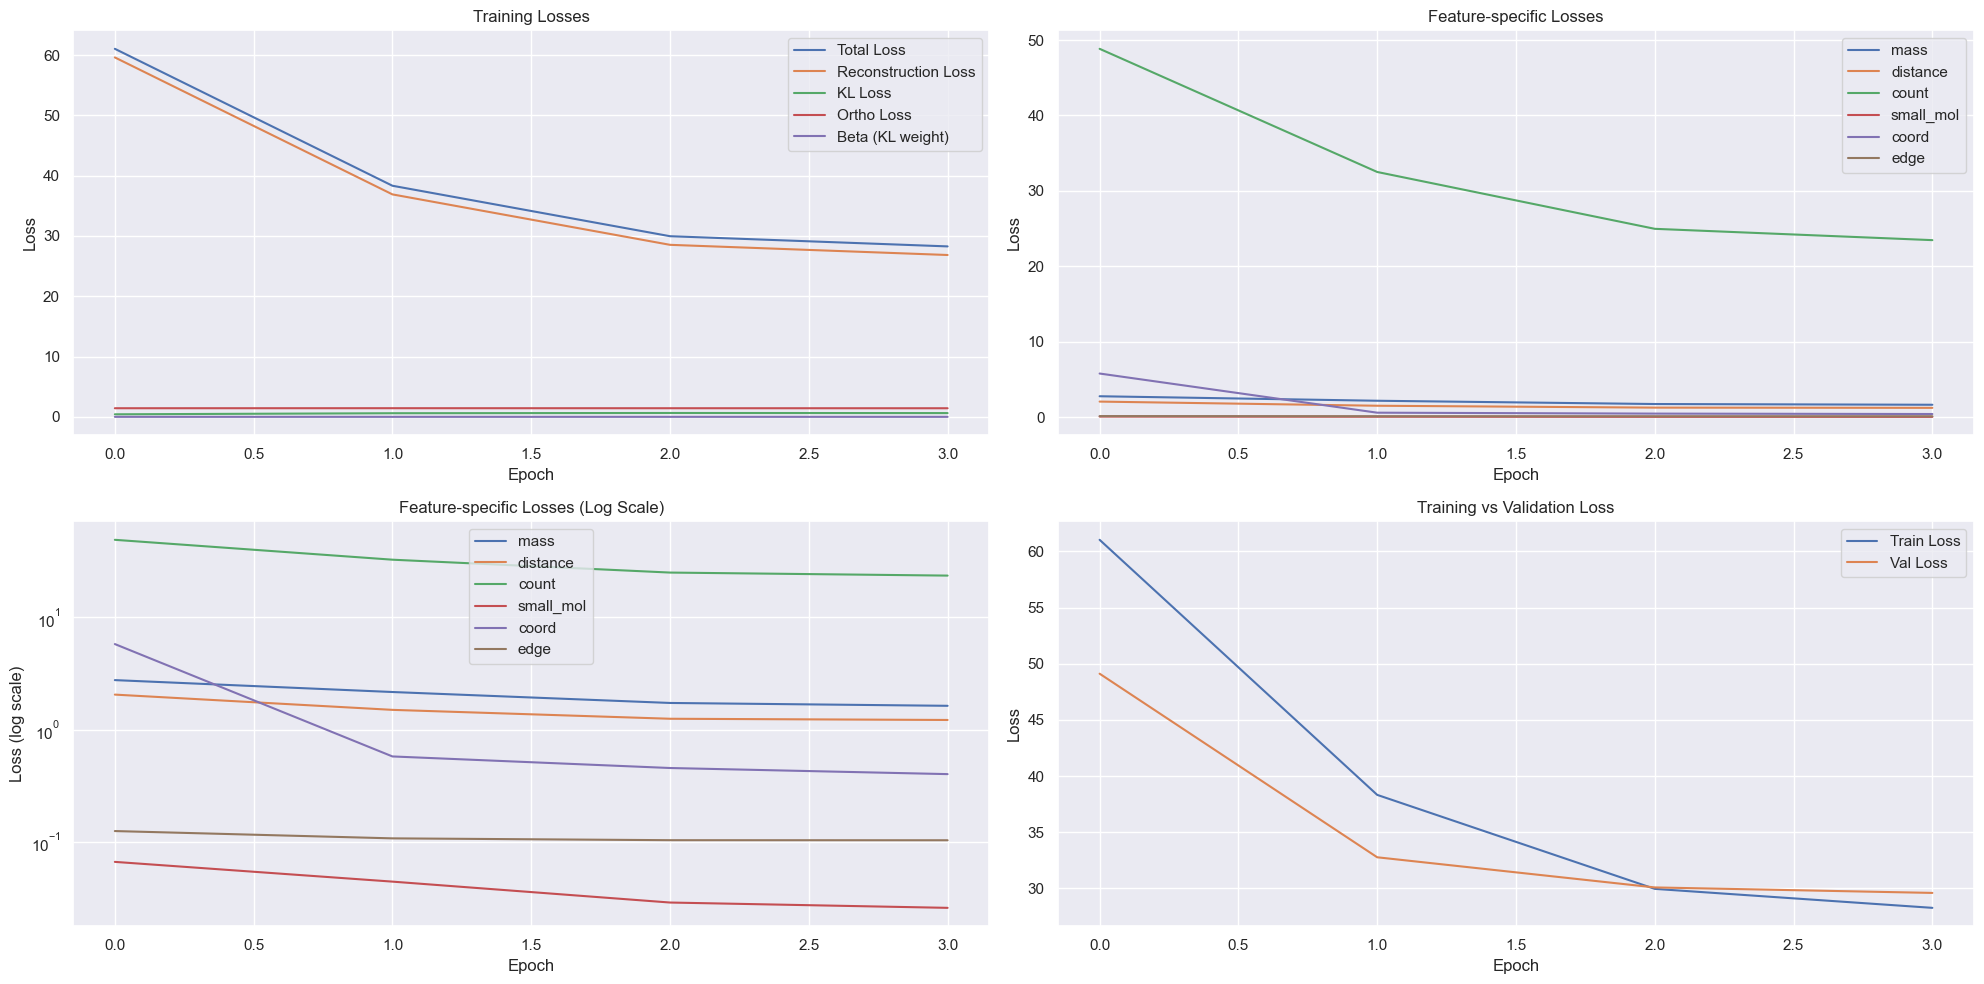

Epoch 5/10 [Train]:   0%|          | 0/82 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 21.2543
Raw KL loss: 0.6544
Ortho loss: 1.4230
Current beta: 0.0008
mu mean: -0.0022, std: 1.0875
logvar mean: -0.0685, std: 0.5038
mass: 1.3479
distance: 0.9398
count: 18.5820
small_mol: 0.0240
coord: 0.2596
edge: 0.1009


Epoch 5/10 [Train]:  12%|█▏        | 10/82 [00:17<01:43,  1.44s/it, loss=23.0934, recon=21.6693, kl=0.6309, ortho=1.4235]


Detailed loss diagnostics:
Raw recon_loss: 42.3095
Raw KL loss: 0.6933
Ortho loss: 1.4324
Current beta: 0.0008
mu mean: -0.0025, std: 1.1044
logvar mean: -0.0696, std: 0.5550
mass: 2.4209
distance: 1.7948
count: 37.3723
small_mol: 0.0255
coord: 0.5942
edge: 0.1018


Epoch 5/10 [Train]:  24%|██▍       | 20/82 [00:34<01:23,  1.35s/it, loss=15.9192, recon=14.4955, kl=0.6105, ortho=1.4232]


Detailed loss diagnostics:
Raw recon_loss: 26.4480
Raw KL loss: 0.6365
Ortho loss: 1.4224
Current beta: 0.0008
mu mean: -0.0027, std: 1.0637
logvar mean: -0.0701, std: 0.5252
mass: 1.5112
distance: 1.1831
count: 23.1226
small_mol: 0.0173
coord: 0.5114
edge: 0.1023


Epoch 5/10 [Train]:  37%|███▋      | 30/82 [00:56<01:42,  1.98s/it, loss=17.9713, recon=16.5410, kl=0.6797, ortho=1.4297]  


Detailed loss diagnostics:
Raw recon_loss: 34.3458
Raw KL loss: 0.6081
Ortho loss: 1.4205
Current beta: 0.0008
mu mean: -0.0028, std: 1.0286
logvar mean: -0.0711, std: 0.5593
mass: 1.9614
distance: 1.4592
count: 30.2061
small_mol: 0.0176
coord: 0.5994
edge: 0.1021


Epoch 5/10 [Train]:  49%|████▉     | 40/82 [01:14<01:16,  1.82s/it, loss=32.2214, recon=30.7992, kl=0.6558, ortho=1.4217]


Detailed loss diagnostics:
Raw recon_loss: 19.5658
Raw KL loss: 0.6576
Ortho loss: 1.4207
Current beta: 0.0008
mu mean: -0.0031, std: 1.0708
logvar mean: -0.0723, std: 0.5791
mass: 1.2059
distance: 0.8731
count: 17.0877
small_mol: 0.0192
coord: 0.2774
edge: 0.1026


Epoch 5/10 [Train]:  61%|██████    | 50/82 [01:34<00:58,  1.83s/it, loss=10.3325, recon=8.9111, kl=0.6725, ortho=1.4208] 


Detailed loss diagnostics:
Raw recon_loss: 31.6265
Raw KL loss: 0.6685
Ortho loss: 1.4261
Current beta: 0.0008
mu mean: -0.0030, std: 1.0791
logvar mean: -0.0734, std: 0.5700
mass: 1.6815
distance: 1.3584
count: 27.8244
small_mol: 0.0188
coord: 0.6399
edge: 0.1036


Epoch 5/10 [Train]:  73%|███████▎  | 60/82 [01:52<00:46,  2.12s/it, loss=31.1306, recon=29.7074, kl=0.6089, ortho=1.4228]


Detailed loss diagnostics:
Raw recon_loss: 7.5118
Raw KL loss: 0.6887
Ortho loss: 1.4226
Current beta: 0.0008
mu mean: -0.0030, std: 1.1086
logvar mean: -0.0748, std: 0.5353
mass: 0.5152
distance: 0.4117
count: 6.2916
small_mol: 0.0462
coord: 0.1442
edge: 0.1029


Epoch 5/10 [Train]:  85%|████████▌ | 70/82 [02:14<00:28,  2.38s/it, loss=36.0369, recon=34.6095, kl=0.6943, ortho=1.4268]


Detailed loss diagnostics:
Raw recon_loss: 27.6938
Raw KL loss: 0.6639
Ortho loss: 1.4263
Current beta: 0.0008
mu mean: -0.0033, std: 1.0896
logvar mean: -0.0760, std: 0.5144
mass: 1.5553
distance: 1.2514
count: 24.4177
small_mol: 0.0223
coord: 0.3436
edge: 0.1035


Epoch 5/10 [Train]:  98%|█████████▊| 80/82 [02:40<00:05,  2.89s/it, loss=20.7630, recon=19.3327, kl=0.6975, ortho=1.4297]


Detailed loss diagnostics:
Raw recon_loss: 15.8162
Raw KL loss: 0.6443
Ortho loss: 1.4226
Current beta: 0.0008
mu mean: -0.0036, std: 1.0728
logvar mean: -0.0770, std: 0.5217
mass: 0.9380
distance: 0.6892
count: 13.7602
small_mol: 0.0338
coord: 0.2913
edge: 0.1037


Epoch 5/10 [Train]: 100%|██████████| 82/82 [02:42<00:00,  1.98s/it, loss=12.4050, recon=10.9822, kl=0.6713, ortho=1.4222]



Starting validation...


Epoch 5/10 [Valid]: 100%|██████████| 21/21 [00:13<00:00,  1.61it/s]



Epoch [5/10] - Time: 175.71s
Train - Total: 27.6661, Recon: 26.2421, KL: 0.6527, Ortho: 1.4235, Beta: 0.0008
Feature Losses:
  mass_loss: 1.5825
  distance_loss: 1.1950
  count_loss: 22.9387
  small_mol_loss: 0.0251
  coord_loss: 0.3972
  edge_loss: 0.1037


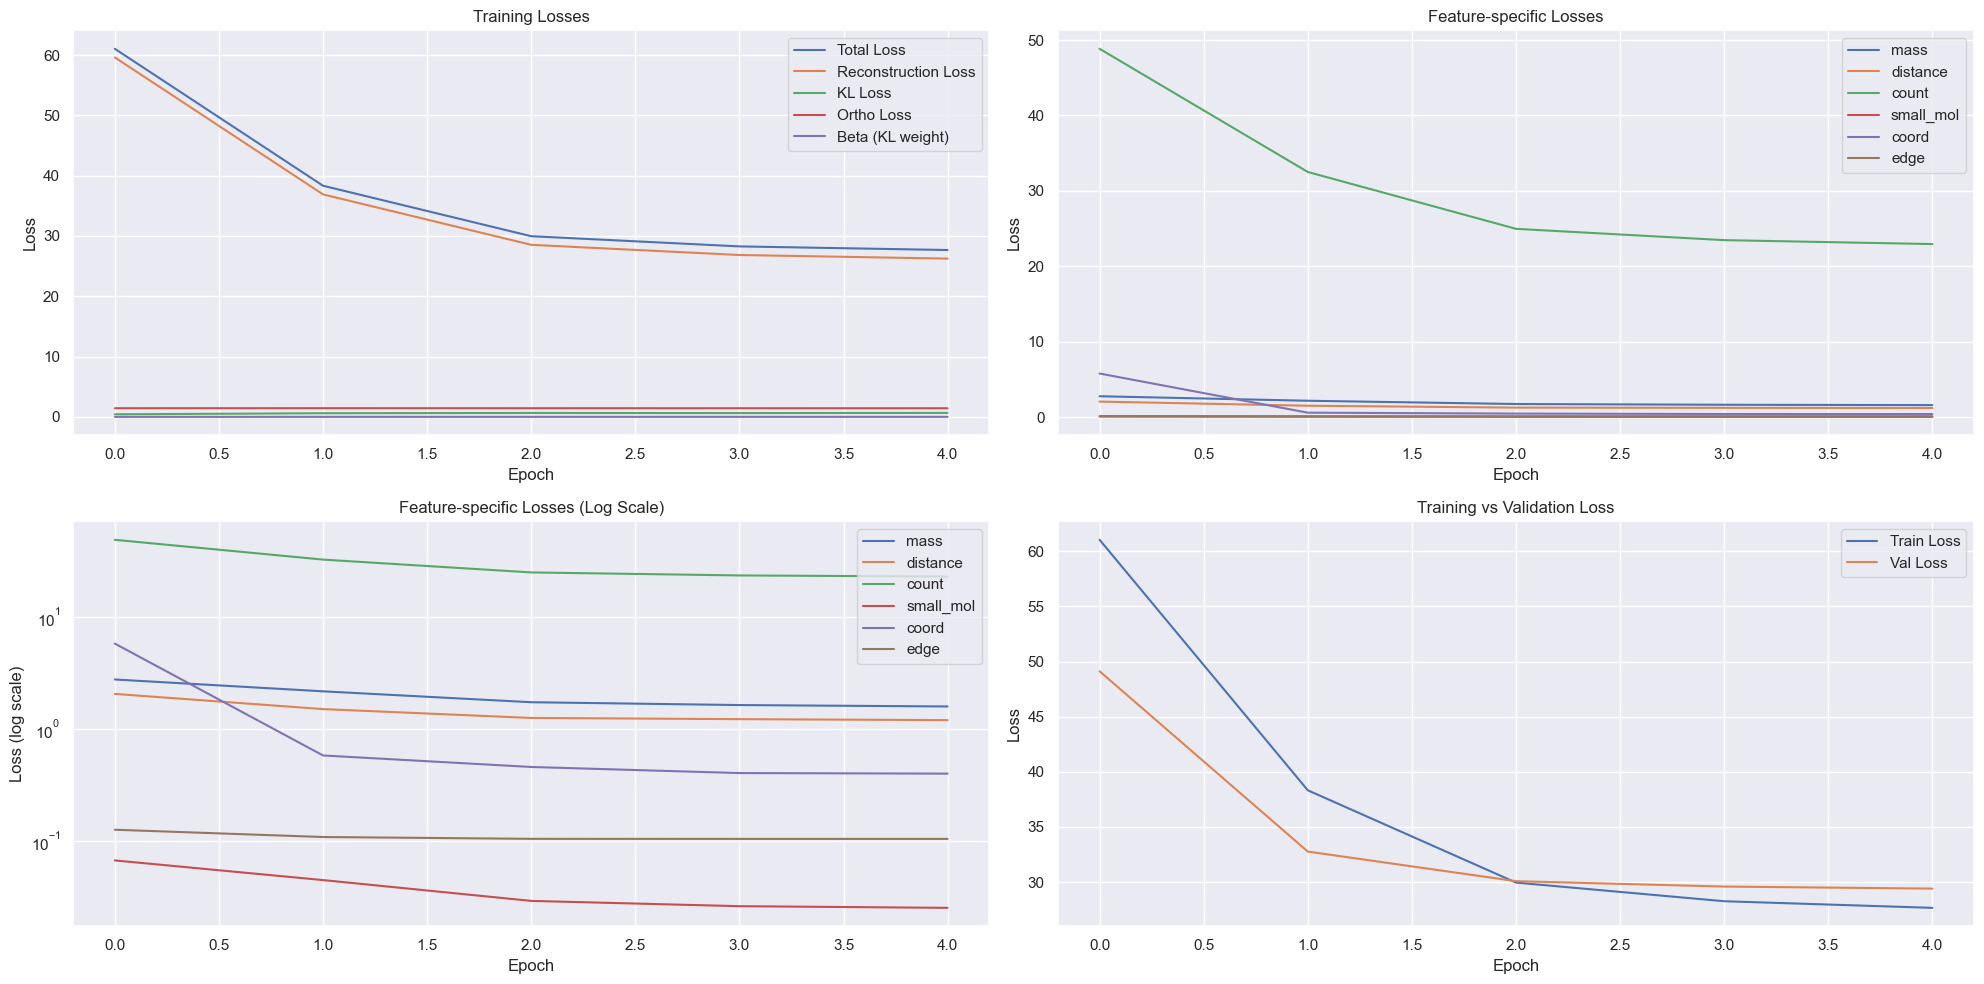

Epoch 6/10 [Train]:   0%|          | 0/82 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 90.4737
Raw KL loss: 0.5976
Ortho loss: 1.4257
Current beta: 0.0010
mu mean: -0.0037, std: 1.0350
logvar mean: -0.0773, std: 0.4843
mass: 4.2486
distance: 3.5493
count: 81.8290
small_mol: 0.0155
coord: 0.7299
edge: 0.1012


Epoch 6/10 [Train]:  12%|█▏        | 10/82 [00:19<02:01,  1.69s/it, loss=13.6617, recon=12.2401, kl=0.6527, ortho=1.4209]


Detailed loss diagnostics:
Raw recon_loss: 54.0916
Raw KL loss: 0.6197
Ortho loss: 1.4227
Current beta: 0.0010
mu mean: -0.0044, std: 1.0544
logvar mean: -0.0784, std: 0.5092
mass: 2.9456
distance: 2.2649
count: 47.6705
small_mol: 0.0265
coord: 1.0819
edge: 0.1023


Epoch 6/10 [Train]:  24%|██▍       | 20/82 [00:37<01:46,  1.71s/it, loss=20.8996, recon=19.4781, kl=0.6147, ortho=1.4209]


Detailed loss diagnostics:
Raw recon_loss: 2.8243
Raw KL loss: 0.5348
Ortho loss: 1.4196
Current beta: 0.0010
mu mean: -0.0046, std: 0.9716
logvar mean: -0.0794, std: 0.4935
mass: 0.9504
distance: 0.7094
count: 0.7298
small_mol: 0.0320
coord: 0.2838
edge: 0.1189


Epoch 6/10 [Train]:  37%|███▋      | 30/82 [00:57<01:40,  1.94s/it, loss=23.2290, recon=21.8023, kl=0.6263, ortho=1.4261]  


Detailed loss diagnostics:
Raw recon_loss: 18.3999
Raw KL loss: 0.6698
Ortho loss: 1.4196
Current beta: 0.0010
mu mean: -0.0046, std: 1.0896
logvar mean: -0.0804, std: 0.5589
mass: 1.1770
distance: 0.8800
count: 15.9166
small_mol: 0.0284
coord: 0.2952
edge: 0.1027


Epoch 6/10 [Train]:  49%|████▉     | 40/82 [01:18<01:20,  1.92s/it, loss=35.8935, recon=34.4741, kl=0.6844, ortho=1.4187]


Detailed loss diagnostics:
Raw recon_loss: 7.3012
Raw KL loss: 0.7263
Ortho loss: 1.4225
Current beta: 0.0010
mu mean: -0.0050, std: 1.1473
logvar mean: -0.0813, std: 0.5161
mass: 0.4799
distance: 0.4079
count: 6.1333
small_mol: 0.0426
coord: 0.1331
edge: 0.1044


Epoch 6/10 [Train]:  61%|██████    | 50/82 [01:36<01:12,  2.27s/it, loss=29.7264, recon=28.2992, kl=0.6618, ortho=1.4266]


Detailed loss diagnostics:
Raw recon_loss: 22.3555
Raw KL loss: 0.6863
Ortho loss: 1.4231
Current beta: 0.0010
mu mean: -0.0057, std: 1.1067
logvar mean: -0.0826, std: 0.5405
mass: 1.3591
distance: 1.0320
count: 19.4978
small_mol: 0.0148
coord: 0.3509
edge: 0.1009


Epoch 6/10 [Train]:  73%|███████▎  | 60/82 [01:53<00:32,  1.49s/it, loss=19.6440, recon=18.2260, kl=0.6661, ortho=1.4173]


Detailed loss diagnostics:
Raw recon_loss: 22.3732
Raw KL loss: 0.7001
Ortho loss: 1.4216
Current beta: 0.0010
mu mean: -0.0062, std: 1.1140
logvar mean: -0.0843, std: 0.5513
mass: 1.3188
distance: 1.0170
count: 19.4000
small_mol: 0.0384
coord: 0.4960
edge: 0.1028


Epoch 6/10 [Train]:  85%|████████▌ | 70/82 [02:14<00:32,  2.75s/it, loss=57.1197, recon=55.6860, kl=0.6435, ortho=1.4331]


Detailed loss diagnostics:
Raw recon_loss: 11.8225
Raw KL loss: 0.6760
Ortho loss: 1.4278
Current beta: 0.0010
mu mean: -0.0064, std: 1.0856
logvar mean: -0.0849, std: 0.5775
mass: 0.7634
distance: 0.6122
count: 10.0778
small_mol: 0.0270
coord: 0.2406
edge: 0.1014


Epoch 6/10 [Train]:  98%|█████████▊| 80/82 [02:33<00:03,  1.81s/it, loss=23.6324, recon=22.2102, kl=0.6023, ortho=1.4216]


Detailed loss diagnostics:
Raw recon_loss: 81.4719
Raw KL loss: 0.6556
Ortho loss: 1.4203
Current beta: 0.0010
mu mean: -0.0065, std: 1.0767
logvar mean: -0.0859, std: 0.5556
mass: 4.3742
distance: 3.1049
count: 73.4273
small_mol: 0.0180
coord: 0.4440
edge: 0.1035


Epoch 6/10 [Train]: 100%|██████████| 82/82 [02:37<00:00,  1.91s/it, loss=22.8204, recon=21.4013, kl=0.5960, ortho=1.4185]



Starting validation...


Epoch 6/10 [Valid]: 100%|██████████| 21/21 [00:11<00:00,  1.76it/s]



Epoch [6/10] - Time: 168.97s
Train - Total: 27.4636, Recon: 26.0406, KL: 0.6559, Ortho: 1.4224, Beta: 0.0010
Feature Losses:
  mass_loss: 1.5717
  distance_loss: 1.1870
  count_loss: 22.7473
  small_mol_loss: 0.0269
  coord_loss: 0.4040
  edge_loss: 0.1035


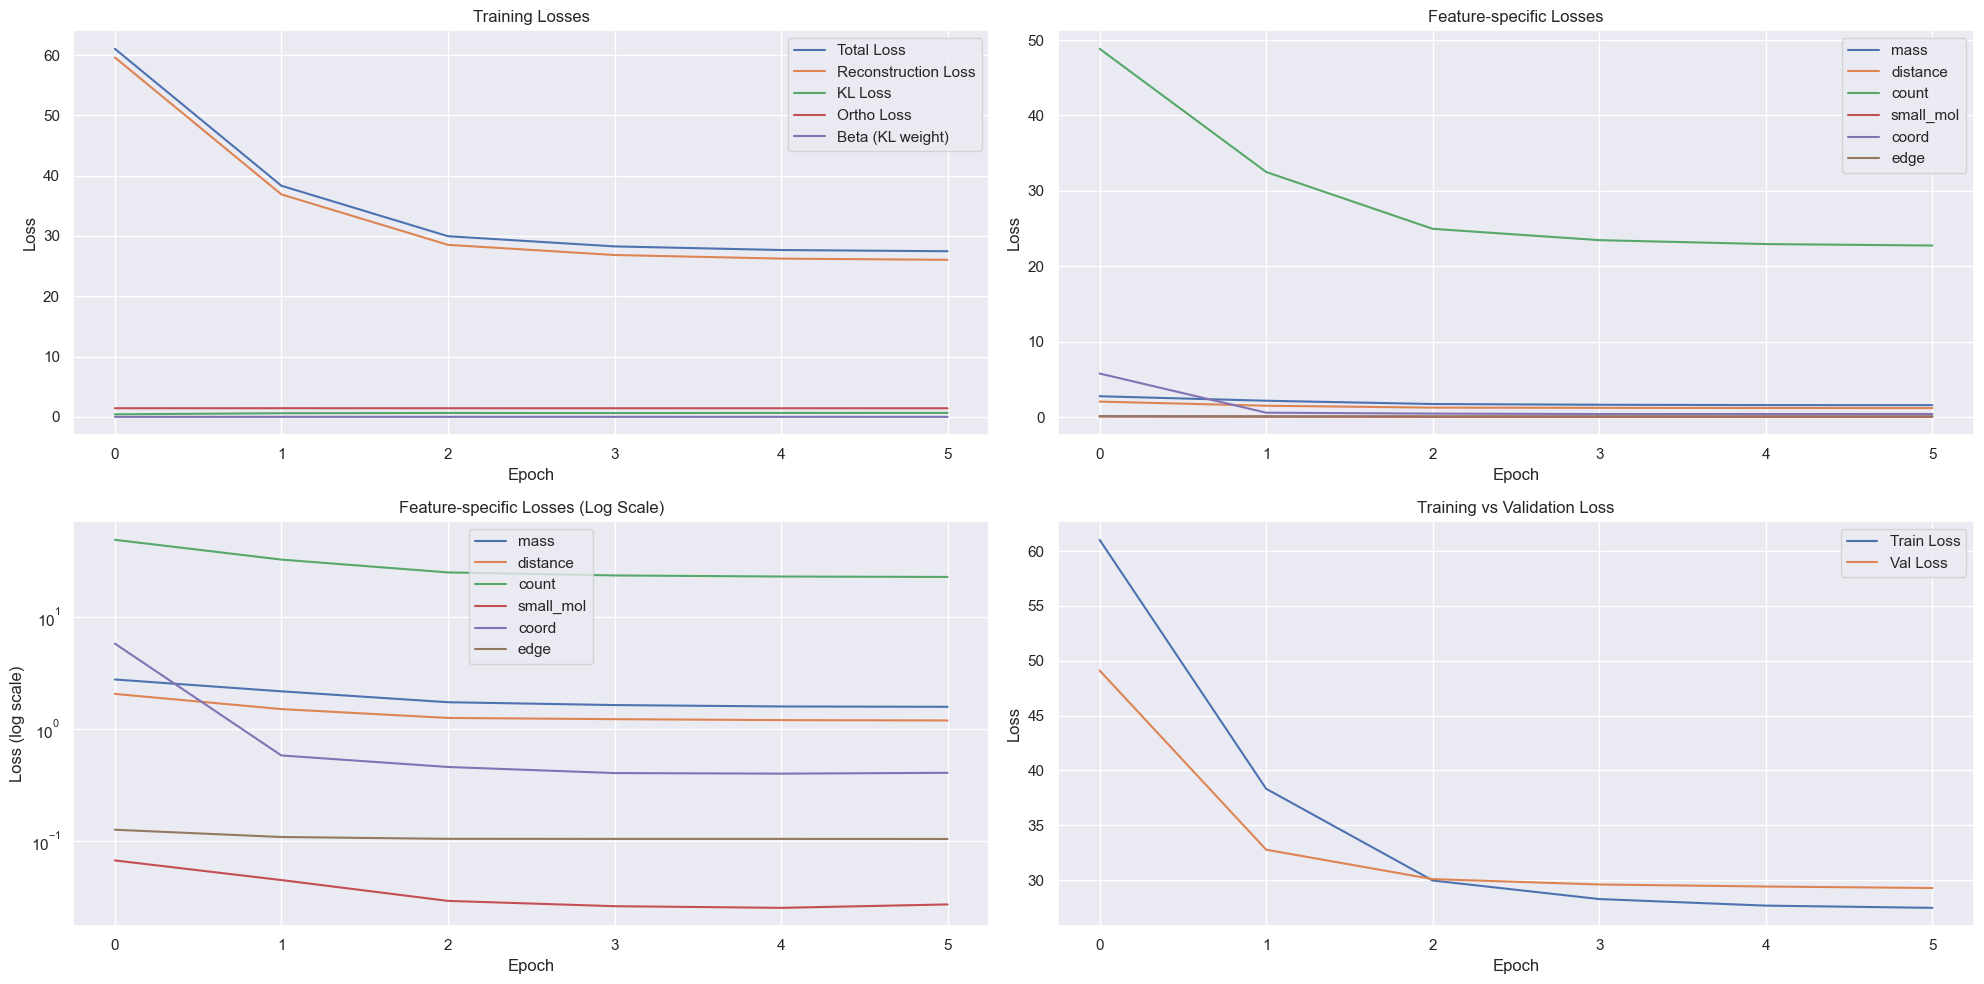

Epoch 7/10 [Train]:   0%|          | 0/82 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 35.7811
Raw KL loss: 0.6553
Ortho loss: 1.4208
Current beta: 0.0012
mu mean: -0.0064, std: 1.0730
logvar mean: -0.0863, std: 0.5684
mass: 2.1575
distance: 1.6706
count: 31.5147
small_mol: 0.0198
coord: 0.3152
edge: 0.1032


Epoch 7/10 [Train]:  12%|█▏        | 10/82 [00:18<02:02,  1.70s/it, loss=28.4314, recon=27.0087, kl=0.6639, ortho=1.4219] 


Detailed loss diagnostics:
Raw recon_loss: 14.1449
Raw KL loss: 0.6613
Ortho loss: 1.4203
Current beta: 0.0012
mu mean: -0.0059, std: 1.0797
logvar mean: -0.0881, std: 0.5617
mass: 0.8695
distance: 0.7336
count: 12.0905
small_mol: 0.0349
coord: 0.3142
edge: 0.1023


Epoch 7/10 [Train]:  24%|██▍       | 20/82 [00:39<02:01,  1.97s/it, loss=19.2179, recon=17.7971, kl=0.6751, ortho=1.4201]


Detailed loss diagnostics:
Raw recon_loss: 28.1114
Raw KL loss: 0.6667
Ortho loss: 1.4207
Current beta: 0.0012
mu mean: -0.0056, std: 1.0796
logvar mean: -0.0897, std: 0.5668
mass: 1.5735
distance: 1.2496
count: 24.8402
small_mol: 0.0144
coord: 0.3311
edge: 0.1025


Epoch 7/10 [Train]:  37%|███▋      | 30/82 [00:55<01:15,  1.45s/it, loss=13.2642, recon=11.8401, kl=0.6716, ortho=1.4232]


Detailed loss diagnostics:
Raw recon_loss: 2.8431
Raw KL loss: 0.6810
Ortho loss: 1.4224
Current beta: 0.0012
mu mean: -0.0054, std: 1.0998
logvar mean: -0.0905, std: 0.5494
mass: 0.8141
distance: 0.6264
count: 1.0420
small_mol: 0.0206
coord: 0.2322
edge: 0.1078


Epoch 7/10 [Train]:  49%|████▉     | 40/82 [01:13<01:18,  1.88s/it, loss=17.5337, recon=16.1082, kl=0.7380, ortho=1.4246]


Detailed loss diagnostics:
Raw recon_loss: 26.9067
Raw KL loss: 0.6546
Ortho loss: 1.4207
Current beta: 0.0012
mu mean: -0.0053, std: 1.0754
logvar mean: -0.0912, std: 0.5372
mass: 1.3826
distance: 1.0626
count: 23.9035
small_mol: 0.0197
coord: 0.4347
edge: 0.1036


Epoch 7/10 [Train]:  61%|██████    | 50/82 [01:33<01:12,  2.28s/it, loss=59.9816, recon=58.5606, kl=0.6225, ortho=1.4203]


Detailed loss diagnostics:
Raw recon_loss: 32.4694
Raw KL loss: 0.7454
Ortho loss: 1.4195
Current beta: 0.0012
mu mean: -0.0052, std: 1.1521
logvar mean: -0.0925, std: 0.5452
mass: 1.7265
distance: 1.3117
count: 28.7448
small_mol: 0.0221
coord: 0.5612
edge: 0.1031


Epoch 7/10 [Train]:  73%|███████▎  | 60/82 [01:50<00:40,  1.82s/it, loss=44.9782, recon=43.5562, kl=0.6692, ortho=1.4212]


Detailed loss diagnostics:
Raw recon_loss: 60.9639
Raw KL loss: 0.6681
Ortho loss: 1.4226
Current beta: 0.0012
mu mean: -0.0049, std: 1.0869
logvar mean: -0.0936, std: 0.5282
mass: 3.0440
distance: 2.4203
count: 54.5209
small_mol: 0.0220
coord: 0.8529
edge: 0.1038


Epoch 7/10 [Train]:  85%|████████▌ | 70/82 [02:10<00:22,  1.86s/it, loss=5.0670, recon=3.6433, kl=0.6629, ortho=1.4229]  


Detailed loss diagnostics:
Raw recon_loss: 53.6670
Raw KL loss: 0.6491
Ortho loss: 1.4238
Current beta: 0.0012
mu mean: -0.0049, std: 1.0582
logvar mean: -0.0949, std: 0.5332
mass: 2.8014
distance: 2.0855
count: 47.7524
small_mol: 0.0115
coord: 0.9157
edge: 0.1005


Epoch 7/10 [Train]:  98%|█████████▊| 80/82 [02:32<00:03,  1.74s/it, loss=12.2857, recon=10.8657, kl=0.7532, ortho=1.4190]


Detailed loss diagnostics:
Raw recon_loss: 30.9316
Raw KL loss: 0.7001
Ortho loss: 1.4209
Current beta: 0.0012
mu mean: -0.0050, std: 1.1276
logvar mean: -0.0957, std: 0.5249
mass: 1.7523
distance: 1.3725
count: 27.2827
small_mol: 0.0198
coord: 0.3993
edge: 0.1050


Epoch 7/10 [Train]: 100%|██████████| 82/82 [02:35<00:00,  1.89s/it, loss=28.7611, recon=27.3401, kl=0.7085, ortho=1.4202]



Starting validation...


Epoch 7/10 [Valid]: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]



Epoch [7/10] - Time: 167.24s
Train - Total: 28.4938, Recon: 27.0712, KL: 0.6870, Ortho: 1.4218, Beta: 0.0012
Feature Losses:
  mass_loss: 1.6429
  distance_loss: 1.2431
  count_loss: 23.6438
  small_mol_loss: 0.0261
  coord_loss: 0.4116
  edge_loss: 0.1036


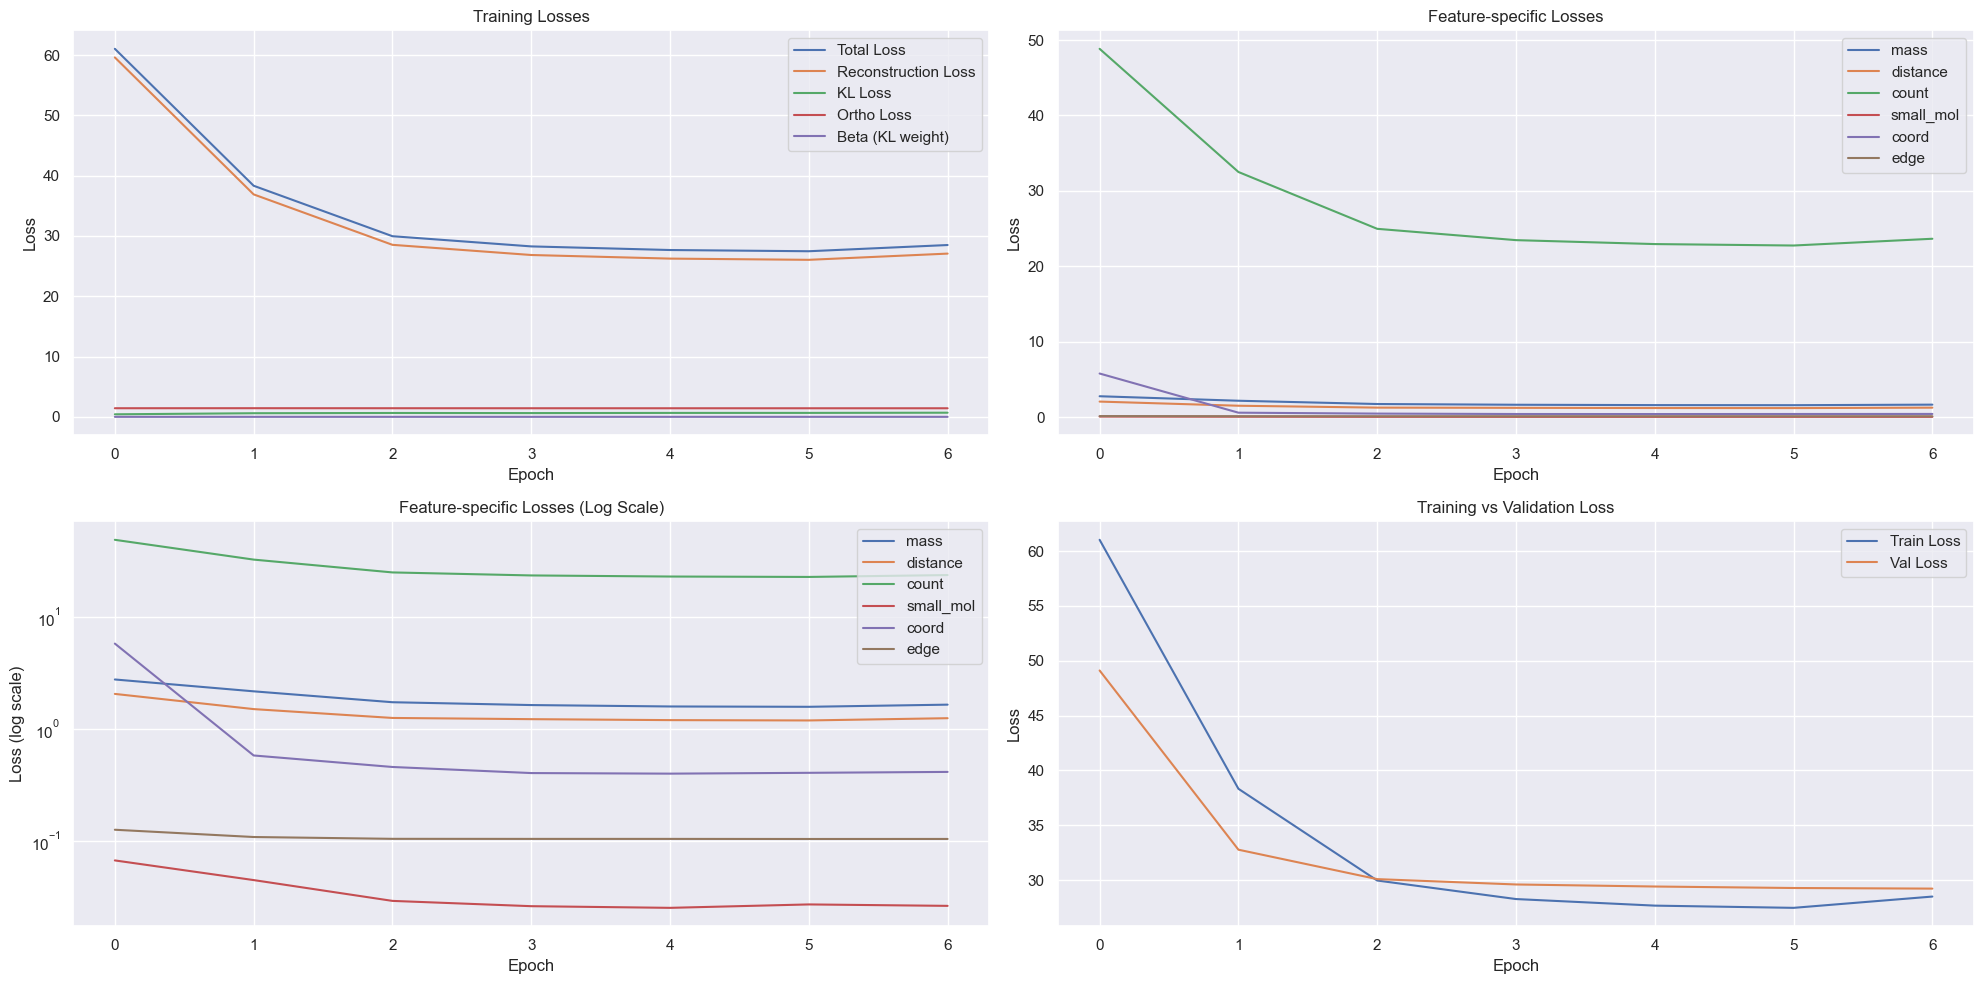

Epoch 8/10 [Train]:   0%|          | 0/82 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 36.0085
Raw KL loss: 0.7008
Ortho loss: 1.4184
Current beta: 0.0014
mu mean: -0.0050, std: 1.1257
logvar mean: -0.0959, std: 0.5185
mass: 1.9442
distance: 1.5220
count: 31.9737
small_mol: 0.0267
coord: 0.4376
edge: 0.1044


Epoch 8/10 [Train]:  12%|█▏        | 10/82 [00:19<02:15,  1.88s/it, loss=11.0422, recon=9.6213, kl=0.7012, ortho=1.4200]


Detailed loss diagnostics:
Raw recon_loss: 17.8546
Raw KL loss: 0.7241
Ortho loss: 1.4197
Current beta: 0.0014
mu mean: -0.0048, std: 1.1391
logvar mean: -0.0972, std: 0.5351
mass: 1.1276
distance: 0.8500
count: 15.4929
small_mol: 0.0138
coord: 0.2678
edge: 0.1026


Epoch 8/10 [Train]:  24%|██▍       | 20/82 [00:34<01:28,  1.43s/it, loss=7.9578, recon=6.5379, kl=0.7227, ortho=1.4188]  


Detailed loss diagnostics:
Raw recon_loss: 20.7895
Raw KL loss: 0.7965
Ortho loss: 1.4241
Current beta: 0.0014
mu mean: -0.0048, std: 1.2026
logvar mean: -0.0991, std: 0.5644
mass: 1.3455
distance: 0.9767
count: 17.9595
small_mol: 0.0197
coord: 0.3841
edge: 0.1040


Epoch 8/10 [Train]:  37%|███▋      | 30/82 [00:53<01:39,  1.91s/it, loss=29.1872, recon=27.7650, kl=0.7482, ortho=1.4212]


Detailed loss diagnostics:
Raw recon_loss: 11.7795
Raw KL loss: 0.7518
Ortho loss: 1.4219
Current beta: 0.0014
mu mean: -0.0055, std: 1.1744
logvar mean: -0.1006, std: 0.5048
mass: 0.7439
distance: 0.6035
count: 10.0641
small_mol: 0.0283
coord: 0.2374
edge: 0.1024


Epoch 8/10 [Train]:  49%|████▉     | 40/82 [01:12<01:18,  1.88s/it, loss=20.9800, recon=19.5587, kl=0.7392, ortho=1.4203]


Detailed loss diagnostics:
Raw recon_loss: 21.4108
Raw KL loss: 0.7525
Ortho loss: 1.4224
Current beta: 0.0014
mu mean: -0.0058, std: 1.1805
logvar mean: -0.1016, std: 0.5008
mass: 1.3180
distance: 1.0474
count: 18.6434
small_mol: 0.0224
coord: 0.2793
edge: 0.1003


Epoch 8/10 [Train]:  61%|██████    | 50/82 [01:31<01:12,  2.28s/it, loss=28.9850, recon=27.5634, kl=0.7591, ortho=1.4205]


Detailed loss diagnostics:
Raw recon_loss: 4.1042
Raw KL loss: 0.6398
Ortho loss: 1.4201
Current beta: 0.0014
mu mean: -0.0062, std: 1.0684
logvar mean: -0.1030, std: 0.5095
mass: 1.4654
distance: 1.0495
count: 1.0514
small_mol: 0.0248
coord: 0.3977
edge: 0.1154


Epoch 8/10 [Train]:  73%|███████▎  | 60/82 [01:47<00:32,  1.46s/it, loss=11.8069, recon=10.3856, kl=0.7273, ortho=1.4202]


Detailed loss diagnostics:
Raw recon_loss: 9.1789
Raw KL loss: 0.7535
Ortho loss: 1.4198
Current beta: 0.0014
mu mean: -0.0067, std: 1.1787
logvar mean: -0.1043, std: 0.5032
mass: 0.5560
distance: 0.4293
count: 7.8773
small_mol: 0.0226
coord: 0.1905
edge: 0.1033


Epoch 8/10 [Train]:  85%|████████▌ | 70/82 [02:06<00:21,  1.79s/it, loss=17.7480, recon=16.3280, kl=0.7115, ortho=1.4190]


Detailed loss diagnostics:
Raw recon_loss: 70.6818
Raw KL loss: 0.7005
Ortho loss: 1.4198
Current beta: 0.0014
mu mean: -0.0065, std: 1.1371
logvar mean: -0.1064, std: 0.4825
mass: 3.8289
distance: 2.7946
count: 62.7152
small_mol: 0.0160
coord: 1.2247
edge: 0.1024


Epoch 8/10 [Train]:  98%|█████████▊| 80/82 [02:29<00:04,  2.42s/it, loss=32.5219, recon=31.0914, kl=0.7611, ortho=1.4293]


Detailed loss diagnostics:
Raw recon_loss: 27.6072
Raw KL loss: 0.8312
Ortho loss: 1.4235
Current beta: 0.0014
mu mean: -0.0066, std: 1.2422
logvar mean: -0.1085, std: 0.5190
mass: 1.7298
distance: 1.1789
count: 24.2587
small_mol: 0.0207
coord: 0.3171
edge: 0.1019


Epoch 8/10 [Train]: 100%|██████████| 82/82 [02:32<00:00,  1.87s/it, loss=20.4738, recon=19.0522, kl=0.7984, ortho=1.4205]



Starting validation...


Epoch 8/10 [Valid]: 100%|██████████| 21/21 [00:11<00:00,  1.79it/s]



Epoch [8/10] - Time: 164.70s
Train - Total: 25.6354, Recon: 24.2132, KL: 0.7272, Ortho: 1.4212, Beta: 0.0014
Feature Losses:
  mass_loss: 1.4653
  distance_loss: 1.1182
  count_loss: 21.1212
  small_mol_loss: 0.0252
  coord_loss: 0.3796
  edge_loss: 0.1037


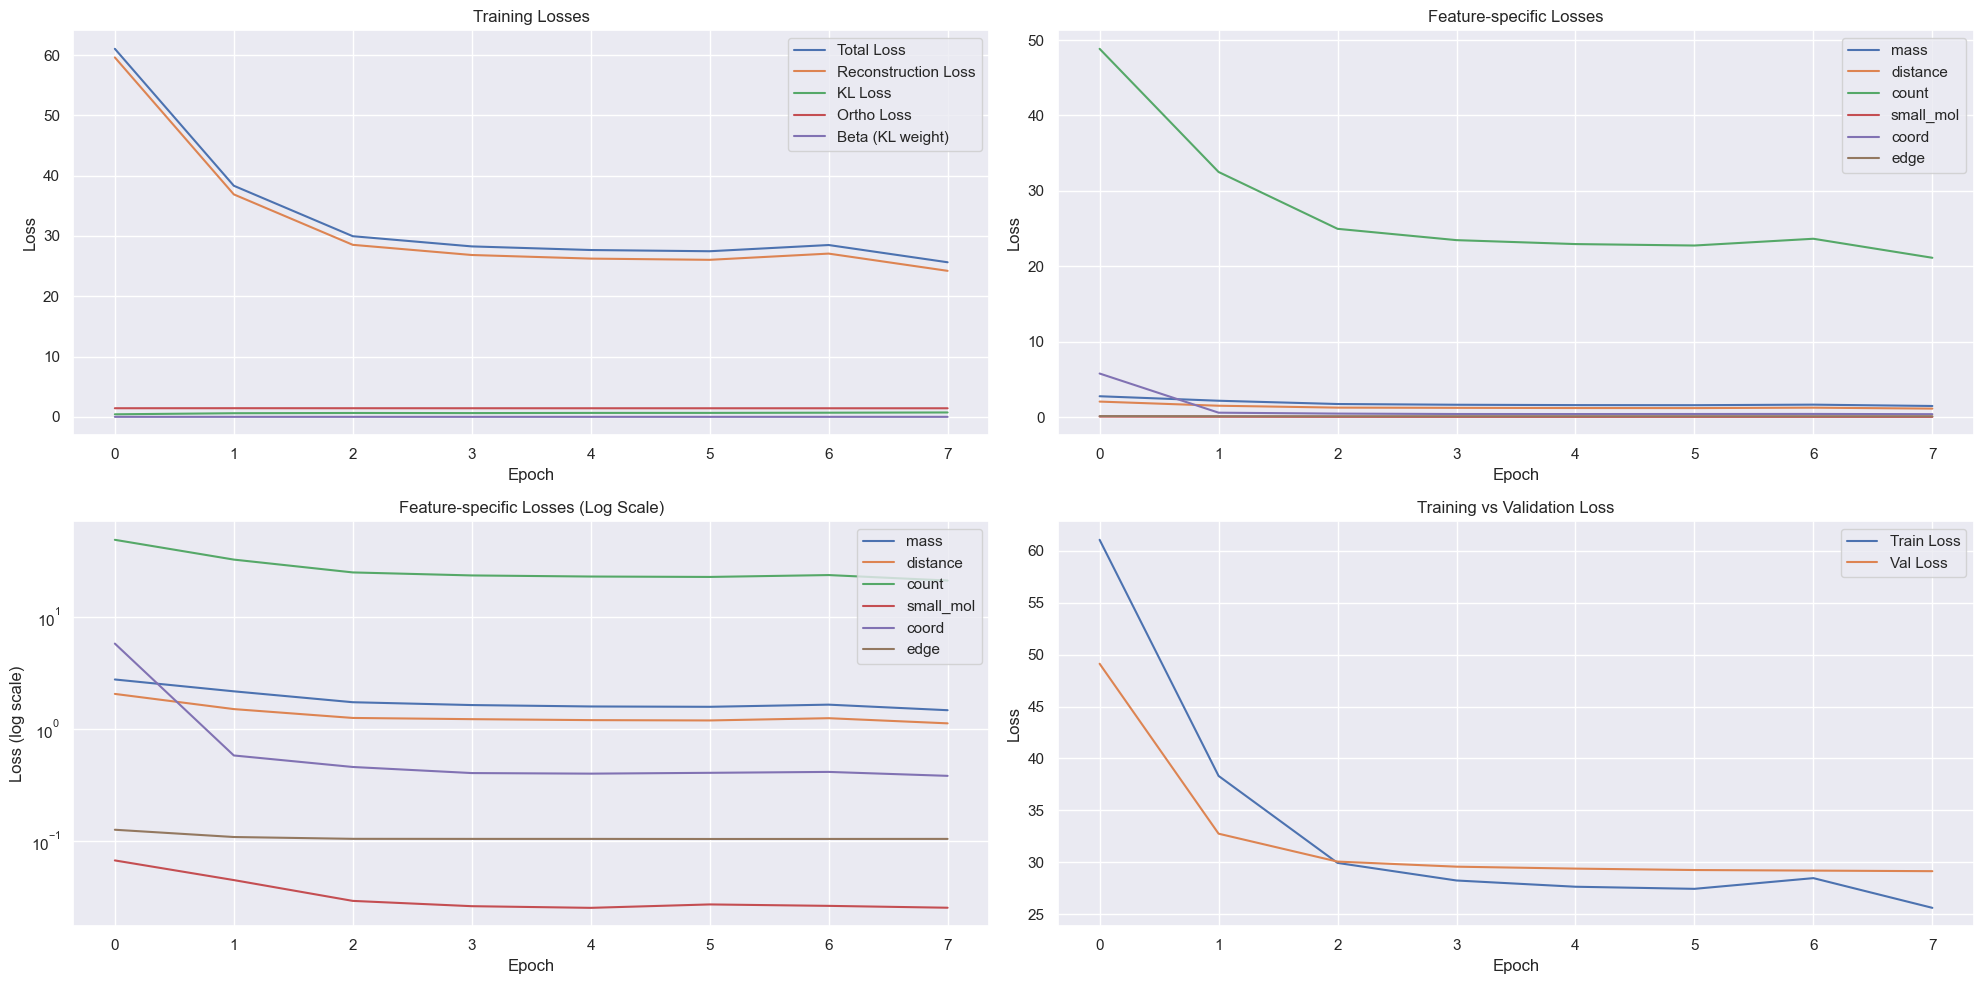

Epoch 9/10 [Train]:   0%|          | 0/82 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 3.6875
Raw KL loss: 0.6731
Ortho loss: 1.4199
Current beta: 0.0016
mu mean: -0.0067, std: 1.1001
logvar mean: -0.1088, std: 0.5132
mass: 1.4332
distance: 1.0262
count: 0.8304
small_mol: 0.0227
coord: 0.2554
edge: 0.1197


Epoch 9/10 [Train]:  12%|█▏        | 10/82 [00:17<02:22,  1.97s/it, loss=21.0171, recon=19.5968, kl=0.7774, ortho=1.4191] 


Detailed loss diagnostics:
Raw recon_loss: 16.0579
Raw KL loss: 0.8150
Ortho loss: 1.4247
Current beta: 0.0016
mu mean: -0.0061, std: 1.2253
logvar mean: -0.1106, std: 0.5153
mass: 0.9627
distance: 0.7140
count: 13.9610
small_mol: 0.0150
coord: 0.3037
edge: 0.1015


Epoch 9/10 [Train]:  24%|██▍       | 20/82 [00:36<01:53,  1.83s/it, loss=14.3982, recon=12.9778, kl=0.7806, ortho=1.4191]


Detailed loss diagnostics:
Raw recon_loss: 24.8927
Raw KL loss: 0.7697
Ortho loss: 1.4233
Current beta: 0.0016
mu mean: -0.0057, std: 1.1975
logvar mean: -0.1118, std: 0.4858
mass: 1.4721
distance: 1.1989
count: 21.7770
small_mol: 0.0244
coord: 0.3187
edge: 0.1015


Epoch 9/10 [Train]:  37%|███▋      | 30/82 [00:53<01:22,  1.59s/it, loss=9.2018, recon=7.7836, kl=0.7771, ortho=1.4169]  


Detailed loss diagnostics:
Raw recon_loss: 16.3535
Raw KL loss: 0.7660
Ortho loss: 1.4185
Current beta: 0.0016
mu mean: -0.0052, std: 1.1915
logvar mean: -0.1129, std: 0.4925
mass: 0.9588
distance: 0.7270
count: 14.3013
small_mol: 0.0356
coord: 0.2258
edge: 0.1050


Epoch 9/10 [Train]:  49%|████▉     | 40/82 [01:09<00:57,  1.37s/it, loss=11.0238, recon=9.6020, kl=0.6388, ortho=1.4207] 


Detailed loss diagnostics:
Raw recon_loss: 21.7451
Raw KL loss: 0.7771
Ortho loss: 1.4216
Current beta: 0.0016
mu mean: -0.0052, std: 1.1856
logvar mean: -0.1138, std: 0.5465
mass: 1.2389
distance: 0.9477
count: 19.0641
small_mol: 0.0236
coord: 0.3678
edge: 0.1031


Epoch 9/10 [Train]:  61%|██████    | 50/82 [01:27<00:54,  1.70s/it, loss=45.9016, recon=44.4783, kl=0.7589, ortho=1.4221]


Detailed loss diagnostics:
Raw recon_loss: 40.7965
Raw KL loss: 0.6508
Ortho loss: 1.4186
Current beta: 0.0016
mu mean: -0.0049, std: 1.0963
logvar mean: -0.1153, std: 0.4734
mass: 2.1476
distance: 1.7097
count: 36.1387
small_mol: 0.0227
coord: 0.6745
edge: 0.1034


Epoch 9/10 [Train]:  73%|███████▎  | 60/82 [01:52<00:49,  2.24s/it, loss=29.0274, recon=27.6067, kl=0.7351, ortho=1.4196]


Detailed loss diagnostics:
Raw recon_loss: 8.1209
Raw KL loss: 0.7928
Ortho loss: 1.4203
Current beta: 0.0016
mu mean: -0.0045, std: 1.2115
logvar mean: -0.1181, std: 0.4967
mass: 0.5740
distance: 0.4615
count: 6.8029
small_mol: 0.0431
coord: 0.1377
edge: 0.1017


Epoch 9/10 [Train]:  85%|████████▌ | 70/82 [02:10<00:23,  1.98s/it, loss=22.2894, recon=20.8706, kl=0.7345, ortho=1.4176]


Detailed loss diagnostics:
Raw recon_loss: 10.7809
Raw KL loss: 0.8063
Ortho loss: 1.4270
Current beta: 0.0016
mu mean: -0.0045, std: 1.2161
logvar mean: -0.1203, std: 0.5304
mass: 0.6943
distance: 0.5605
count: 9.0165
small_mol: 0.0376
coord: 0.3712
edge: 0.1008


Epoch 9/10 [Train]:  98%|█████████▊| 80/82 [02:34<00:05,  2.72s/it, loss=19.4248, recon=18.0043, kl=0.7134, ortho=1.4193]


Detailed loss diagnostics:
Raw recon_loss: 23.8568
Raw KL loss: 0.7252
Ortho loss: 1.4216
Current beta: 0.0016
mu mean: -0.0044, std: 1.1521
logvar mean: -0.1220, std: 0.5130
mass: 1.3162
distance: 1.0105
count: 20.9787
small_mol: 0.0323
coord: 0.4175
edge: 0.1018


Epoch 9/10 [Train]: 100%|██████████| 82/82 [02:36<00:00,  1.91s/it, loss=11.2403, recon=9.8194, kl=0.6713, ortho=1.4197] 



Starting validation...


Epoch 9/10 [Valid]: 100%|██████████| 21/21 [00:11<00:00,  1.84it/s]



Epoch [9/10] - Time: 167.75s
Train - Total: 24.7123, Recon: 23.2903, KL: 0.7537, Ortho: 1.4208, Beta: 0.0016
Feature Losses:
  mass_loss: 1.4542
  distance_loss: 1.0975
  count_loss: 20.2486
  small_mol_loss: 0.0261
  coord_loss: 0.3602
  edge_loss: 0.1036


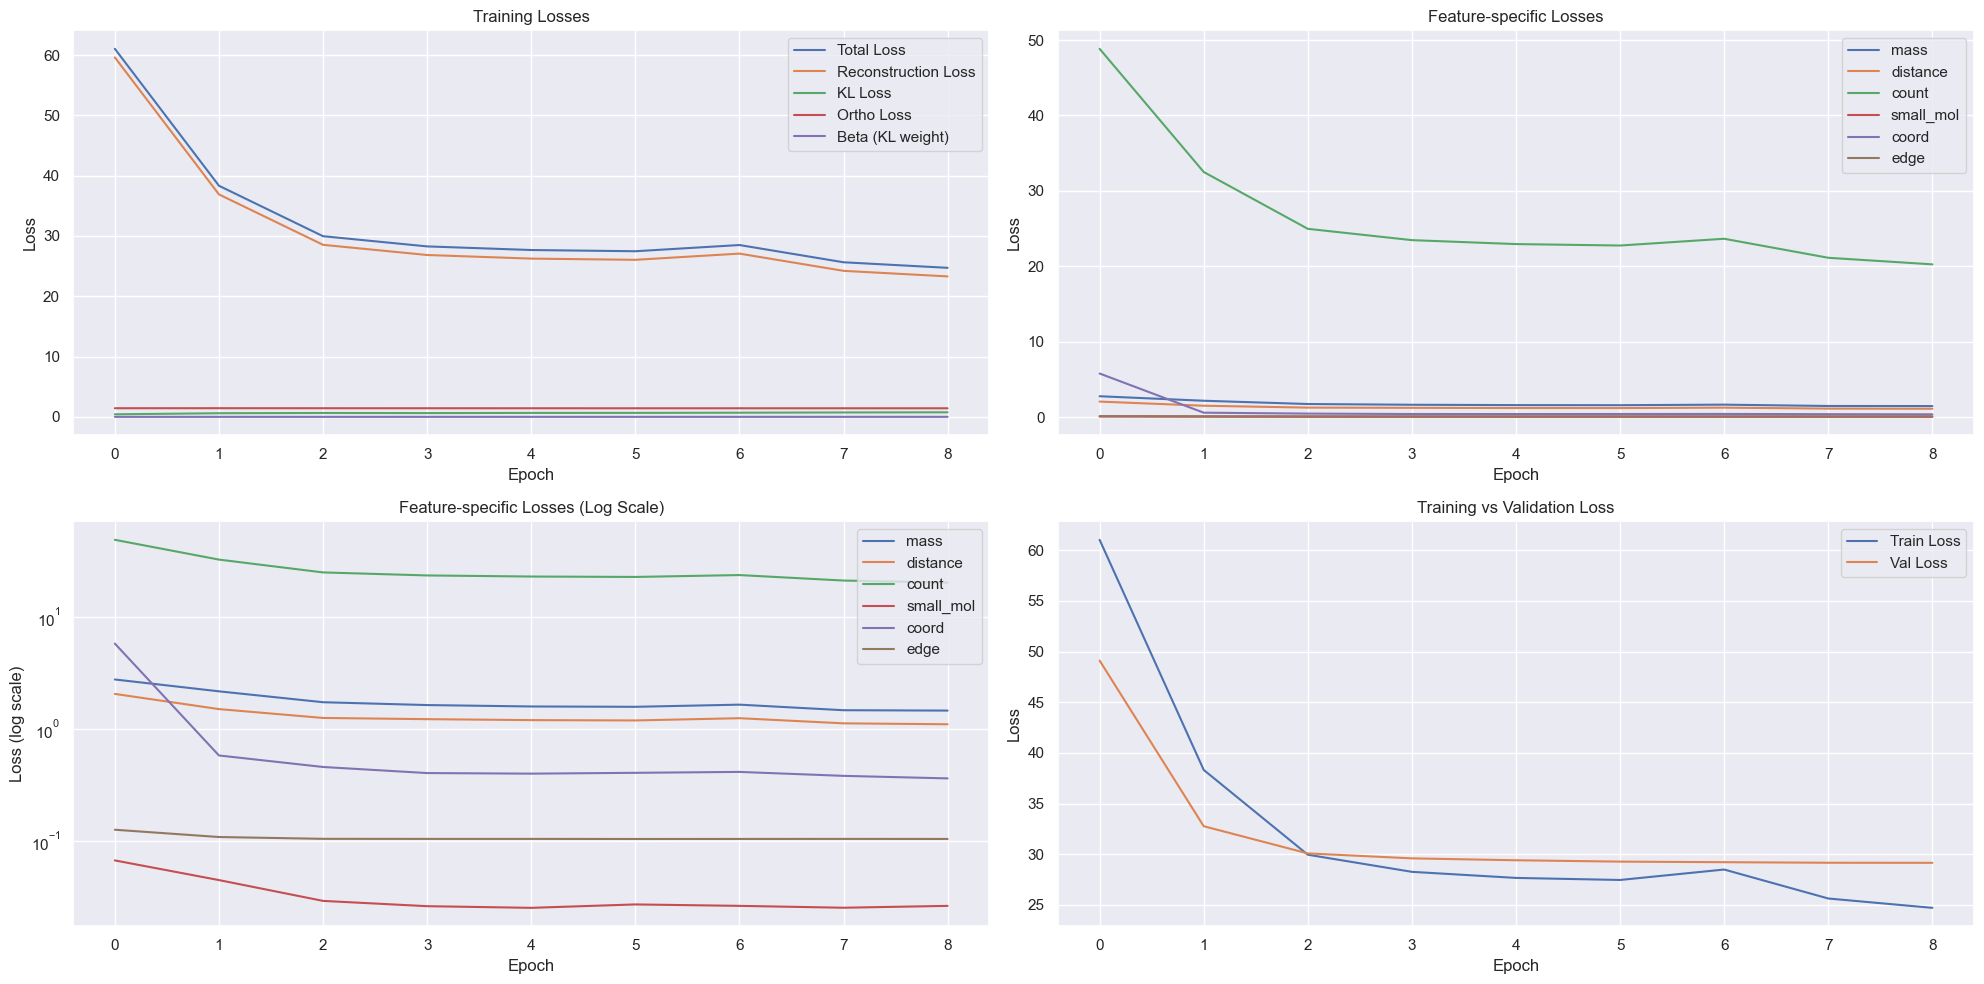

Epoch 10/10 [Train]:   0%|          | 0/82 [00:00<?, ?it/s]


Detailed loss diagnostics:
Raw recon_loss: 19.5324
Raw KL loss: 0.8089
Ortho loss: 1.4193
Current beta: 0.0018
mu mean: -0.0043, std: 1.2217
logvar mean: -0.1221, std: 0.5165
mass: 1.0942
distance: 0.8935
count: 17.0916
small_mol: 0.0260
coord: 0.3213
edge: 0.1058


Epoch 10/10 [Train]:  12%|█▏        | 10/82 [00:16<01:36,  1.34s/it, loss=9.7863, recon=8.3688, kl=0.6523, ortho=1.4162] 


Detailed loss diagnostics:
Raw recon_loss: 15.9729
Raw KL loss: 0.7817
Ortho loss: 1.4191
Current beta: 0.0018
mu mean: -0.0039, std: 1.1914
logvar mean: -0.1229, std: 0.5421
mass: 0.9754
distance: 0.7546
count: 13.9107
small_mol: 0.0236
coord: 0.2068
edge: 0.1017


Epoch 10/10 [Train]:  24%|██▍       | 20/82 [00:37<02:15,  2.18s/it, loss=32.3177, recon=30.8979, kl=0.7212, ortho=1.4185]


Detailed loss diagnostics:
Raw recon_loss: 32.4999
Raw KL loss: 0.8009
Ortho loss: 1.4206
Current beta: 0.0018
mu mean: -0.0038, std: 1.2196
logvar mean: -0.1246, std: 0.5225
mass: 1.8929
distance: 1.4235
count: 28.7595
small_mol: 0.0195
coord: 0.3010
edge: 0.1034


Epoch 10/10 [Train]:  37%|███▋      | 30/82 [00:58<01:42,  1.98s/it, loss=3.5260, recon=2.1018, kl=0.8274, ortho=1.4227]  


Detailed loss diagnostics:
Raw recon_loss: 36.7027
Raw KL loss: 0.8450
Ortho loss: 1.4218
Current beta: 0.0018
mu mean: -0.0044, std: 1.2514
logvar mean: -0.1269, std: 0.5463
mass: 2.2052
distance: 1.4598
count: 32.5742
small_mol: 0.0272
coord: 0.3346
edge: 0.1018


Epoch 10/10 [Train]:  49%|████▉     | 40/82 [01:20<01:24,  2.01s/it, loss=16.9142, recon=15.4966, kl=0.7418, ortho=1.4162]


Detailed loss diagnostics:
Raw recon_loss: 17.3125
Raw KL loss: 0.8773
Ortho loss: 1.4187
Current beta: 0.0018
mu mean: -0.0049, std: 1.2681
logvar mean: -0.1289, std: 0.5737
mass: 1.1095
distance: 0.8043
count: 14.9640
small_mol: 0.0314
coord: 0.2999
edge: 0.1034


Epoch 10/10 [Train]:  61%|██████    | 50/82 [01:38<00:51,  1.60s/it, loss=18.0471, recon=16.6266, kl=0.8369, ortho=1.4189]


Detailed loss diagnostics:
Raw recon_loss: 23.2055
Raw KL loss: 0.7994
Ortho loss: 1.4181
Current beta: 0.0018
mu mean: -0.0055, std: 1.2162
logvar mean: -0.1313, std: 0.5374
mass: 1.3321
distance: 1.0334
count: 20.3928
small_mol: 0.0231
coord: 0.3194
edge: 0.1047


Epoch 10/10 [Train]:  73%|███████▎  | 60/82 [02:00<01:03,  2.87s/it, loss=56.7589, recon=55.3377, kl=0.7547, ortho=1.4198]


Detailed loss diagnostics:
Raw recon_loss: 6.0517
Raw KL loss: 0.7718
Ortho loss: 1.4219
Current beta: 0.0018
mu mean: -0.0058, std: 1.1727
logvar mean: -0.1332, std: 0.5663
mass: 0.4576
distance: 0.3513
count: 4.9411
small_mol: 0.0333
coord: 0.1686
edge: 0.0999


Epoch 10/10 [Train]:  85%|████████▌ | 70/82 [02:16<00:20,  1.71s/it, loss=9.6923, recon=8.2718, kl=0.7830, ortho=1.4191]  


Detailed loss diagnostics:
Raw recon_loss: 41.4473
Raw KL loss: 0.8423
Ortho loss: 1.4208
Current beta: 0.0018
mu mean: -0.0054, std: 1.2512
logvar mean: -0.1351, std: 0.5445
mass: 2.4451
distance: 1.8434
count: 36.5447
small_mol: 0.0132
coord: 0.4986
edge: 0.1024


Epoch 10/10 [Train]:  98%|█████████▊| 80/82 [02:33<00:02,  1.44s/it, loss=16.7461, recon=15.3236, kl=0.8088, ortho=1.4210]


Detailed loss diagnostics:
Raw recon_loss: 24.0853
Raw KL loss: 0.8154
Ortho loss: 1.4219
Current beta: 0.0018
mu mean: -0.0050, std: 1.2239
logvar mean: -0.1369, std: 0.5520
mass: 1.4619
distance: 1.1466
count: 20.8444
small_mol: 0.0273
coord: 0.5031
edge: 0.1021


Epoch 10/10 [Train]: 100%|██████████| 82/82 [02:35<00:00,  1.90s/it, loss=37.8919, recon=36.4701, kl=0.8044, ortho=1.4203]



Starting validation...


Epoch 10/10 [Valid]: 100%|██████████| 21/21 [00:11<00:00,  1.77it/s]



Epoch [10/10] - Time: 167.59s
Train - Total: 27.6365, Recon: 26.2152, KL: 0.7835, Ortho: 1.4198, Beta: 0.0018
Feature Losses:
  mass_loss: 1.5553
  distance_loss: 1.1845
  count_loss: 22.9681
  small_mol_loss: 0.0256
  coord_loss: 0.3780
  edge_loss: 0.1036


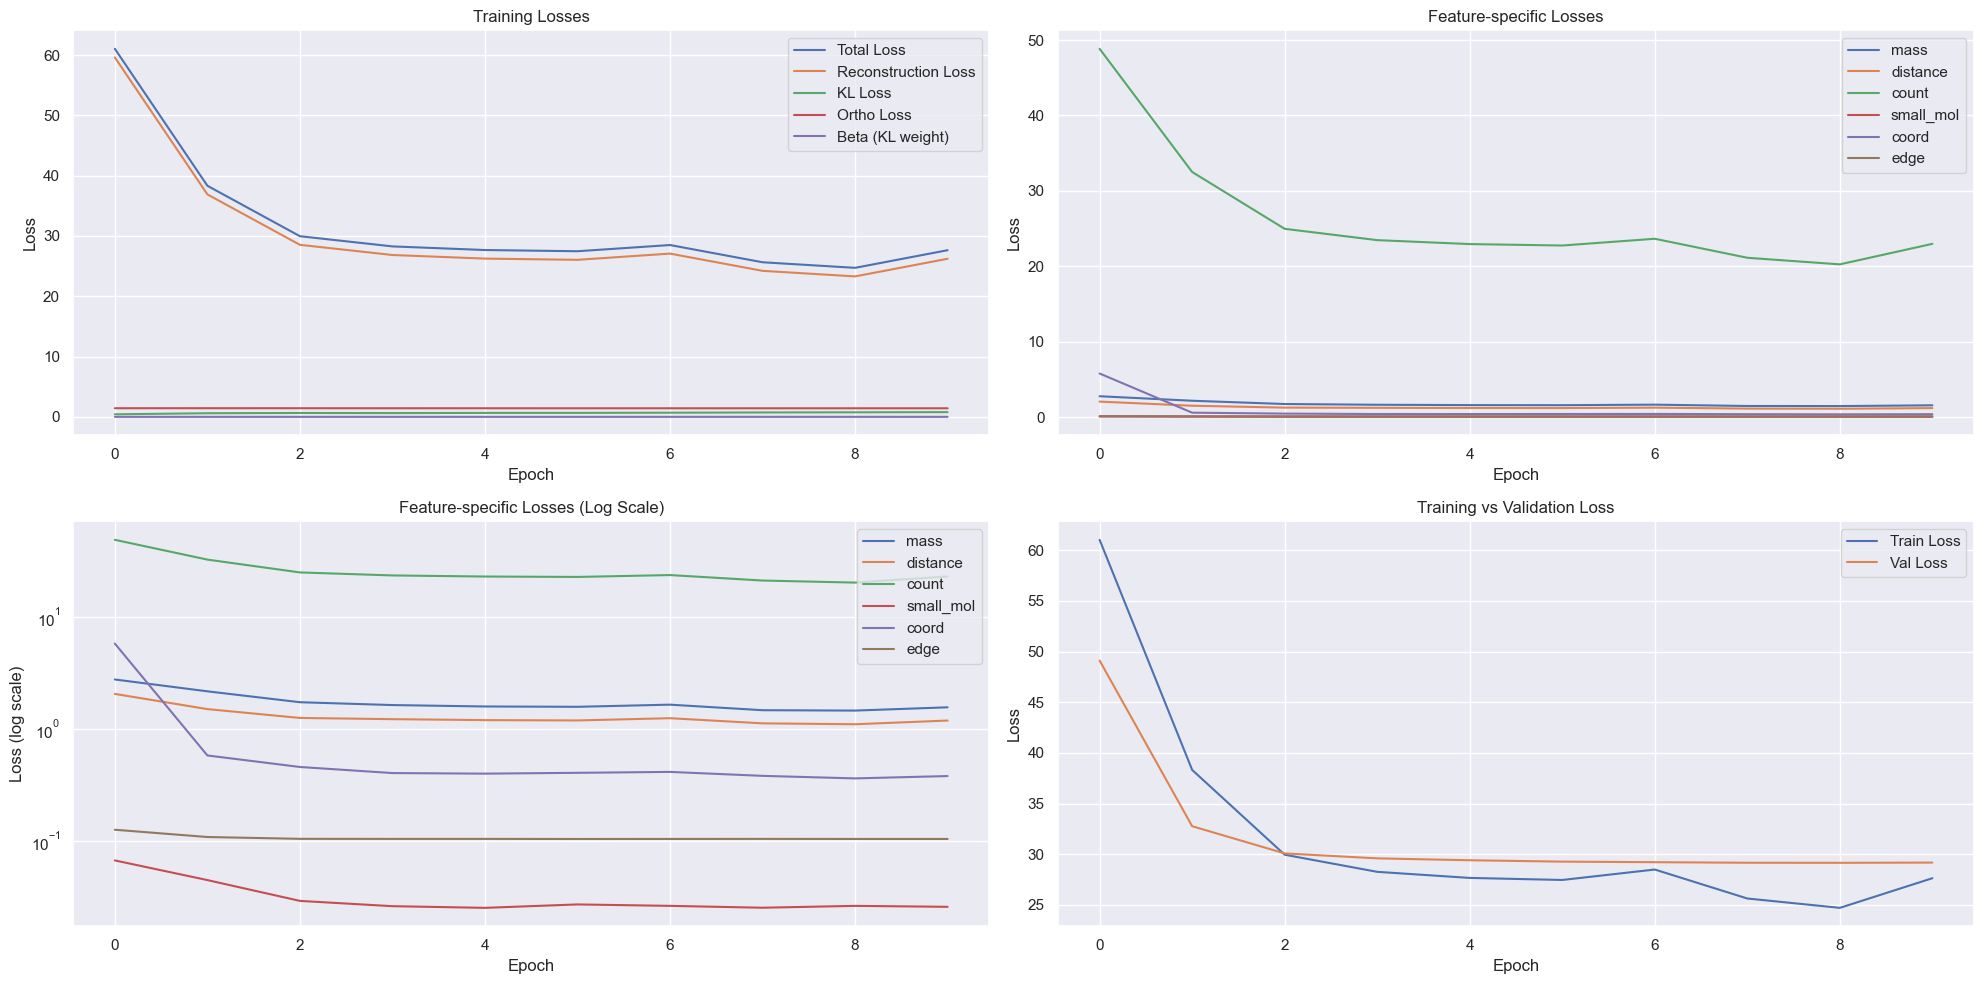


Training completed!


In [117]:
# Adjust batch size for better gradient estimates
train_loader, test_loader, in_channels, norm_params = prepare_graphs_for_vae(
    graphs,
    batch_size=16,  # Increased batch size
    train_ratio=0.8,
    shuffle=True
)

# Update model parameters
model = ProteinGraphVAE(
    in_channels=8,
    hidden_channels=64,
    latent_channels=16,
    num_heads=4,
    edge_dim=1
).to(device)



# Adjust learning rate schedule
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Update loss weights in the model to focus on underperforming features
model.loss_weights = {
    'mass': 0.1,
    'distance': 0.1,
    'count': 0.05,     # Lara: Updated, old=0.2 ; Increased to improve count prediction
    'small_mol': 0.1,
    'coord': 0.1,
    'edge': 0.2       # Increased to improve edge reconstruction
}

# Train with slightly different parameters
num_epochs = 10
model, history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    num_epochs=10,
    min_beta=0.00001,    # Lower starting point
    max_beta=0.005,      # Slightly lower max
    warmup_epochs=25,    # Longer warmup
    lambda_ortho=0.1     # Keep orthogonal regularization as is
)

In [75]:
import torch

# Assuming `model` is your trained ProteinGraphVAE instance
model_path = 'protein_graph_vae.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to protein_graph_vae.pth


# Latent space

In [76]:
def visualize_latent_space(model, data_loader, device='cuda', method='tsne', perplexity=30):
    """
    Visualize the latent space using t-SNE or PCA.

    Parameters:
    - model: Trained ProteinGraphVAE model.
    - data_loader: PyTorch Geometric DataLoader containing graphs.
    - device: 'cuda' or 'cpu'.
    - method: 'tsne' or 'pca' for dimensionality reduction.
    - perplexity: t-SNE perplexity (only for t-SNE).

    Returns:
    - None (displays the plot).
    """
    model.eval()
    model = model.to(device)
    
    latent_vectors = []
    graph_labels = []  # Collect one label per graph

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            
            # Encode to latent space
            mu, _ = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            
            if mu.size(0) == batch.batch.max().item() + 1:
                # mu is already graph-level
                latent_vectors.append(mu.cpu().numpy())
                graph_labels.extend(range(mu.size(0)))
            else:
                # mu is node-level, pool to graph-level
                pooled_mu = global_mean_pool(mu, batch.batch)  # Shape: [num_graphs, latent_dim]
                latent_vectors.append(pooled_mu.cpu().numpy())
                graph_labels.extend(batch.batch.unique().cpu().numpy())  # Graph-level labels
    
    # Concatenate results
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    graph_labels = np.array(graph_labels[:len(latent_vectors)])  # Ensure labels match latent vectors

    # Dimensionality reduction
    if method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'.")
    
    reduced_latent = reducer.fit_transform(latent_vectors)

    # Plotting
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(
        reduced_latent[:, 0],
        reduced_latent[:, 1],
        c=graph_labels[:reduced_latent.shape[0]],  # Use graph-level labels
        cmap='viridis',
        alpha=0.7
    )
    plt.colorbar(scatter, label='Graph Labels')
    plt.title(f'Latent Space Visualization ({method.upper()})')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()



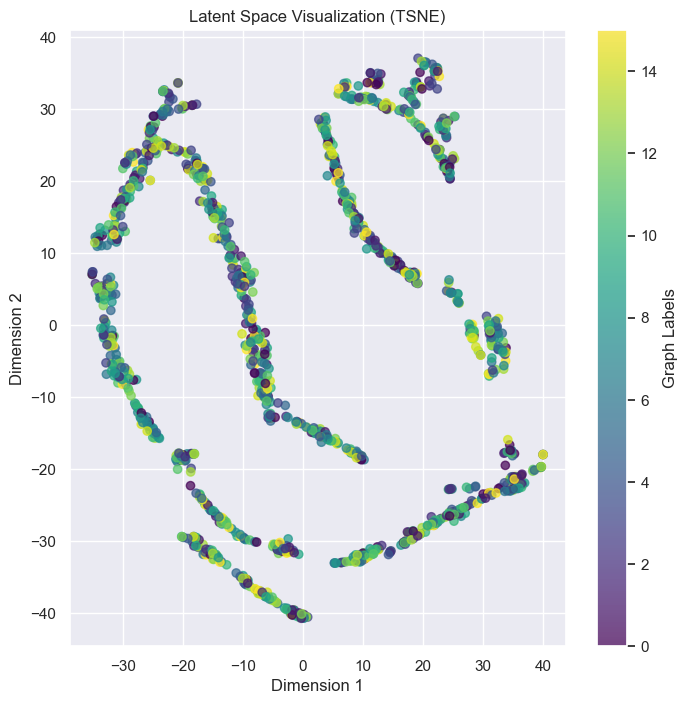

In [77]:
visualize_latent_space(model, train_loader, device=device, method='tsne', perplexity=30)

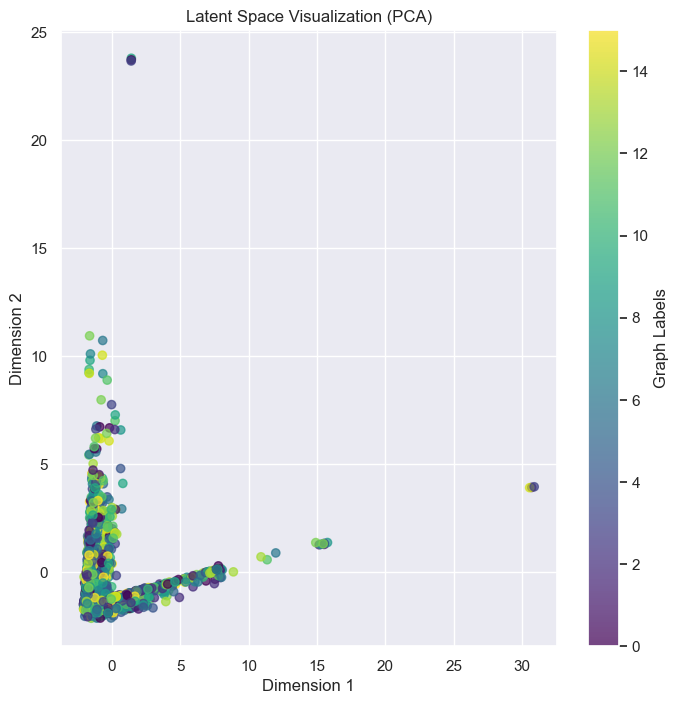

In [78]:
visualize_latent_space(model, train_loader, device=device, method='pca')

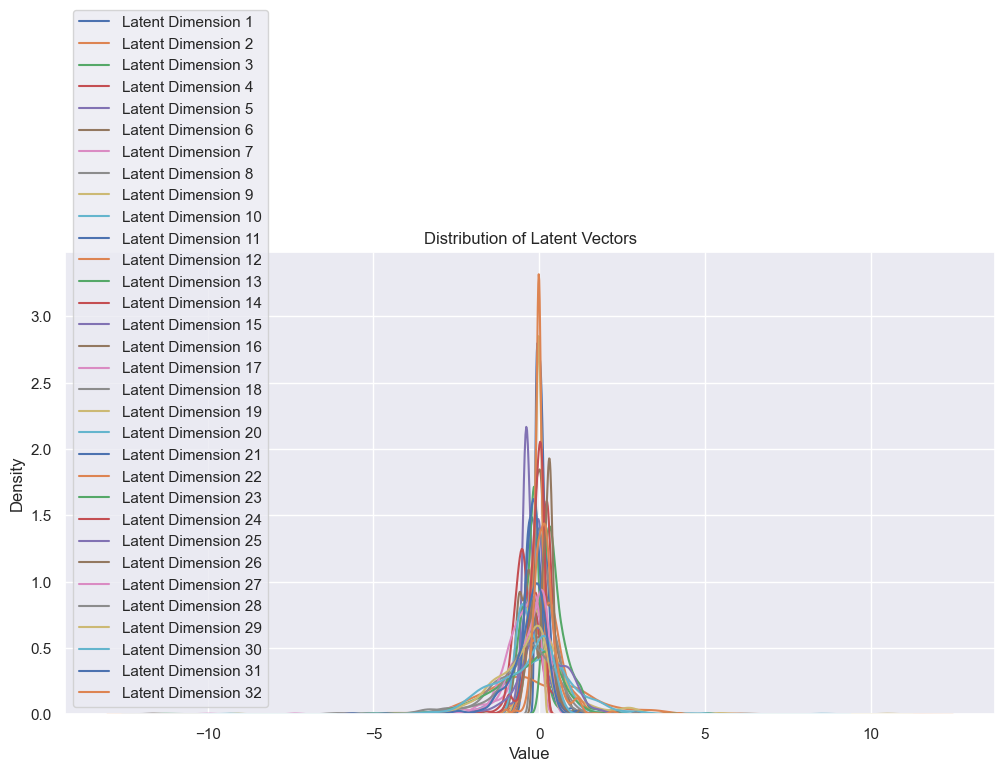

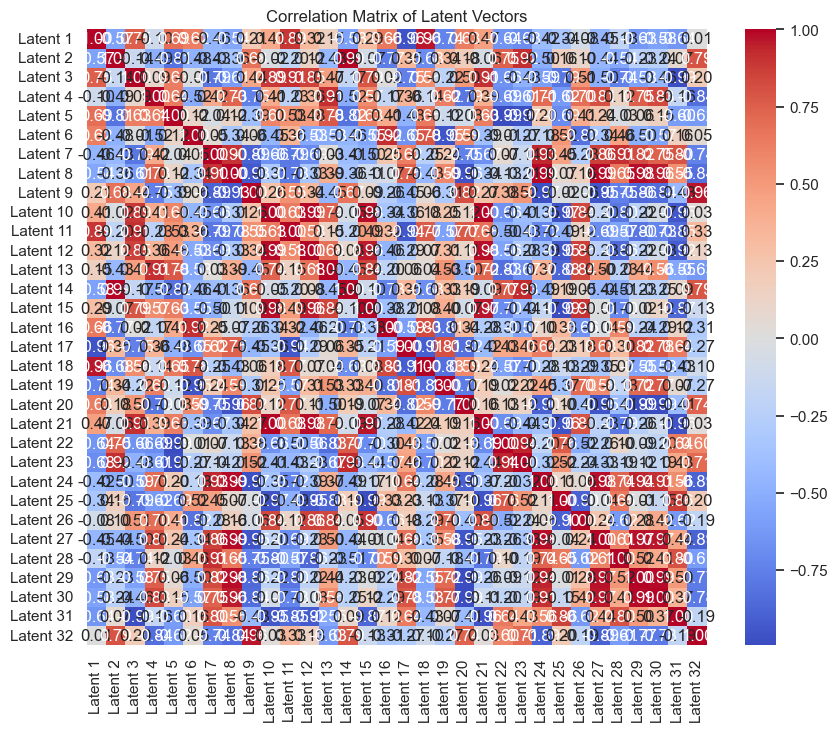

In [79]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_latent_distribution_and_correlation(model, data_loader, device):
    """
    Plot the distribution of latent vectors and the correlation matrix.

    Args:
        model: Trained ProteinGraphVAE model.
        data_loader: DataLoader containing the data.
        device: torch device.
    """
    model.eval()
    latent_vectors = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            mu, logvar = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)

    # Plot the distribution of latent vectors
    plt.figure(figsize=(12, 6))
    for i in range(latent_vectors.shape[1]):
        sns.kdeplot(latent_vectors[:, i], label=f'Latent Dimension {i+1}')
    plt.title('Distribution of Latent Vectors')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Compute and plot the correlation matrix
    correlation_matrix = np.corrcoef(latent_vectors, rowvar=False)
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
                xticklabels=[f'Latent {i+1}' for i in range(latent_vectors.shape[1])],
                yticklabels=[f'Latent {i+1}' for i in range(latent_vectors.shape[1])])
    plt.title('Correlation Matrix of Latent Vectors')
    plt.show()

# Example usage
plot_latent_distribution_and_correlation(model, train_loader, device)

In [80]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import wasserstein_distance

def analyze_latent_space(model, data_loader, device, save_path=None):
    """
    Analyze and visualize the latent space distributions and correlations
    
    Args:
        model: Trained ProteinGraphVAE model
        data_loader: DataLoader containing protein graphs
        device: torch device
        save_path: Optional path to save visualizations
    """
    model.eval()
    latent_vectors = []

    # Collect latent vectors
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            mu, logvar = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            latent_vectors.append(mu.cpu().numpy())

    # Concatenate all latent vectors
    latent_vectors = np.concatenate(latent_vectors, axis=0)

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 10))

    # 1. Distribution plots for each latent dimension
    ax1 = plt.subplot(231)
    for i in range(latent_vectors.shape[1]):
        sns.kdeplot(data=latent_vectors[:, i], ax=ax1, label=f'Dim {i}')
    ax1.set_title('Latent Dimension Distributions')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Density')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 2. Correlation matrix
    ax2 = plt.subplot(232)
    corr_matrix = np.corrcoef(latent_vectors.T)
    sns.heatmap(corr_matrix,
                ax=ax2,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                square=True,
                xticklabels=False,
                yticklabels=False)
    ax2.set_title('Latent Dimension Correlations')

    # 3. PCA visualization
    ax3 = plt.subplot(233)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(latent_vectors)
    scatter = ax3.scatter(pca_result[:, 0],
                          pca_result[:, 1],
                          alpha=0.5,
                          c=np.sum(latent_vectors**2, axis=1),  # Color by L2 norm
                          cmap='viridis')
    plt.colorbar(scatter, ax=ax3, label='L2 Norm')
    ax3.set_title(f'PCA Projection\nExplained Variance: {pca.explained_variance_ratio_.sum():.2%}')

    # 4. Box plot of latent dimensions
    ax4 = plt.subplot(234)
    ax4.boxplot(latent_vectors)
    ax4.set_title('Latent Dimension Ranges')
    ax4.set_xlabel('Dimension')
    ax4.set_ylabel('Value')

    # 5. Dimension-wise statistics
    ax5 = plt.subplot(235)
    stats = pd.DataFrame({
        'Mean': np.mean(latent_vectors, axis=0),
        'Std': np.std(latent_vectors, axis=0),
        'Median': np.median(latent_vectors, axis=0),
        'IQR': np.percentile(latent_vectors, 75, axis=0) - np.percentile(latent_vectors, 25, axis=0)
    })
    stats.index = [f'Dim {i}' for i in range(latent_vectors.shape[1])]
    sns.heatmap(stats,
                ax=ax5,
                cmap='viridis',
                annot=True,
                fmt='.2f')
    ax5.set_title('Dimension-wise Statistics')

    # 6. Wasserstein distance matrix between dimensions
    ax6 = plt.subplot(236)
    n_dims = latent_vectors.shape[1]
    wasserstein_mat = np.zeros((n_dims, n_dims))
    for i in range(n_dims):
        for j in range(n_dims):
            wasserstein_mat[i, j] = wasserstein_distance(
                latent_vectors[:, i],
                latent_vectors[:, j]
            )
    sns.heatmap(wasserstein_mat,
                ax=ax6,
                cmap='viridis',
                square=True,
                xticklabels=False,
                yticklabels=False)
    ax6.set_title('Wasserstein Distances\nbetween Dimensions')

    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # Calculate additional metrics
    metrics = {
        'mean_correlation': np.mean(np.abs(corr_matrix - np.eye(n_dims))),
        'max_correlation': np.max(np.abs(corr_matrix - np.eye(n_dims))),
        'mean_wasserstein': np.mean(wasserstein_mat),
        'dimension_entropy': -np.sum(np.mean(latent_vectors, axis=0) * np.log(np.abs(np.mean(latent_vectors, axis=0)) + 1e-10)),
        'pca_explained_variance': pca.explained_variance_ratio_.sum()
    }

    return fig, metrics

def visualize_latent_traversal(model, data_loader, device, dim_idx=0, n_steps=10):
    """
    Visualize how changing a single latent dimension affects the reconstruction
    
    Args:
        model: Trained ProteinGraphVAE model
        data_loader: DataLoader containing protein graphs
        device: torch device
        dim_idx: Index of dimension to traverse
        n_steps: Number of steps in traversal
    """
    model.eval()

    # Get a sample batch
    batch = next(iter(data_loader)).to(device)

    # Get latent representation
    with torch.no_grad():
        mu, logvar = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        z = model.reparameterize(mu, logvar)

    # Create traversal values
    traversal_range = np.linspace(-3, 3, n_steps)
    reconstructions = []

    # Generate reconstructions
    with torch.no_grad():
        for value in traversal_range:
            z_new = z.clone()
            z_new[:, dim_idx] = value
            recon, edge_recon = model.decode(z_new, batch.x.size(0), batch.edge_index)
            reconstructions.append(recon.cpu().numpy())

    return np.array(reconstructions), traversal_range

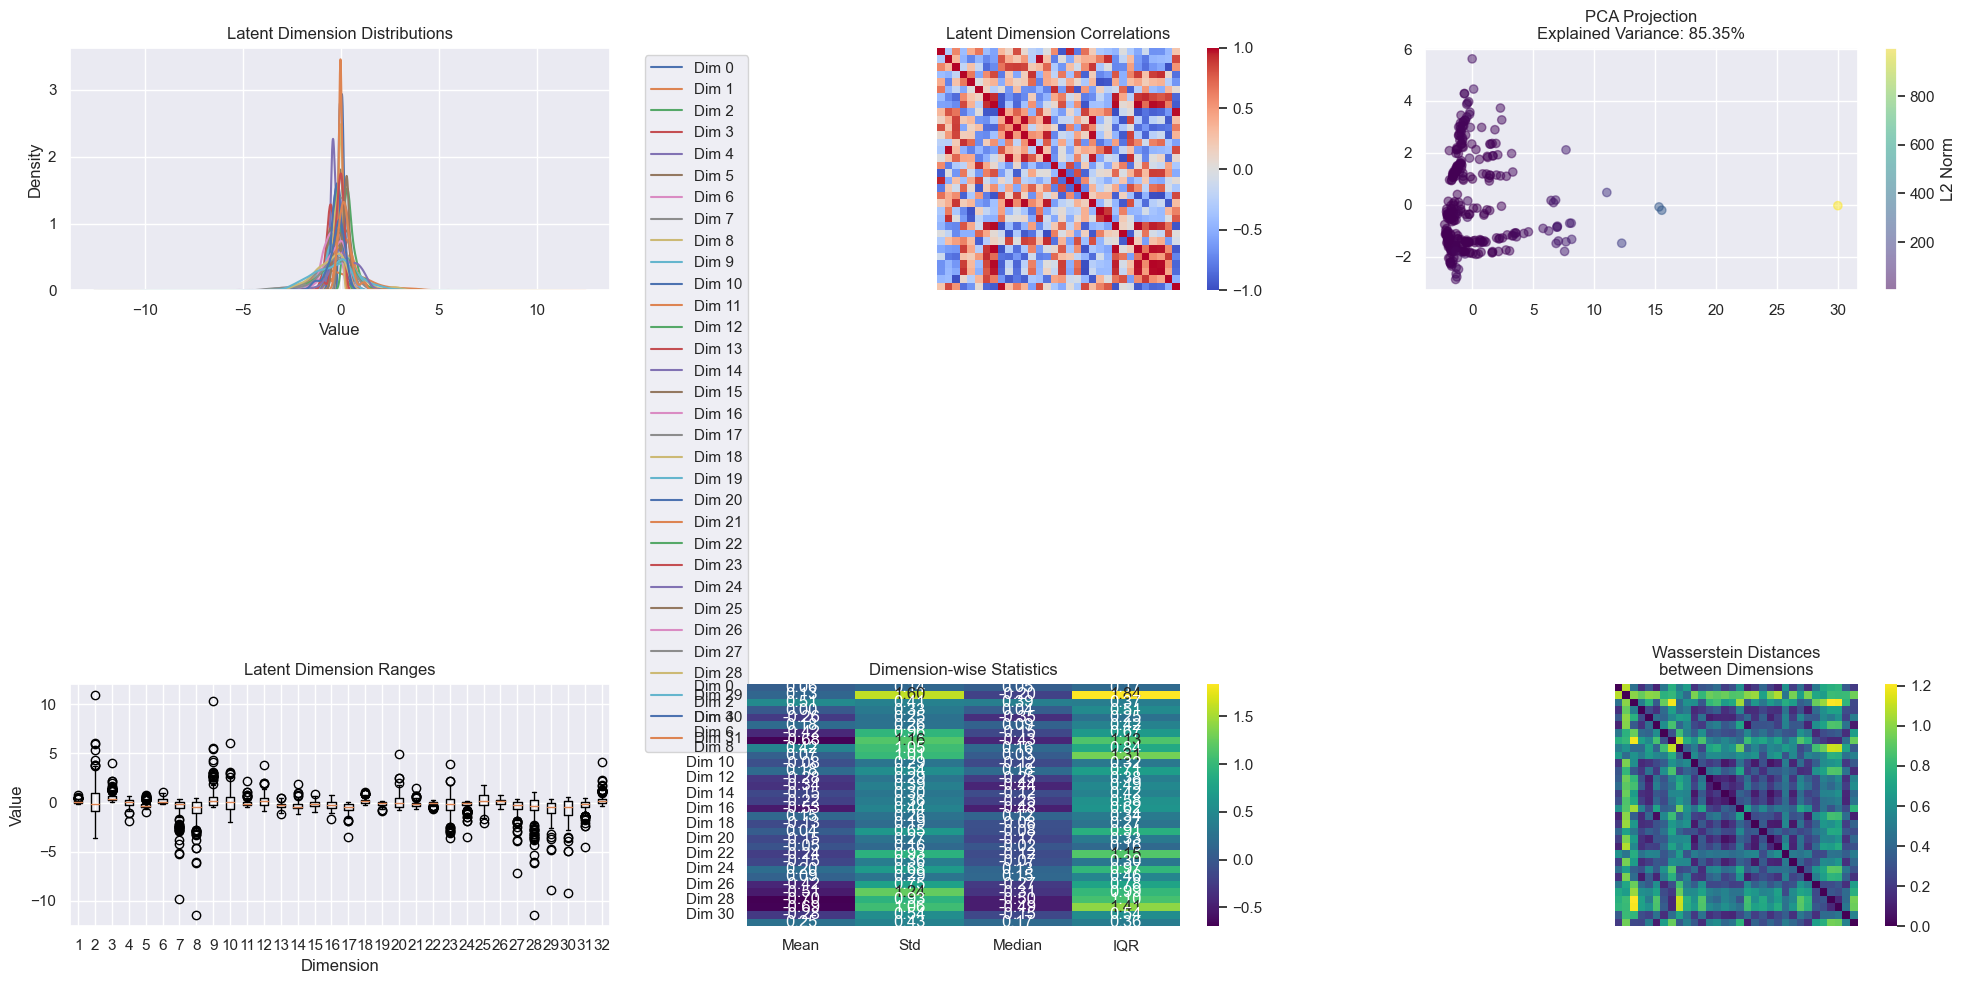

mean_correlation: 0.4954
max_correlation: 0.9980
mean_wasserstein: 0.4472
dimension_entropy: -2.5192
pca_explained_variance: 0.8535


In [81]:
# After training your model
fig, metrics = analyze_latent_space(model, test_loader, device)
plt.show()

# Print latent space metrics
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

# Visualize how changing dimension 0 affects reconstruction
reconstructions, traversal_values = visualize_latent_traversal(model, test_loader, device, dim_idx=0)

# Generator

In [82]:
import torch
from torch_geometric.data import Data
import numpy as np

def generate_edges_from_coordinates(coords, threshold=5.0):
    """
    Generate edges based on distances between node coordinates.
    """
    edge_index = []
    edge_attr = []

    for i in range(coords.size(0)):
        for j in range(i + 1, coords.size(0)):
            dist = torch.norm(coords[i] - coords[j])
            if dist < threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])
                edge_attr.append([dist.item()])
                edge_attr.append([dist.item()])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return edge_index, edge_attr



In [83]:
def generate_protein_graphs(model, graphs, num_samples=5, nodes_per_graph=200, temperature=1.5):
    """
    Generate new protein graphs with diverse node features.
    """
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Step 1: Calculate normalization parameters
    feature_means, feature_stds = norm_params
    print(f"Feature means: {feature_means}")
    print(f"Feature stds: {feature_stds}")

    model.eval()
    model = model.to(device)

    generated_graphs = []

    with torch.no_grad():
        # Step 2: Sample diverse latent vectors
        z = torch.randn(num_samples, model.latent_channels, device=device) * temperature
        print("Sampled latent vectors (z):", z)

        # Step 3: Generate graphs
        for i in range(num_samples):
            # Decode latent vector into node features
            z_expanded = z[i].unsqueeze(0).repeat(nodes_per_graph, 1)
            decoded_features, _ = model.decode(z_expanded, num_nodes=nodes_per_graph, edge_index=torch.empty(2, 0, dtype=torch.long, device=device)) # Placeholder edge_index
            print("Decoded features (before unnormalization):", decoded_features)

            # Unnormalize features
            decoded_features = decoded_features * feature_stds.to(device) + feature_means.to(device)

            # Extract coordinates and generate edges
            coords = decoded_features[:, -3:]  # Last three columns are X, Y, Z
            edge_index, edge_attr = generate_edges_from_coordinates(coords, threshold=5.0)
            print("Edge index:", edge_index)
            print("Edge attributes:", edge_attr)

            # Create PyG Data object
            graph = Data(
                x=decoded_features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            generated_graphs.append(graph)

    return generated_graphs


In [84]:
# Extract only the graphs from the tuples
graph_data = [g[1] for g in graphs]

# Use the extracted graphs to generate proteins
generated_proteins = generate_protein_graphs(
    model=model,
    graphs=graph_data,  # Pass only the graphs
    num_samples=5,
    nodes_per_graph=200,
    temperature=1.5
)

Feature means: tensor([-2.2879e-09, -4.5757e-10,  3.6606e-09,  1.3305e-08, -1.2001e-08,
         6.9406e-09,  7.5005e-09,  5.9287e-09])
Feature stds: tensor([1., 1., 1., 1., 1., 1., 1., 1.])
Sampled latent vectors (z): tensor([[ 0.3398, -0.7944,  0.4709,  0.4872,  1.7135,  1.5668, -0.5694, -0.7921,
         -1.4671,  1.3816, -1.0118, -0.2306, -0.8609,  0.5996, -1.1732,  0.7359,
         -2.6810, -1.8402, -1.1602, -1.1143,  1.5624,  1.5851, -0.8021, -1.4287,
          1.9394, -2.1633, -2.0087,  2.7459,  1.7573,  0.9614,  0.9390,  0.8250],
        [-0.3666,  3.4403, -1.2933, -0.9068, -1.0760,  1.8937,  0.3490, -0.2912,
         -1.5676, -1.0091,  0.1248, -2.1768,  1.2331, -2.6619,  0.0628,  2.3569,
          1.0291, -1.3739, -0.4153,  1.1019,  1.4245, -0.7797,  0.8290,  0.1462,
         -3.3847,  0.9127, -2.2771,  1.6768,  1.1465,  1.5842, -0.3482, -0.1955],
        [-2.4123,  2.1769, -2.3182, -0.3070, -2.1457, -4.0458, -3.1652,  2.2251,
          1.2526,  1.0813,  0.9036,  0.2328,  0.49

In [85]:
# Analyze the generated graphs
for i, protein in enumerate(generated_proteins):
    print(f"Protein {i+1}:")
    print(f"  Number of nodes: {protein.x.size(0)}")
    print(f"  Number of edges: {protein.edge_index.size(1)}")
    print(f"  Feature mean: {protein.x.mean(dim=0)}")
    print(f"  Feature std: {protein.x.std(dim=0)}")


Protein 1:
  Number of nodes: 200
  Number of edges: 39800
  Feature mean: tensor([[-1.7203e-09,  1.9603e-09,  5.7905e-09,  ..., -1.5714e-01,
         -2.3612e-01, -2.5232e-01],
        [-1.7222e-09,  1.9519e-09,  5.7831e-09,  ..., -1.5786e-01,
         -2.3657e-01, -2.5265e-01],
        [-1.7247e-09,  1.9445e-09,  5.7763e-09,  ..., -1.5773e-01,
         -2.3643e-01, -2.5256e-01],
        ...,
        [-1.7025e-09,  2.0265e-09,  5.8494e-09,  ..., -1.5737e-01,
         -2.3580e-01, -2.5188e-01],
        [-1.7286e-09,  1.9292e-09,  5.7628e-09,  ..., -1.5750e-01,
         -2.3636e-01, -2.5263e-01],
        [-1.7202e-09,  1.9611e-09,  5.7912e-09,  ..., -1.5708e-01,
         -2.3576e-01, -2.5194e-01]])
  Feature std: tensor([[1.0548e-10, 3.9954e-10, 3.5535e-10,  ..., 7.8985e-03, 6.8404e-03,
         6.6408e-03],
        [1.0865e-10, 4.1071e-10, 3.6521e-10,  ..., 7.5842e-03, 6.3945e-03,
         6.2265e-03],
        [1.0192e-10, 3.8682e-10, 3.4377e-10,  ..., 7.1801e-03, 6.0451e-03,
         

(test latest version)

In [86]:
import torch
import numpy as np
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from torch_geometric.data import Data

def generate_protein_graphs(model, norm_params, num_samples=1, nodes_per_graph=100, temperature=1.0):
    """Generate new protein graphs with diverse node features"""
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    feature_means, feature_stds = norm_params  # Unpack normalization parameters
    model.eval()
    model = model.to(device)

    generated_graphs = []

    with torch.no_grad():
        # Sample from normal distribution
        z = torch.randn(num_samples, model.latent_channels, device=device) * temperature

        # Add node-specific variations
        z = z.unsqueeze(1).repeat(1, nodes_per_graph, 1)
        node_noise = torch.randn_like(z) * 0.1
        z = z + node_noise

        # Reshape for decoder
        z = z.view(-1, model.latent_channels)

        # Create initial dummy edge_index for decoding
        edge_index = torch.arange(nodes_per_graph * num_samples, device=device)
        edge_index = edge_index.repeat(2, 1)  # [2, num_nodes]

        # Decode the latent vectors
        decoded, _ = model.decode(z, nodes_per_graph, edge_index)

        # Unnormalize the features
        decoded = decoded * feature_stds.to(device) + feature_means.to(device)


        # Process each generated graph
        for i in range(num_samples):
            # Extract features for this graph
            start_idx = i * nodes_per_graph
            end_idx = (i + 1) * nodes_per_graph
            features = decoded[i]  # Get features for this graph

            # Generate edges based on coordinates
            coords = features[..., -3:]
            edge_index = []
            edge_attr = []

            for j in range(len(coords)):
                for k in range(j + 1, len(coords)):
                    dist = torch.norm(coords[j] - coords[k])
                    if dist < 5.0:  # Threshold for edge creation
                        edge_index.extend([[j, k], [k, j]])
                        edge_attr.extend([dist.item(), dist.item()])

            if len(edge_index) > 0:
                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)
            else:
                # Fallback: connect nearest neighbors if no edges were created
                dists = torch.cdist(coords, coords)
                k = 3  # Connect to k nearest neighbors
                _, indices = torch.topk(-dists, k + 1)  # Negative for closest

                edge_index = []
                edge_attr = []
                for j in range(len(coords)):
                    for idx in indices[j][1:]:  # Skip self
                        edge_index.extend([[j, idx.item()], [idx.item(), j]])
                        dist = dists[j, idx].item()
                        edge_attr.extend([dist, dist])

                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)

            # Create graph
            graph = Data(
                x=features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            generated_graphs.append(graph)

    return generated_graphs


def interpolate_proteins(model, protein1, protein2, num_steps=10, device='cuda'):
    """
    Generate interpolated proteins between two existing proteins
    """
    model.eval()
    model = model.to(device)

    # Convert proteins to batches
    batch1 = torch.zeros(protein1.x.size(0), dtype=torch.long)
    batch2 = torch.zeros(protein2.x.size(0), dtype=torch.long)

    # Get latent representations
    with torch.no_grad():
        protein1 = protein1.to(device)
        protein2 = protein2.to(device)

        mu1, _ = model.encode(protein1.x, protein1.edge_index, protein1.edge_attr, batch1)
        mu2, _ = model.encode(protein2.x, protein2.edge_index, protein2.edge_attr, batch2)

        # Interpolate in latent space
        interpolated_graphs = []
        alphas = np.linspace(0, 1, num_steps)

        max_nodes = max(protein1.x.size(0), protein2.x.size(0))

        for alpha in alphas:
            # Interpolate latent vectors
            z = (1 - alpha) * mu1 + alpha * mu2

            # Create initial dummy edge_index for decoding
            edge_index = torch.arange(max_nodes, device=device)
            edge_index = edge_index.repeat(2, 1)  # [2, num_nodes]

            # Decode
            decoded, _ = model.decode(z.unsqueeze(0), max_nodes, edge_index)
            decoded = decoded[0]

            # Process decoded features
            coords = decoded[:, -3:]

            # Generate edges based on distances
            edge_index = []
            edge_attr = []

            for i in range(len(coords)):
                for j in range(i + 1, len(coords)):
                    dist = torch.norm(coords[i] - coords[j])
                    if dist < 5.0:
                        edge_index.extend([[i, j], [j, i]])
                        edge_attr.extend([dist.item(), dist.item()])

            if len(edge_index) > 0:
                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)
            else:
                edge_index = torch.arange(len(coords)).repeat(2, 1)
                edge_attr = torch.ones(len(coords), 1)

            # Create graph
            graph = Data(
                x=decoded,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            interpolated_graphs.append(graph)

    return interpolated_graphs
def visualize_protein_graph(graph, title="Generated Protein Structure"):
    """Improved visualization of protein graph"""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Get coordinates
    coords = graph.x[:, -3:].cpu().numpy()
    masses = graph.x[:, 0].cpu().numpy()  # Use mass for point size
    small_mols = graph.x[:, 4].cpu().numpy()  # Use for coloring

    # Scale masses for visualization
    sizes = 50 + (masses - masses.min()) / (masses.max() - masses.min()) * 100

    # Plot nodes with size based on mass and color based on small molecules
    scatter = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                         c=small_mols, cmap='coolwarm',
                         s=sizes, alpha=0.6)

    # Plot edges
    edges = graph.edge_index.cpu().numpy()
    for i in range(0, edges.shape[1], 2):
        start = coords[edges[0, i]]
        end = coords[edges[1, i]]
        ax.plot([start[0], end[0]],
                [start[1], end[1]],
                [start[2], end[2]], 'gray', alpha=0.2)

    plt.colorbar(scatter, label='Small Molecules')
    ax.set_title(title)

    # Set equal aspect ratio
    ax.set_box_aspect([1,1,1])

    plt.show()


# Example usage:
def generate_and_visualize_proteins(model, device='cuda'):
    """
    Generate and visualize some example proteins
    """
    # Generate new proteins
    print("Generating new proteins...")
    generated = generate_protein_graphs(model, num_samples=3, nodes_per_graph=100, device=device)

    # Visualize each generated protein
    for i, graph in enumerate(generated):
        visualize_protein_graph(graph, f"Generated Protein {i+1}")

    return generated

def interpolate_and_visualize(model, protein1, protein2, device='cuda'):
    """
    Interpolate between two proteins and visualize the results
    """
    print("Generating interpolated proteins...")
    interpolated = interpolate_proteins(model, protein1, protein2, num_steps=5, device=device)

    # Visualize interpolation
    for i, graph in enumerate(interpolated):
        visualize_protein_graph(graph, f"Interpolation Step {i+1}")

    return interpolated

def print_graph_info(graph, title="Graph Info", num_samples=5):
    print(f"\n{title}")
    print(f"Node features shape: {graph.x.shape}")
    print(f"Edge index shape: {graph.edge_index.shape}")

    # Print feature statistics
    print("\nFeature statistics:")
    print(f"Mass range: {graph.x[:, 0].min().item():.2f} to {graph.x[:, 0].max().item():.2f}")
    print(f"Avg Neighbor Dist range: {graph.x[:, 1].min().item():.2f} to {graph.x[:, 1].max().item():.2f}")
    print(f"Max Neighbor Dist range: {graph.x[:, 2].min().item():.2f} to {graph.x[:, 2].max().item():.2f}")
    print(f"Neighbor Count range: {graph.x[:, 3].min().item():.2f} to {graph.x[:, 3].max().item():.2f}")
    print(f"Small Molecules ratio: {graph.x[:, 4].mean().item():.2f}")

    print("\nSample nodes:")
    for i in range(min(num_samples, len(graph.x))):
        features = graph.x[i]
        print(f"\nNode {i}:")
        print(f"  Mass: {features[0].item():.2f}")
        print(f"  Avg/Max Neighbor Dist: {features[1].item():.2f}/{features[2].item():.2f}")
        print(f"  Neighbor Count: {features[3].item():.0f}")
        print(f"  Small Molecules: {features[4].item():.0f}")
        print(f"  Coordinates: ({features[5].item():.2f}, {features[6].item():.2f}, {features[7].item():.2f})")


In [87]:
generated_proteins = generate_protein_graphs(
    model=model,               # The trained model
    norm_params=norm_params,   # Use normalization parameters from preprocessing
    num_samples=3,             # Number of proteins to generate
    nodes_per_graph=100,       # Number of nodes per generated graph
    temperature=1.0            # Sampling diversity
)

In [101]:
def map_mass_to_color(mass_value):
    """Map a mass value to the closest amino acid color."""
    # Scale the negative values around -9.76 to the amino acid mass range
    scaled_mass = (abs(mass_value) + 1) * 20  # This should map to 75-255 range

    print(f"Original mass: {mass_value}, Scaled mass: {scaled_mass}")
    closest_aa = min(AMINO_ACID_DATA,
                     key=lambda x: abs(x[0] - scaled_mass))
    return closest_aa[2]

def visualize_generated_protein_graph(data, title="Generated Protein Graph"):
    # First create the initial graph with all attributes
    original_G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])

    # Store node attributes before filtering
    node_attrs = {node: attrs['x'] for node, attrs in original_G.nodes(data=True)}

    # Create filtered graph while preserving node attributes
    edge_threshold = 0.003
    G = nx.Graph((u, v, d) for u, v, d in original_G.edges(data=True)
                 if float(d['edge_attr'][0]) > edge_threshold)

    # Add back node attributes
    nx.set_node_attributes(G, {node: {'x': attrs} for node, attrs in node_attrs.items()})

    pos = nx.spring_layout(G, k=2.0, iterations=100, seed=42)

    node_colors = [map_mass_to_color(node_attrs[node][4]) for node in G.nodes()]
    node_sizes = [max(300, abs(float(node_attrs[node][5]) * 2000)) for node in G.nodes()]

    edge_weights = [
        max(0.1, min(1.0, float(edge[2]['edge_attr'][0]) * 50))
        for edge in G.edges(data=True)
    ]

    plt.figure(figsize=(12, 12))

    nx.draw(
        G,
        pos,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color='gray',
        width=edge_weights,
        alpha=0.7,
        with_labels=False
    )

    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                  markerfacecolor=color, label=name, markersize=10)
                       for mass, name, color in AMINO_ACID_DATA]
    plt.legend(handles=legend_elements, loc='center left',
               bbox_to_anchor=(1, 0.5), title="Amino Acids")

    plt.title(title)
    plt.tight_layout()
    plt.show()

Original mass: -9.760345458984375, Scaled mass: 215.2069091796875
Original mass: -9.728754043579102, Scaled mass: 214.57508087158203
Original mass: -9.573446273803711, Scaled mass: 211.46892547607422
Original mass: -9.603184700012207, Scaled mass: 212.06369400024414
Original mass: -9.53791618347168, Scaled mass: 210.7583236694336
Original mass: -10.025009155273438, Scaled mass: 220.50018310546875
Original mass: -9.456985473632812, Scaled mass: 209.13970947265625
Original mass: -9.668157577514648, Scaled mass: 213.36315155029297
Original mass: -9.661712646484375, Scaled mass: 213.2342529296875
Original mass: -9.764103889465332, Scaled mass: 215.28207778930664
Original mass: -9.645195960998535, Scaled mass: 212.9039192199707
Original mass: -9.522172927856445, Scaled mass: 210.4434585571289
Original mass: -9.414767265319824, Scaled mass: 208.29534530639648
Original mass: -9.978666305541992, Scaled mass: 219.57332611083984
Original mass: -9.79273796081543, Scaled mass: 215.8547592163086
Or

/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_91343/40893172.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


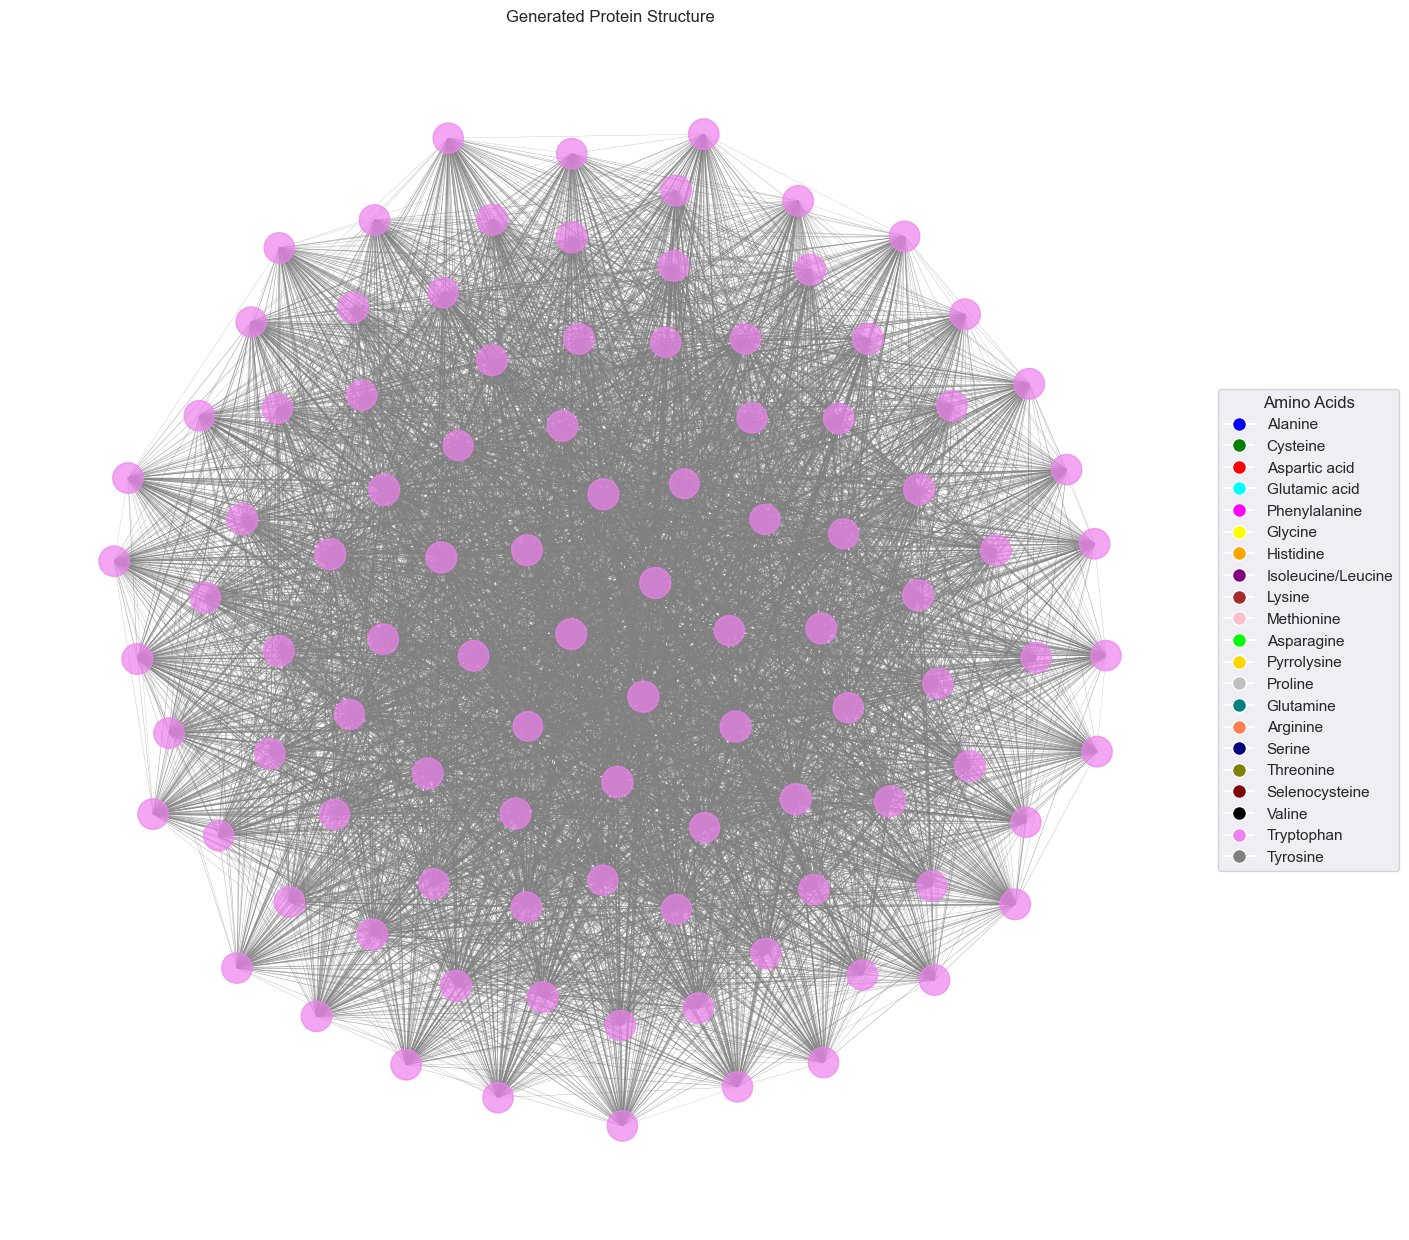

In [102]:
generated_protein = generated_proteins[0]  # Assume you have generated graphs
visualize_generated_protein_graph(generated_protein, title="Generated Protein Structure")


In [89]:
generated_proteins[0]

Data(x=[100, 8], edge_index=[2, 9900], edge_attr=[9900, 1])

In [90]:
generated_proteins[1]

Data(x=[100, 8], edge_index=[2, 9900], edge_attr=[9900, 1])

New generator: 

In [91]:
def generate_protein_graphs(model, norm_params, num_samples=3, nodes_per_graph=100, temperature=1.0):
    """Generate new protein graphs with diverse node features"""
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    feature_means, feature_stds = norm_params  # Unpack normalization parameters
    model.eval()
    model = model.to(device)

    generated_graphs = []

    with torch.no_grad():
        # Sample diverse latent vectors
        z = torch.randn(num_samples, model.latent_channels, device=device) * temperature

        # Add small random noise for variability
        z = z + torch.randn_like(z) * 0.1

        for i in range(num_samples):
            # Expand latent vector for all nodes
            z_expanded = z[i].unsqueeze(0).repeat(nodes_per_graph, 1)

            # Decode latent vectors into node features
            decoded_features, _ = model.decode(z_expanded, nodes_per_graph, edge_index=None)

            # Unnormalize features
            decoded_features = decoded_features * feature_stds.to(device) + feature_means.to(device)

            # Generate edges based on spatial coordinates (decoded)
            coords = decoded_features[:, -3:]  # Extract X, Y, Z
            edge_index, edge_attr = generate_edges_from_coordinates(coords, threshold=5.0)

            # Create PyG Data object
            graph = Data(
                x=decoded_features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            generated_graphs.append(graph)

    return generated_graphs


def generate_edges_from_coordinates(coords, threshold=5.0):
    """Generate edges based on distances between coordinates"""
    edge_index = []
    edge_attr = []

    for i in range(coords.size(0)):
        for j in range(i + 1, coords.size(0)):
            dist = torch.norm(coords[i] - coords[j])
            if dist < threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])
                edge_attr.append([dist.item()])
                edge_attr.append([dist.item()])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    return edge_index, edge_attr


In [103]:
generated_proteins = generate_protein_graphs(
    model=model,
    norm_params=(, feature_stds),
    num_samples=3,
    nodes_per_graph=100,
    temperature=1.0
)

# Check if graphs are diverse
for i, graph in enumerate(generated_proteins):
    print(f"Graph {i}: Node Features Mean: {graph.x.mean(dim=0)}, Std: {graph.x.std(dim=0)}")


NameError: name 'feature_means' is not defined